# Steaming Big Data Analytics & Data Analytics Pipeline

## Streaming Analytics 

## Tasks

**(1) Pull the stock data of “AAPL” at 1-minute level data resolution every 5 minutes. Each such pull made once every 5 minutes should have data from the (current timestamp - one hour) to the current timestamp when you hit the api i.e. one hour's worth of data in each pull. Let this process run for 30 minutes. At the end of your program, your code should have generated ~1.5 hours’ worth of data for the stock and the api should have been called 7 times (once every 5 minutes, over a period of 30 minutes).**

**(2) In each data pull, the data should be incrementally loaded into a Spark data frame where the dataframe schema will be [‘Stock Name’, “UTC Timestamp”, “c”, “l”, ”h”, ”o”, ”v”] where UTC timestamp will be obtained by converting the UNIX timestamps of each entry the api call will return under the “t” key. Incremental loading entails fetching data in stages. Initially, data covering an hour, say from timestamp x to x+60 minutes, is retrieved and stored in a dataframe. In the subsequent pull, fetch data from x+5 minutes to x+65 minutes. The data from x+5 to x+60 minutes, already present in the dataframe, gets replaced by the new pull (though it might remain the same in our exercise, real world scenarios could witness changes in the same data points pulled at different intervals.**

HINT: To do this filtering operation explore the concept of antijoins). The data points from x+60 to x+65 minutes are directly added. This process is repeated for all pulls within the next 30 minutes, resulting in a data frame containing data from x to x+1.5 hours. (It may exactly not be 1.5hours since the api sometimes may not return the exact timestamp till which you request due to lags and a few datapoints maybe missing here and there which is fine)

**(3) Every 5 minutes, after inserting data into the dataframe created in part (2), compute the 30-minute moving averages for each stock's "c", "l", "h", "o", and "v" values. Store these moving averages incrementally in a separate PySpark dataframe with the schema ["Datetime", "c_MA", "l_MA", "h_MA", "o_MA", "v_MA"], where "Datetime" represents the end timestamp of the moving average window.**

In [1]:
!pip install finnhub-python

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import from_unixtime, col, lit, round
from pyspark.sql.window import Window
from pyspark.sql.types import StructType, StructField, StringType, LongType, DoubleType
from pyspark.sql import functions as F
import finnhub
import time
import logging

# Initialize Spark session
spark = SparkSession.builder.appName("StockData").getOrCreate()
# Initialize Finnhub client
finnhub_client = finnhub.Client(api_key="cknm5ghr01qrbal9b750cknm5ghr01qrbal9b75g")
logger = spark._jvm.org.apache.log4j
logger.LogManager.getLogger("org.apache.spark.sql.execution.window.WindowExec").setLevel(logger.Level.ERROR)

# Define schema for stock data
schema = StructType([
    StructField("Stock Name", StringType(), True),
    StructField("UTC Timestamp", LongType(), True),
    StructField("c", DoubleType(), True),
    StructField("l", DoubleType(), True),
    StructField("h", DoubleType(), True),
    StructField("o", DoubleType(), True),
    StructField("v", DoubleType(), True),
])

# Create an empty DataFrame with the specified schema
stock_data_df = spark.createDataFrame([], schema=schema)
print(stock_data_df)

# Define schema for moving averages
ma_schema = StructType([
    StructField("Stock", StringType(), True),
    StructField("Datetime", StringType(), True),
    StructField("c_MA", DoubleType(), True),
    StructField("l_MA", DoubleType(), True),
    StructField("h_MA", DoubleType(), True),
    StructField("o_MA", DoubleType(), True),
    StructField("v_MA", DoubleType(), True),
])

# Create an empty DataFrame for moving averages with the specified schema
moving_avg_df = spark.createDataFrame(spark.sparkContext.emptyRDD(), schema=ma_schema)
print(moving_avg_df)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/10/19 18:48:15 INFO SparkEnv: Registering MapOutputTracker
23/10/19 18:48:15 INFO SparkEnv: Registering BlockManagerMaster
23/10/19 18:48:15 INFO SparkEnv: Registering BlockManagerMasterHeartbeat
23/10/19 18:48:15 INFO SparkEnv: Registering OutputCommitCoordinator


DataFrame[Stock Name: string, UTC Timestamp: bigint, c: double, l: double, h: double, o: double, v: double]
DataFrame[Stock: string, Datetime: string, c_MA: double, l_MA: double, h_MA: double, o_MA: double, v_MA: double]


In [3]:
# Define time interval and total runtime
interval_minutes = 5
total_runtime_minutes = 30

# Fetch and process data every 5 minutes for a total runtime of 30 minutes
for number in range((total_runtime_minutes // interval_minutes)+1):
    # Calculate time range for data pull
    end_timestamp = int(time.time())
    start_timestamp = end_timestamp - 3600  # 1 hour ago

    # Fetch stock data
    api_data = finnhub_client.stock_candles('AAPL', '1', start_timestamp, end_timestamp)

    # Convert UNIX timestamps to UTC Timestamp
    converted_data = [
        ("AAPL", int(api_data["t"][i]), float(api_data["c"][i]), float(api_data["l"][i]),
         float(api_data["h"][i]), float(api_data["o"][i]), float(api_data["v"][i]))
        for i in range(len(api_data["t"]))
    ]

    # Create a DataFrame from the fetched data
    new_data_df = spark.createDataFrame(converted_data, schema=schema)
    
    print(f'No.{number+1} pulling data')
    
    # Perform incremental loading using antijoins
    stock_data_df = stock_data_df.alias('a').join(
        new_data_df.alias('b'),
        (col('a.`UTC Timestamp`') == col('b.`UTC Timestamp`')),
        'left_anti'
    ).select('a.*').union(new_data_df)
    stock_data_df.show(10, truncate=False)
    stock_data_df.orderBy('UTC Timestamp', ascending=False).limit(10).show(truncate=False)

    # Calculate 30-minute moving averages
    window_spec = Window.orderBy('UTC Timestamp').rangeBetween(-1800, 0)
    new_avg_df = stock_data_df.withColumn('Stock', lit('AAPL')) \
        .withColumn('Datetime', from_unixtime('UTC Timestamp')) \
        .withColumn('c_MA', round(F.avg('c').over(window_spec), 4)) \
        .withColumn('l_MA', round(F.avg('l').over(window_spec), 4)) \
        .withColumn('h_MA', round(F.avg('h').over(window_spec), 4)) \
        .withColumn('o_MA', round(F.avg('o').over(window_spec), 4)) \
        .withColumn('v_MA', round(F.avg('v').over(window_spec), 4)) \
        .drop('UTC Timestamp', 'Stock Name', 'c', 'l', 'h', 'o', 'v')
    
    # Perform incremental loading using antijoins
    moving_avg_df = moving_avg_df.alias('c').join(
        new_avg_df.alias('d'),
        (col('c.`Datetime`') == col('d.`Datetime`')),
        'left_anti'
    ).select('c.*').union(new_avg_df)
    moving_avg_df.show(10, truncate=False)
    moving_avg_df.orderBy('Datetime', ascending=False).limit(10).show(truncate=False)

    # Sleep for 5 minutes before the next iteration
    time.sleep(interval_minutes * 60)

# Stop the Spark session
spark.stop()

No.1 pulling data


+----------+-------------+--------+--------+-------+--------+-------+
|Stock Name|UTC Timestamp|c       |l       |h      |o       |v      |
+----------+-------------+--------+--------+-------+--------+-------+
|AAPL      |1697737740   |176.67  |176.66  |176.76 |176.74  |53592.0|
|AAPL      |1697737800   |176.8   |176.6701|176.8  |176.69  |68108.0|
|AAPL      |1697737860   |176.7199|176.65  |176.87 |176.81  |90931.0|
|AAPL      |1697737920   |176.8   |176.67  |176.8  |176.7199|46210.0|
|AAPL      |1697737980   |176.8   |176.78  |176.915|176.805 |62926.0|
|AAPL      |1697738040   |176.795 |176.75  |176.85 |176.79  |40877.0|
|AAPL      |1697738100   |177.0   |176.79  |177.01 |176.8   |97702.0|
|AAPL      |1697738160   |176.99  |176.87  |177.0  |176.98  |98332.0|
|AAPL      |1697738220   |176.91  |176.91  |177.01 |176.99  |72974.0|
|AAPL      |1697738280   |176.8046|176.79  |176.93 |176.9   |60259.0|
+----------+-------------+--------+--------+-------+--------+-------+
only showing top 10 

+----------+-------------+--------+------+--------+--------+--------+
|Stock Name|UTC Timestamp|c       |l     |h       |o       |v       |
+----------+-------------+--------+------+--------+--------+--------+
|AAPL      |1697741220   |175.6396|175.59|175.67  |175.61  |122966.0|
|AAPL      |1697741160   |175.625 |175.62|175.7499|175.69  |92186.0 |
|AAPL      |1697741100   |175.6946|175.62|175.77  |175.6245|129037.0|
|AAPL      |1697741040   |175.62  |175.62|175.71  |175.691 |97413.0 |
|AAPL      |1697740980   |175.7   |175.66|175.76  |175.68  |117566.0|
|AAPL      |1697740920   |175.665 |175.65|175.76  |175.7587|87837.0 |
|AAPL      |1697740860   |175.7602|175.71|175.77  |175.75  |74407.0 |
|AAPL      |1697740800   |175.76  |175.75|175.9399|175.92  |113200.0|
|AAPL      |1697740740   |175.93  |175.81|175.99  |175.83  |69592.0 |
|AAPL      |1697740680   |175.82  |175.81|175.98  |175.97  |112954.0|
+----------+-------------+--------+------+--------+--------+--------+



+-----+-------------------+--------+--------+--------+--------+----------+
|Stock|Datetime           |c_MA    |l_MA    |h_MA    |o_MA    |v_MA      |
+-----+-------------------+--------+--------+--------+--------+----------+
|AAPL |2023-10-19 17:49:00|176.67  |176.66  |176.76  |176.74  |53592.0   |
|AAPL |2023-10-19 17:50:00|176.735 |176.6651|176.78  |176.715 |60850.0   |
|AAPL |2023-10-19 17:51:00|176.73  |176.66  |176.81  |176.7467|70877.0   |
|AAPL |2023-10-19 17:52:00|176.7475|176.6625|176.8075|176.74  |64710.25  |
|AAPL |2023-10-19 17:53:00|176.758 |176.686 |176.829 |176.753 |64353.4   |
|AAPL |2023-10-19 17:54:00|176.7642|176.6967|176.8325|176.7592|60440.6667|
|AAPL |2023-10-19 17:55:00|176.7978|176.71  |176.8579|176.765 |65763.7143|
|AAPL |2023-10-19 17:56:00|176.8219|176.73  |176.8756|176.7919|69834.75  |
|AAPL |2023-10-19 17:57:00|176.8317|176.75  |176.8906|176.8139|70183.5556|
|AAPL |2023-10-19 17:58:00|176.829 |176.754 |176.8945|176.8225|69191.1   |
+-----+------------------

+-----+-------------------+--------+--------+--------+--------+----------+
|Stock|Datetime           |c_MA    |l_MA    |h_MA    |o_MA    |v_MA      |
+-----+-------------------+--------+--------+--------+--------+----------+
|AAPL |2023-10-19 18:47:00|176.2204|176.1586|176.3237|176.2561|98052.6452|
|AAPL |2023-10-19 18:46:00|176.2565|176.1944|176.3625|176.2939|95734.0323|
|AAPL |2023-10-19 18:45:00|176.2931|176.2276|176.3979|176.3304|94421.7419|
|AAPL |2023-10-19 18:44:00|176.3294|176.2644|176.4373|176.3719|92077.5806|
|AAPL |2023-10-19 18:43:00|176.3715|176.3051|176.4786|176.4117|90512.8065|
|AAPL |2023-10-19 18:42:00|176.411 |176.3451|176.5186|176.4512|89728.7419|
|AAPL |2023-10-19 18:41:00|176.4502|176.3825|176.5579|176.4897|88466.8065|
|AAPL |2023-10-19 18:40:00|176.4886|176.4167|176.597 |176.5226|87953.2258|
|AAPL |2023-10-19 18:39:00|176.5129|176.4389|176.6189|176.5427|87111.6667|
|AAPL |2023-10-19 18:38:00|176.5422|176.4716|176.6495|176.5773|87201.7   |
+-----+------------------

+----------+-------------+--------+--------+-------+--------+-------+
|Stock Name|UTC Timestamp|c       |l       |h      |o       |v      |
+----------+-------------+--------+--------+-------+--------+-------+
|AAPL      |1697737980   |176.8   |176.78  |176.915|176.805 |62926.0|
|AAPL      |1697737920   |176.8   |176.67  |176.8  |176.7199|46210.0|
|AAPL      |1697737740   |176.67  |176.66  |176.76 |176.74  |53592.0|
|AAPL      |1697737800   |176.8   |176.6701|176.8  |176.69  |68108.0|
|AAPL      |1697737860   |176.7199|176.65  |176.87 |176.81  |90931.0|
|AAPL      |1697738040   |176.795 |176.75  |176.85 |176.79  |40877.0|
|AAPL      |1697738100   |177.0   |176.79  |177.01 |176.8   |97702.0|
|AAPL      |1697738160   |176.99  |176.87  |177.0  |176.98  |98332.0|
|AAPL      |1697738220   |176.91  |176.91  |177.01 |176.99  |72974.0|
|AAPL      |1697738280   |176.8046|176.79  |176.93 |176.9   |60259.0|
+----------+-------------+--------+--------+-------+--------+-------+
only showing top 10 

+----------+-------------+--------+--------+--------+--------+--------+
|Stock Name|UTC Timestamp|c       |l       |h       |o       |v       |
+----------+-------------+--------+--------+--------+--------+--------+
|AAPL      |1697741520   |175.71  |175.672 |175.79  |175.68  |98359.0 |
|AAPL      |1697741460   |175.67  |175.5801|175.72  |175.6   |61242.0 |
|AAPL      |1697741400   |175.61  |175.58  |175.68  |175.615 |73340.0 |
|AAPL      |1697741340   |175.6187|175.52  |175.6373|175.56  |65574.0 |
|AAPL      |1697741280   |175.5601|175.52  |175.6699|175.63  |85134.0 |
|AAPL      |1697741220   |175.6396|175.59  |175.67  |175.61  |122966.0|
|AAPL      |1697741160   |175.625 |175.62  |175.7499|175.69  |92186.0 |
|AAPL      |1697741100   |175.6946|175.62  |175.77  |175.6245|129037.0|
|AAPL      |1697741040   |175.62  |175.62  |175.71  |175.691 |97413.0 |
|AAPL      |1697740980   |175.7   |175.66  |175.76  |175.68  |117566.0|
+----------+-------------+--------+--------+--------+--------+--

+-----+-------------------+--------+--------+--------+--------+----------+
|Stock|Datetime           |c_MA    |l_MA    |h_MA    |o_MA    |v_MA      |
+-----+-------------------+--------+--------+--------+--------+----------+
|AAPL |2023-10-19 17:49:00|176.67  |176.66  |176.76  |176.74  |53592.0   |
|AAPL |2023-10-19 17:50:00|176.735 |176.6651|176.78  |176.715 |60850.0   |
|AAPL |2023-10-19 17:51:00|176.73  |176.66  |176.81  |176.7467|70877.0   |
|AAPL |2023-10-19 17:52:00|176.7475|176.6625|176.8075|176.74  |64710.25  |
|AAPL |2023-10-19 17:53:00|176.758 |176.686 |176.829 |176.753 |64353.4   |
|AAPL |2023-10-19 17:54:00|176.7642|176.6967|176.8325|176.7592|60440.6667|
|AAPL |2023-10-19 17:55:00|176.7978|176.71  |176.8579|176.765 |65763.7143|
|AAPL |2023-10-19 17:56:00|176.8219|176.73  |176.8756|176.7919|69834.75  |
|AAPL |2023-10-19 17:57:00|176.8317|176.75  |176.8906|176.8139|70183.5556|
|AAPL |2023-10-19 17:58:00|176.829 |176.754 |176.8945|176.8225|69191.1   |
+-----+------------------

+-----+-------------------+--------+--------+--------+--------+-----------+
|Stock|Datetime           |c_MA    |l_MA    |h_MA    |o_MA    |v_MA       |
+-----+-------------------+--------+--------+--------+--------+-----------+
|AAPL |2023-10-19 18:52:00|176.0231|175.9627|176.1224|176.0542|100968.2258|
|AAPL |2023-10-19 18:51:00|176.055 |175.9958|176.1565|176.0897|99638.6774 |
|AAPL |2023-10-19 18:50:00|176.0908|176.0345|176.1953|176.1306|99284.4194 |
|AAPL |2023-10-19 18:49:00|176.1311|176.0736|176.2356|176.1727|98809.9677 |
|AAPL |2023-10-19 18:48:00|176.1734|176.1186|176.2802|176.2197|98698.9355 |
|AAPL |2023-10-19 18:47:00|176.2204|176.1586|176.3237|176.2561|98052.6452 |
|AAPL |2023-10-19 18:46:00|176.2565|176.1944|176.3625|176.2939|95734.0323 |
|AAPL |2023-10-19 18:45:00|176.2931|176.2276|176.3979|176.3304|94421.7419 |
|AAPL |2023-10-19 18:44:00|176.3294|176.2644|176.4373|176.3719|92077.5806 |
|AAPL |2023-10-19 18:43:00|176.3715|176.3051|176.4786|176.4117|90512.8065 |
+-----+-----

+----------+-------------+--------+--------+-------+--------+-------+
|Stock Name|UTC Timestamp|c       |l       |h      |o       |v      |
+----------+-------------+--------+--------+-------+--------+-------+
|AAPL      |1697737980   |176.8   |176.78  |176.915|176.805 |62926.0|
|AAPL      |1697737920   |176.8   |176.67  |176.8  |176.7199|46210.0|
|AAPL      |1697737740   |176.67  |176.66  |176.76 |176.74  |53592.0|
|AAPL      |1697737800   |176.8   |176.6701|176.8  |176.69  |68108.0|
|AAPL      |1697737860   |176.7199|176.65  |176.87 |176.81  |90931.0|
|AAPL      |1697738160   |176.99  |176.87  |177.0  |176.98  |98332.0|
|AAPL      |1697738280   |176.8046|176.79  |176.93 |176.9   |60259.0|
|AAPL      |1697738220   |176.91  |176.91  |177.01 |176.99  |72974.0|
|AAPL      |1697738100   |177.0   |176.79  |177.01 |176.8   |97702.0|
|AAPL      |1697738040   |176.795 |176.75  |176.85 |176.79  |40877.0|
+----------+-------------+--------+--------+-------+--------+-------+
only showing top 10 

+----------+-------------+--------+--------+--------+--------+---------+
|Stock Name|UTC Timestamp|c       |l       |h       |o       |v        |
+----------+-------------+--------+--------+--------+--------+---------+
|AAPL      |1697741820   |175.88  |175.71  |175.88  |175.74  |110459.0 |
|AAPL      |1697741760   |175.75  |175.55  |175.75  |175.5801|91663.0  |
|AAPL      |1697741700   |175.58  |175.56  |175.645 |175.58  |58957.0  |
|AAPL      |1697741640   |175.58  |175.58  |175.83  |175.72  |1193179.0|
|AAPL      |1697741580   |175.73  |175.65  |175.76  |175.71  |93763.0  |
|AAPL      |1697741520   |175.71  |175.672 |175.79  |175.68  |98359.0  |
|AAPL      |1697741460   |175.67  |175.5801|175.72  |175.6   |61242.0  |
|AAPL      |1697741400   |175.61  |175.58  |175.68  |175.615 |73340.0  |
|AAPL      |1697741340   |175.6187|175.52  |175.6373|175.56  |65574.0  |
|AAPL      |1697741280   |175.5601|175.52  |175.6699|175.63  |85134.0  |
+----------+-------------+--------+--------+-------

+-----+-------------------+--------+--------+--------+--------+----------+
|Stock|Datetime           |c_MA    |l_MA    |h_MA    |o_MA    |v_MA      |
+-----+-------------------+--------+--------+--------+--------+----------+
|AAPL |2023-10-19 17:49:00|176.67  |176.66  |176.76  |176.74  |53592.0   |
|AAPL |2023-10-19 17:50:00|176.735 |176.6651|176.78  |176.715 |60850.0   |
|AAPL |2023-10-19 17:51:00|176.73  |176.66  |176.81  |176.7467|70877.0   |
|AAPL |2023-10-19 17:52:00|176.7475|176.6625|176.8075|176.74  |64710.25  |
|AAPL |2023-10-19 17:53:00|176.758 |176.686 |176.829 |176.753 |64353.4   |
|AAPL |2023-10-19 17:54:00|176.7642|176.6967|176.8325|176.7592|60440.6667|
|AAPL |2023-10-19 17:55:00|176.7978|176.71  |176.8579|176.765 |65763.7143|
|AAPL |2023-10-19 17:56:00|176.8219|176.73  |176.8756|176.7919|69834.75  |
|AAPL |2023-10-19 17:57:00|176.8317|176.75  |176.8906|176.8139|70183.5556|
|AAPL |2023-10-19 17:58:00|176.829 |176.754 |176.8945|176.8225|69191.1   |
+-----+------------------

+-----+-------------------+--------+--------+--------+--------+-----------+
|Stock|Datetime           |c_MA    |l_MA    |h_MA    |o_MA    |v_MA       |
+-----+-------------------+--------+--------+--------+--------+-----------+
|AAPL |2023-10-19 18:57:00|175.8684|175.8094|175.9604|175.8919|138646.2258|
|AAPL |2023-10-19 18:56:00|175.8945|175.8385|175.9885|175.92  |137495.6129|
|AAPL |2023-10-19 18:55:00|175.9222|175.8694|176.0175|175.9506|136391.1935|
|AAPL |2023-10-19 18:54:00|175.9525|175.9004|176.0517|175.9868|136994.6774|
|AAPL |2023-10-19 18:53:00|175.988 |175.9346|176.0862|176.0222|100553.3548|
|AAPL |2023-10-19 18:52:00|176.0231|175.9627|176.1224|176.0542|100968.2258|
|AAPL |2023-10-19 18:51:00|176.055 |175.9958|176.1565|176.0897|99638.6774 |
|AAPL |2023-10-19 18:50:00|176.0908|176.0345|176.1953|176.1306|99284.4194 |
|AAPL |2023-10-19 18:49:00|176.1311|176.0736|176.2356|176.1727|98809.9677 |
|AAPL |2023-10-19 18:48:00|176.1734|176.1186|176.2802|176.2197|98698.9355 |
+-----+-----

+----------+-------------+--------+--------+-------+--------+-------+
|Stock Name|UTC Timestamp|c       |l       |h      |o       |v      |
+----------+-------------+--------+--------+-------+--------+-------+
|AAPL      |1697737980   |176.8   |176.78  |176.915|176.805 |62926.0|
|AAPL      |1697737920   |176.8   |176.67  |176.8  |176.7199|46210.0|
|AAPL      |1697737740   |176.67  |176.66  |176.76 |176.74  |53592.0|
|AAPL      |1697737800   |176.8   |176.6701|176.8  |176.69  |68108.0|
|AAPL      |1697737860   |176.7199|176.65  |176.87 |176.81  |90931.0|
|AAPL      |1697738160   |176.99  |176.87  |177.0  |176.98  |98332.0|
|AAPL      |1697738280   |176.8046|176.79  |176.93 |176.9   |60259.0|
|AAPL      |1697738220   |176.91  |176.91  |177.01 |176.99  |72974.0|
|AAPL      |1697738100   |177.0   |176.79  |177.01 |176.8   |97702.0|
|AAPL      |1697738040   |176.795 |176.75  |176.85 |176.79  |40877.0|
+----------+-------------+--------+--------+-------+--------+-------+
only showing top 10 

+----------+-------------+------+-------+-------+--------+---------+
|Stock Name|UTC Timestamp|c     |l      |h      |o       |v        |
+----------+-------------+------+-------+-------+--------+---------+
|AAPL      |1697742180   |175.87|175.705|175.92 |175.705 |125364.0 |
|AAPL      |1697742120   |175.71|175.71 |175.89 |175.8371|86667.0  |
|AAPL      |1697742060   |175.83|175.675|175.84 |175.751 |89356.0  |
|AAPL      |1697742000   |175.74|175.61 |175.79 |175.6251|62987.0  |
|AAPL      |1697741940   |175.62|175.59 |175.74 |175.74  |72470.0  |
|AAPL      |1697741880   |175.74|175.735|175.92 |175.88  |100429.0 |
|AAPL      |1697741820   |175.88|175.71 |175.88 |175.74  |110459.0 |
|AAPL      |1697741760   |175.75|175.55 |175.75 |175.5801|91663.0  |
|AAPL      |1697741700   |175.58|175.56 |175.645|175.58  |58957.0  |
|AAPL      |1697741640   |175.58|175.58 |175.83 |175.72  |1193179.0|
+----------+-------------+------+-------+-------+--------+---------+



+-----+-------------------+--------+--------+--------+--------+----------+
|Stock|Datetime           |c_MA    |l_MA    |h_MA    |o_MA    |v_MA      |
+-----+-------------------+--------+--------+--------+--------+----------+
|AAPL |2023-10-19 17:49:00|176.67  |176.66  |176.76  |176.74  |53592.0   |
|AAPL |2023-10-19 17:50:00|176.735 |176.6651|176.78  |176.715 |60850.0   |
|AAPL |2023-10-19 17:51:00|176.73  |176.66  |176.81  |176.7467|70877.0   |
|AAPL |2023-10-19 17:52:00|176.7475|176.6625|176.8075|176.74  |64710.25  |
|AAPL |2023-10-19 17:53:00|176.758 |176.686 |176.829 |176.753 |64353.4   |
|AAPL |2023-10-19 17:54:00|176.7642|176.6967|176.8325|176.7592|60440.6667|
|AAPL |2023-10-19 17:55:00|176.7978|176.71  |176.8579|176.765 |65763.7143|
|AAPL |2023-10-19 17:56:00|176.8219|176.73  |176.8756|176.7919|69834.75  |
|AAPL |2023-10-19 17:57:00|176.8317|176.75  |176.8906|176.8139|70183.5556|
|AAPL |2023-10-19 17:58:00|176.829 |176.754 |176.8945|176.8225|69191.1   |
+-----+------------------

+-----+-------------------+--------+--------+--------+--------+-----------+
|Stock|Datetime           |c_MA    |l_MA    |h_MA    |o_MA    |v_MA       |
+-----+-------------------+--------+--------+--------+--------+-----------+
|AAPL |2023-10-19 19:03:00|175.7396|175.6741|175.8255|175.7483|139061.9355|
|AAPL |2023-10-19 19:02:00|175.7496|175.6881|175.8368|175.7636|136942.9032|
|AAPL |2023-10-19 19:01:00|175.7651|175.7014|175.8518|175.7799|138187.5161|
|AAPL |2023-10-19 19:00:00|175.7813|175.7218|175.876 |175.8069|140286.4194|
|AAPL |2023-10-19 18:59:00|175.8087|175.7509|175.9033|175.8366|140435.2903|
|AAPL |2023-10-19 18:58:00|175.839 |175.7812|175.9336|175.8659|140122.6774|
|AAPL |2023-10-19 18:57:00|175.8684|175.8094|175.9604|175.8919|138646.2258|
|AAPL |2023-10-19 18:56:00|175.8945|175.8385|175.9885|175.92  |137495.6129|
|AAPL |2023-10-19 18:55:00|175.9222|175.8694|176.0175|175.9506|136391.1935|
|AAPL |2023-10-19 18:54:00|175.9525|175.9004|176.0517|175.9868|136994.6774|
+-----+-----

No.5 pulling data


+----------+-------------+--------+--------+-------+--------+-------+
|Stock Name|UTC Timestamp|c       |l       |h      |o       |v      |
+----------+-------------+--------+--------+-------+--------+-------+
|AAPL      |1697737980   |176.8   |176.78  |176.915|176.805 |62926.0|
|AAPL      |1697737920   |176.8   |176.67  |176.8  |176.7199|46210.0|
|AAPL      |1697737740   |176.67  |176.66  |176.76 |176.74  |53592.0|
|AAPL      |1697737800   |176.8   |176.6701|176.8  |176.69  |68108.0|
|AAPL      |1697737860   |176.7199|176.65  |176.87 |176.81  |90931.0|
|AAPL      |1697738160   |176.99  |176.87  |177.0  |176.98  |98332.0|
|AAPL      |1697738280   |176.8046|176.79  |176.93 |176.9   |60259.0|
|AAPL      |1697738220   |176.91  |176.91  |177.01 |176.99  |72974.0|
|AAPL      |1697738100   |177.0   |176.79  |177.01 |176.8   |97702.0|
|AAPL      |1697738040   |176.795 |176.75  |176.85 |176.79  |40877.0|
+----------+-------------+--------+--------+-------+--------+-------+
only showing top 10 

+----------+-------------+------+-------+--------+--------+--------+
|Stock Name|UTC Timestamp|c     |l      |h       |o       |v       |
+----------+-------------+------+-------+--------+--------+--------+
|AAPL      |1697742480   |175.75|175.7  |175.87  |175.85  |69156.0 |
|AAPL      |1697742420   |175.84|175.77 |175.89  |175.77  |63715.0 |
|AAPL      |1697742360   |175.76|175.71 |175.84  |175.81  |91706.0 |
|AAPL      |1697742300   |175.8 |175.785|175.9377|175.84  |77405.0 |
|AAPL      |1697742240   |175.85|175.79 |175.89  |175.8703|76533.0 |
|AAPL      |1697742180   |175.87|175.705|175.92  |175.705 |125364.0|
|AAPL      |1697742120   |175.71|175.71 |175.89  |175.8371|86667.0 |
|AAPL      |1697742060   |175.83|175.675|175.84  |175.751 |89356.0 |
|AAPL      |1697742000   |175.74|175.61 |175.79  |175.6251|62987.0 |
|AAPL      |1697741940   |175.62|175.59 |175.74  |175.74  |72470.0 |
+----------+-------------+------+-------+--------+--------+--------+



+-----+-------------------+--------+--------+--------+--------+----------+
|Stock|Datetime           |c_MA    |l_MA    |h_MA    |o_MA    |v_MA      |
+-----+-------------------+--------+--------+--------+--------+----------+
|AAPL |2023-10-19 17:49:00|176.67  |176.66  |176.76  |176.74  |53592.0   |
|AAPL |2023-10-19 17:50:00|176.735 |176.6651|176.78  |176.715 |60850.0   |
|AAPL |2023-10-19 17:51:00|176.73  |176.66  |176.81  |176.7467|70877.0   |
|AAPL |2023-10-19 17:52:00|176.7475|176.6625|176.8075|176.74  |64710.25  |
|AAPL |2023-10-19 17:53:00|176.758 |176.686 |176.829 |176.753 |64353.4   |
|AAPL |2023-10-19 17:54:00|176.7642|176.6967|176.8325|176.7592|60440.6667|
|AAPL |2023-10-19 17:55:00|176.7978|176.71  |176.8579|176.765 |65763.7143|
|AAPL |2023-10-19 17:56:00|176.8219|176.73  |176.8756|176.7919|69834.75  |
|AAPL |2023-10-19 17:57:00|176.8317|176.75  |176.8906|176.8139|70183.5556|
|AAPL |2023-10-19 17:58:00|176.829 |176.754 |176.8945|176.8225|69191.1   |
+-----+------------------

+-----+-------------------+--------+--------+--------+--------+-----------+
|Stock|Datetime           |c_MA    |l_MA    |h_MA    |o_MA    |v_MA       |
+-----+-------------------+--------+--------+--------+--------+-----------+
|AAPL |2023-10-19 19:08:00|175.723 |175.6626|175.8061|175.7296|124665.0323|
|AAPL |2023-10-19 19:07:00|175.7301|175.6636|175.8097|175.7277|134545.4839|
|AAPL |2023-10-19 19:06:00|175.7285|175.6633|175.8085|175.7286|134988.7742|
|AAPL |2023-10-19 19:05:00|175.7303|175.663 |175.8119|175.7325|137305.1935|
|AAPL |2023-10-19 19:04:00|175.7338|175.667 |175.8155|175.739 |138538.1935|
|AAPL |2023-10-19 19:03:00|175.7396|175.6741|175.8255|175.7483|139061.9355|
|AAPL |2023-10-19 19:02:00|175.7496|175.6881|175.8368|175.7636|136942.9032|
|AAPL |2023-10-19 19:01:00|175.7651|175.7014|175.8518|175.7799|138187.5161|
|AAPL |2023-10-19 19:00:00|175.7813|175.7218|175.876 |175.8069|140286.4194|
|AAPL |2023-10-19 18:59:00|175.8087|175.7509|175.9033|175.8366|140435.2903|
+-----+-----

+----------+-------------+--------+--------+-------+--------+-------+
|Stock Name|UTC Timestamp|c       |l       |h      |o       |v      |
+----------+-------------+--------+--------+-------+--------+-------+
|AAPL      |1697737980   |176.8   |176.78  |176.915|176.805 |62926.0|
|AAPL      |1697737920   |176.8   |176.67  |176.8  |176.7199|46210.0|
|AAPL      |1697737740   |176.67  |176.66  |176.76 |176.74  |53592.0|
|AAPL      |1697737800   |176.8   |176.6701|176.8  |176.69  |68108.0|
|AAPL      |1697737860   |176.7199|176.65  |176.87 |176.81  |90931.0|
|AAPL      |1697738160   |176.99  |176.87  |177.0  |176.98  |98332.0|
|AAPL      |1697738280   |176.8046|176.79  |176.93 |176.9   |60259.0|
|AAPL      |1697738220   |176.91  |176.91  |177.01 |176.99  |72974.0|
|AAPL      |1697738100   |177.0   |176.79  |177.01 |176.8   |97702.0|
|AAPL      |1697738040   |176.795 |176.75  |176.85 |176.79  |40877.0|
+----------+-------------+--------+--------+-------+--------+-------+
only showing top 10 

+----------+-------------+-------+--------+--------+-------+--------+
|Stock Name|UTC Timestamp|c      |l       |h       |o      |v       |
+----------+-------------+-------+--------+--------+-------+--------+
|AAPL      |1697742840   |175.7  |175.69  |175.79  |175.76 |69882.0 |
|AAPL      |1697742780   |175.76 |175.6916|175.84  |175.81 |61935.0 |
|AAPL      |1697742720   |175.82 |175.77  |175.87  |175.82 |65750.0 |
|AAPL      |1697742660   |175.81 |175.68  |175.835 |175.71 |90275.0 |
|AAPL      |1697742600   |175.71 |175.6052|175.75  |175.695|200390.0|
|AAPL      |1697742540   |175.695|175.66  |175.8   |175.75 |81739.0 |
|AAPL      |1697742480   |175.75 |175.7   |175.87  |175.85 |69156.0 |
|AAPL      |1697742420   |175.84 |175.77  |175.89  |175.77 |63715.0 |
|AAPL      |1697742360   |175.76 |175.71  |175.84  |175.81 |91706.0 |
|AAPL      |1697742300   |175.8  |175.785 |175.9377|175.84 |77405.0 |
+----------+-------------+-------+--------+--------+-------+--------+



+-----+-------------------+--------+--------+--------+--------+----------+
|Stock|Datetime           |c_MA    |l_MA    |h_MA    |o_MA    |v_MA      |
+-----+-------------------+--------+--------+--------+--------+----------+
|AAPL |2023-10-19 17:49:00|176.67  |176.66  |176.76  |176.74  |53592.0   |
|AAPL |2023-10-19 17:50:00|176.735 |176.6651|176.78  |176.715 |60850.0   |
|AAPL |2023-10-19 17:51:00|176.73  |176.66  |176.81  |176.7467|70877.0   |
|AAPL |2023-10-19 17:52:00|176.7475|176.6625|176.8075|176.74  |64710.25  |
|AAPL |2023-10-19 17:53:00|176.758 |176.686 |176.829 |176.753 |64353.4   |
|AAPL |2023-10-19 17:54:00|176.7642|176.6967|176.8325|176.7592|60440.6667|
|AAPL |2023-10-19 17:55:00|176.7978|176.71  |176.8579|176.765 |65763.7143|
|AAPL |2023-10-19 17:56:00|176.8219|176.73  |176.8756|176.7919|69834.75  |
|AAPL |2023-10-19 17:57:00|176.8317|176.75  |176.8906|176.8139|70183.5556|
|AAPL |2023-10-19 17:58:00|176.829 |176.754 |176.8945|176.8225|69191.1   |
+-----+------------------

+-----+-------------------+--------+--------+--------+--------+-----------+
|Stock|Datetime           |c_MA    |l_MA    |h_MA    |o_MA    |v_MA       |
+-----+-------------------+--------+--------+--------+--------+-----------+
|AAPL |2023-10-19 19:14:00|175.7185|175.6532|175.796 |175.7179|124484.871 |
|AAPL |2023-10-19 19:13:00|175.7185|175.6522|175.795 |175.7153|126023.0645|
|AAPL |2023-10-19 19:12:00|175.7154|175.6509|175.7924|175.7136|126858.6129|
|AAPL |2023-10-19 19:11:00|175.7135|175.6489|175.7892|175.7114|127137.871 |
|AAPL |2023-10-19 19:10:00|175.7119|175.6512|175.7926|175.7182|127877.3871|
|AAPL |2023-10-19 19:09:00|175.719 |175.6578|175.8003|175.7225|123658.0968|
|AAPL |2023-10-19 19:08:00|175.723 |175.6626|175.8061|175.7296|124665.0323|
|AAPL |2023-10-19 19:07:00|175.7301|175.6636|175.8097|175.7277|134545.4839|
|AAPL |2023-10-19 19:06:00|175.7285|175.6633|175.8085|175.7286|134988.7742|
|AAPL |2023-10-19 19:05:00|175.7303|175.663 |175.8119|175.7325|137305.1935|
+-----+-----

+----------+-------------+--------+--------+-------+--------+-------+
|Stock Name|UTC Timestamp|c       |l       |h      |o       |v      |
+----------+-------------+--------+--------+-------+--------+-------+
|AAPL      |1697737980   |176.8   |176.78  |176.915|176.805 |62926.0|
|AAPL      |1697737920   |176.8   |176.67  |176.8  |176.7199|46210.0|
|AAPL      |1697737740   |176.67  |176.66  |176.76 |176.74  |53592.0|
|AAPL      |1697737800   |176.8   |176.6701|176.8  |176.69  |68108.0|
|AAPL      |1697737860   |176.7199|176.65  |176.87 |176.81  |90931.0|
|AAPL      |1697738160   |176.99  |176.87  |177.0  |176.98  |98332.0|
|AAPL      |1697738280   |176.8046|176.79  |176.93 |176.9   |60259.0|
|AAPL      |1697738220   |176.91  |176.91  |177.01 |176.99  |72974.0|
|AAPL      |1697738100   |177.0   |176.79  |177.01 |176.8   |97702.0|
|AAPL      |1697738040   |176.795 |176.75  |176.85 |176.79  |40877.0|
+----------+-------------+--------+--------+-------+--------+-------+
only showing top 10 

+----------+-------------+--------+--------+--------+-------+--------+
|Stock Name|UTC Timestamp|c       |l       |h       |o      |v       |
+----------+-------------+--------+--------+--------+-------+--------+
|AAPL      |1697743140   |175.8675|175.78  |175.8675|175.78 |80332.0 |
|AAPL      |1697743080   |175.77  |175.72  |175.85  |175.73 |84284.0 |
|AAPL      |1697743020   |175.7154|175.63  |175.84  |175.84 |79992.0 |
|AAPL      |1697742960   |175.83  |175.63  |175.86  |175.725|129668.0|
|AAPL      |1697742900   |175.725 |175.67  |175.79  |175.725|76580.0 |
|AAPL      |1697742840   |175.7   |175.69  |175.79  |175.76 |69882.0 |
|AAPL      |1697742780   |175.76  |175.6916|175.84  |175.81 |61935.0 |
|AAPL      |1697742720   |175.82  |175.77  |175.87  |175.82 |65750.0 |
|AAPL      |1697742660   |175.81  |175.68  |175.835 |175.71 |90275.0 |
|AAPL      |1697742600   |175.71  |175.6052|175.75  |175.695|200390.0|
+----------+-------------+--------+--------+--------+-------+--------+



+-----+-------------------+--------+--------+--------+--------+----------+
|Stock|Datetime           |c_MA    |l_MA    |h_MA    |o_MA    |v_MA      |
+-----+-------------------+--------+--------+--------+--------+----------+
|AAPL |2023-10-19 17:49:00|176.67  |176.66  |176.76  |176.74  |53592.0   |
|AAPL |2023-10-19 17:50:00|176.735 |176.6651|176.78  |176.715 |60850.0   |
|AAPL |2023-10-19 17:51:00|176.73  |176.66  |176.81  |176.7467|70877.0   |
|AAPL |2023-10-19 17:52:00|176.7475|176.6625|176.8075|176.74  |64710.25  |
|AAPL |2023-10-19 17:53:00|176.758 |176.686 |176.829 |176.753 |64353.4   |
|AAPL |2023-10-19 17:54:00|176.7642|176.6967|176.8325|176.7592|60440.6667|
|AAPL |2023-10-19 17:55:00|176.7978|176.71  |176.8579|176.765 |65763.7143|
|AAPL |2023-10-19 17:56:00|176.8219|176.73  |176.8756|176.7919|69834.75  |
|AAPL |2023-10-19 17:57:00|176.8317|176.75  |176.8906|176.8139|70183.5556|
|AAPL |2023-10-19 17:58:00|176.829 |176.754 |176.8945|176.8225|69191.1   |
+-----+------------------

+-----+-------------------+--------+--------+--------+--------+-----------+
|Stock|Datetime           |c_MA    |l_MA    |h_MA    |o_MA    |v_MA       |
+-----+-------------------+--------+--------+--------+--------+-----------+
|AAPL |2023-10-19 19:19:00|175.7433|175.668 |175.8165|175.7358|122037.129 |
|AAPL |2023-10-19 19:18:00|175.7334|175.6596|175.8102|175.7309|122192.0323|
|AAPL |2023-10-19 19:17:00|175.7292|175.6554|175.8044|175.7271|123439.8387|
|AAPL |2023-10-19 19:16:00|175.7262|175.6551|175.8014|175.7222|123833.1935|
|AAPL |2023-10-19 19:15:00|175.7219|175.6548|175.7985|175.719 |123812.8387|
|AAPL |2023-10-19 19:14:00|175.7185|175.6532|175.796 |175.7179|124484.871 |
|AAPL |2023-10-19 19:13:00|175.7185|175.6522|175.795 |175.7153|126023.0645|
|AAPL |2023-10-19 19:12:00|175.7154|175.6509|175.7924|175.7136|126858.6129|
|AAPL |2023-10-19 19:11:00|175.7135|175.6489|175.7892|175.7114|127137.871 |
|AAPL |2023-10-19 19:10:00|175.7119|175.6512|175.7926|175.7182|127877.3871|
+-----+-----

## Airflow Data Pipelining

## Task 1 Helloworld 

### Q1.1 Read through the tutorial slides and install Airflow either on your local laptop or on a VM of GCP.

**(1) Provide screenshots of terminals after you successfully start the webserver and scheduler.**

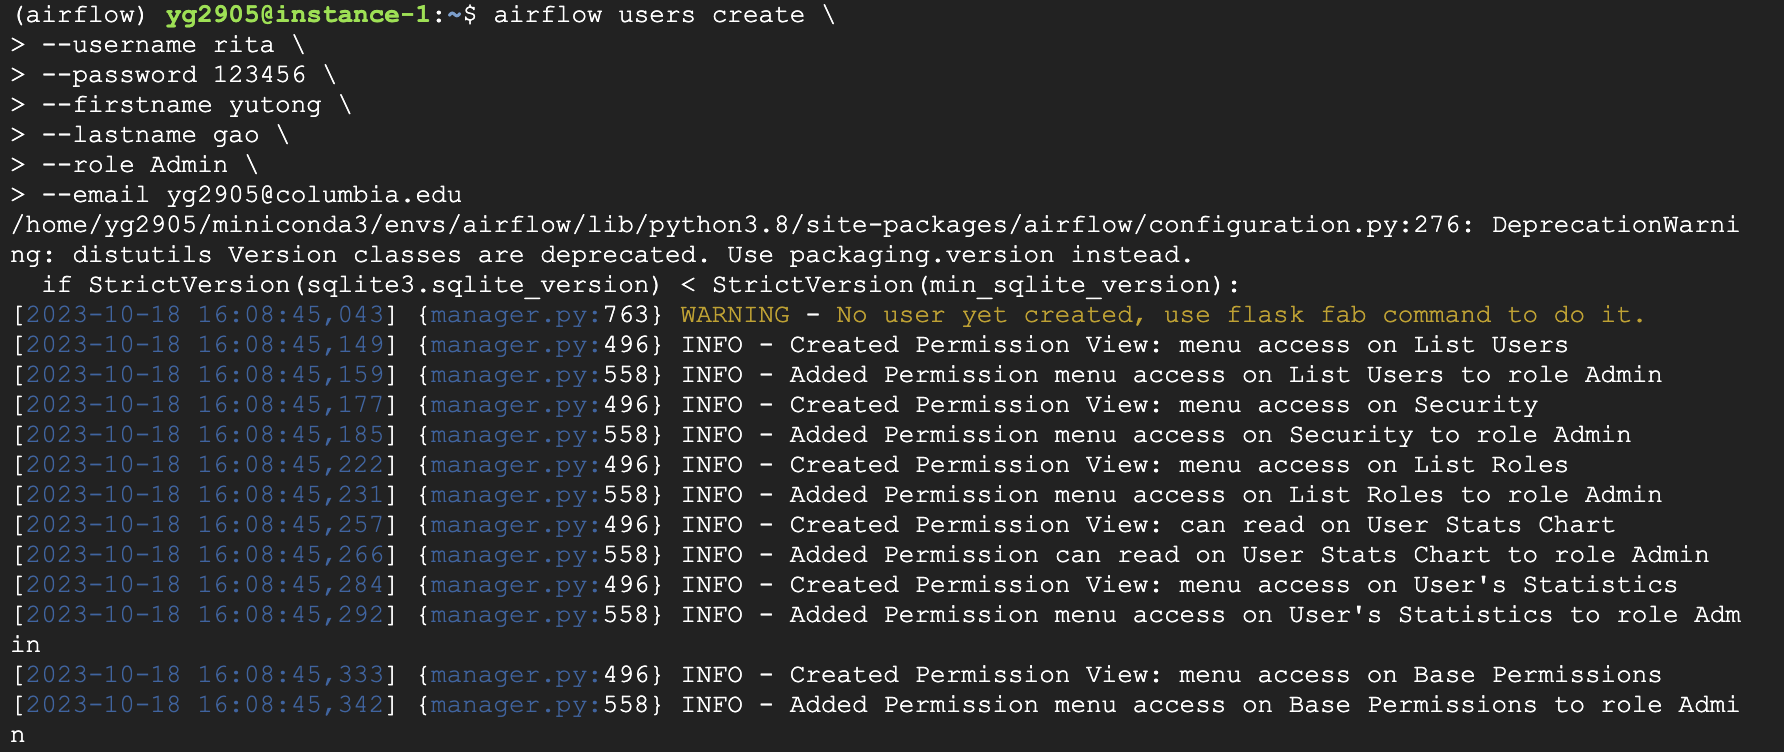
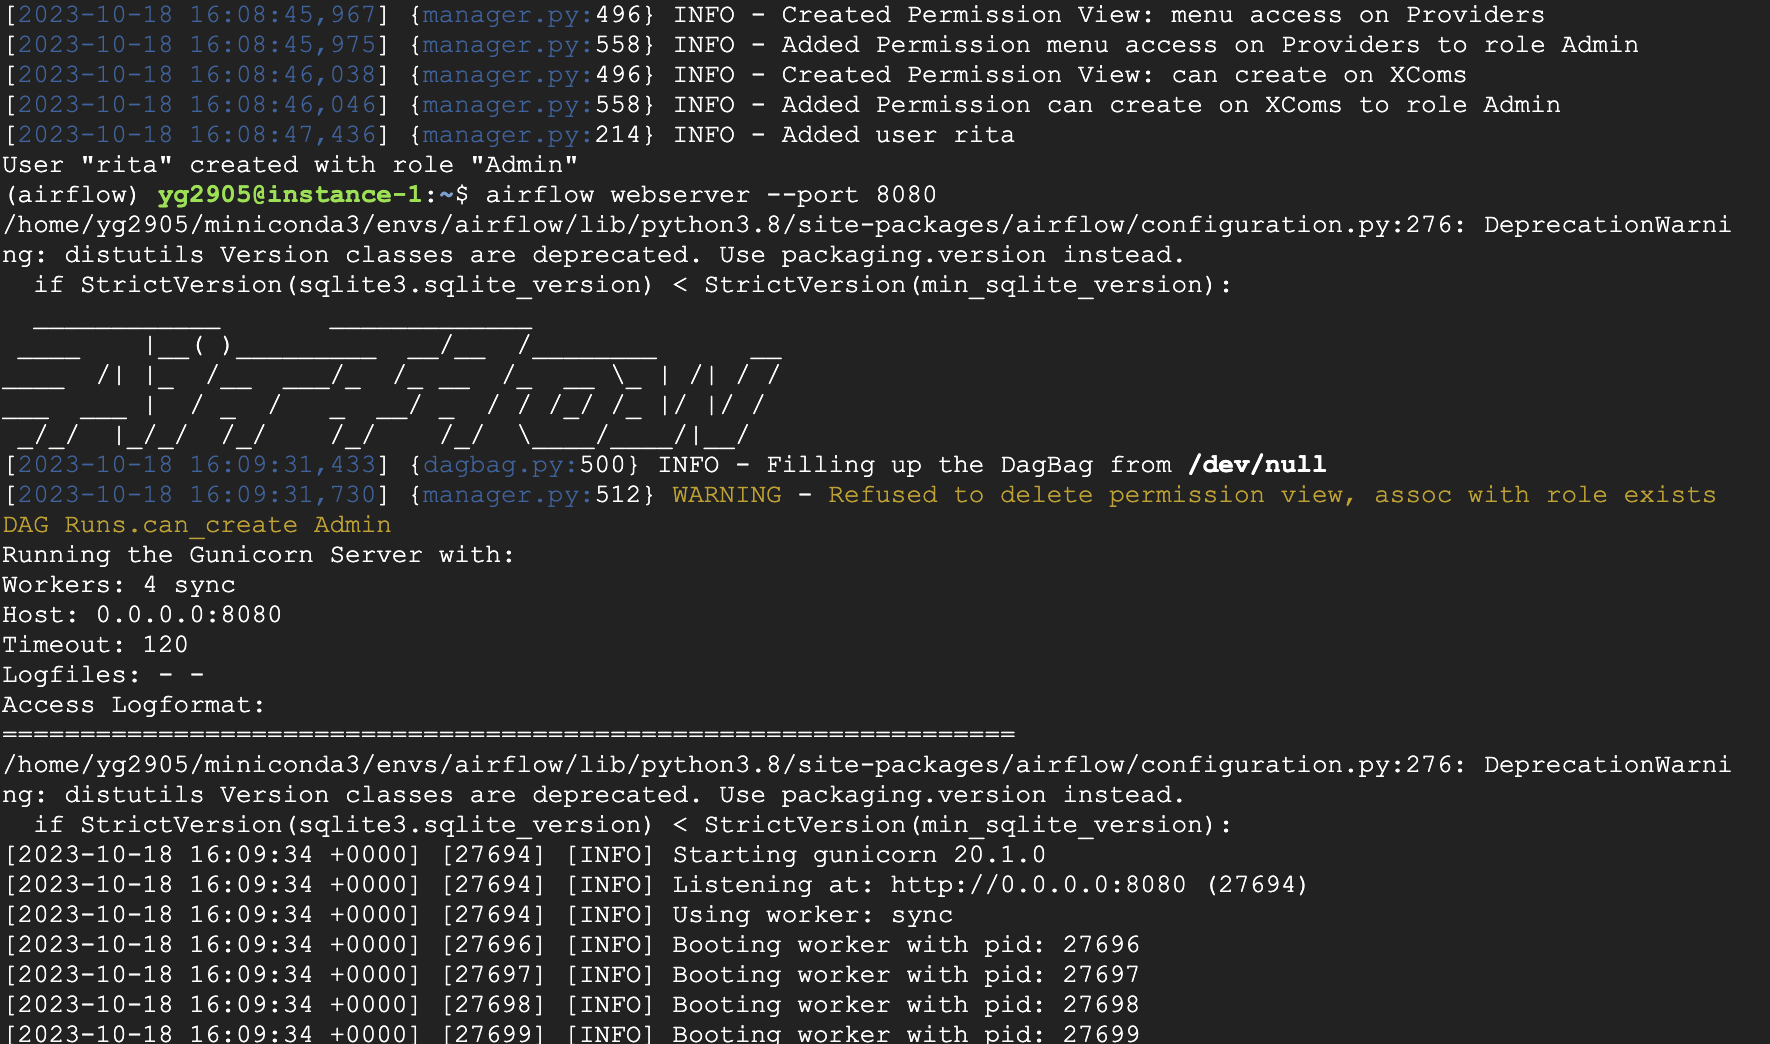
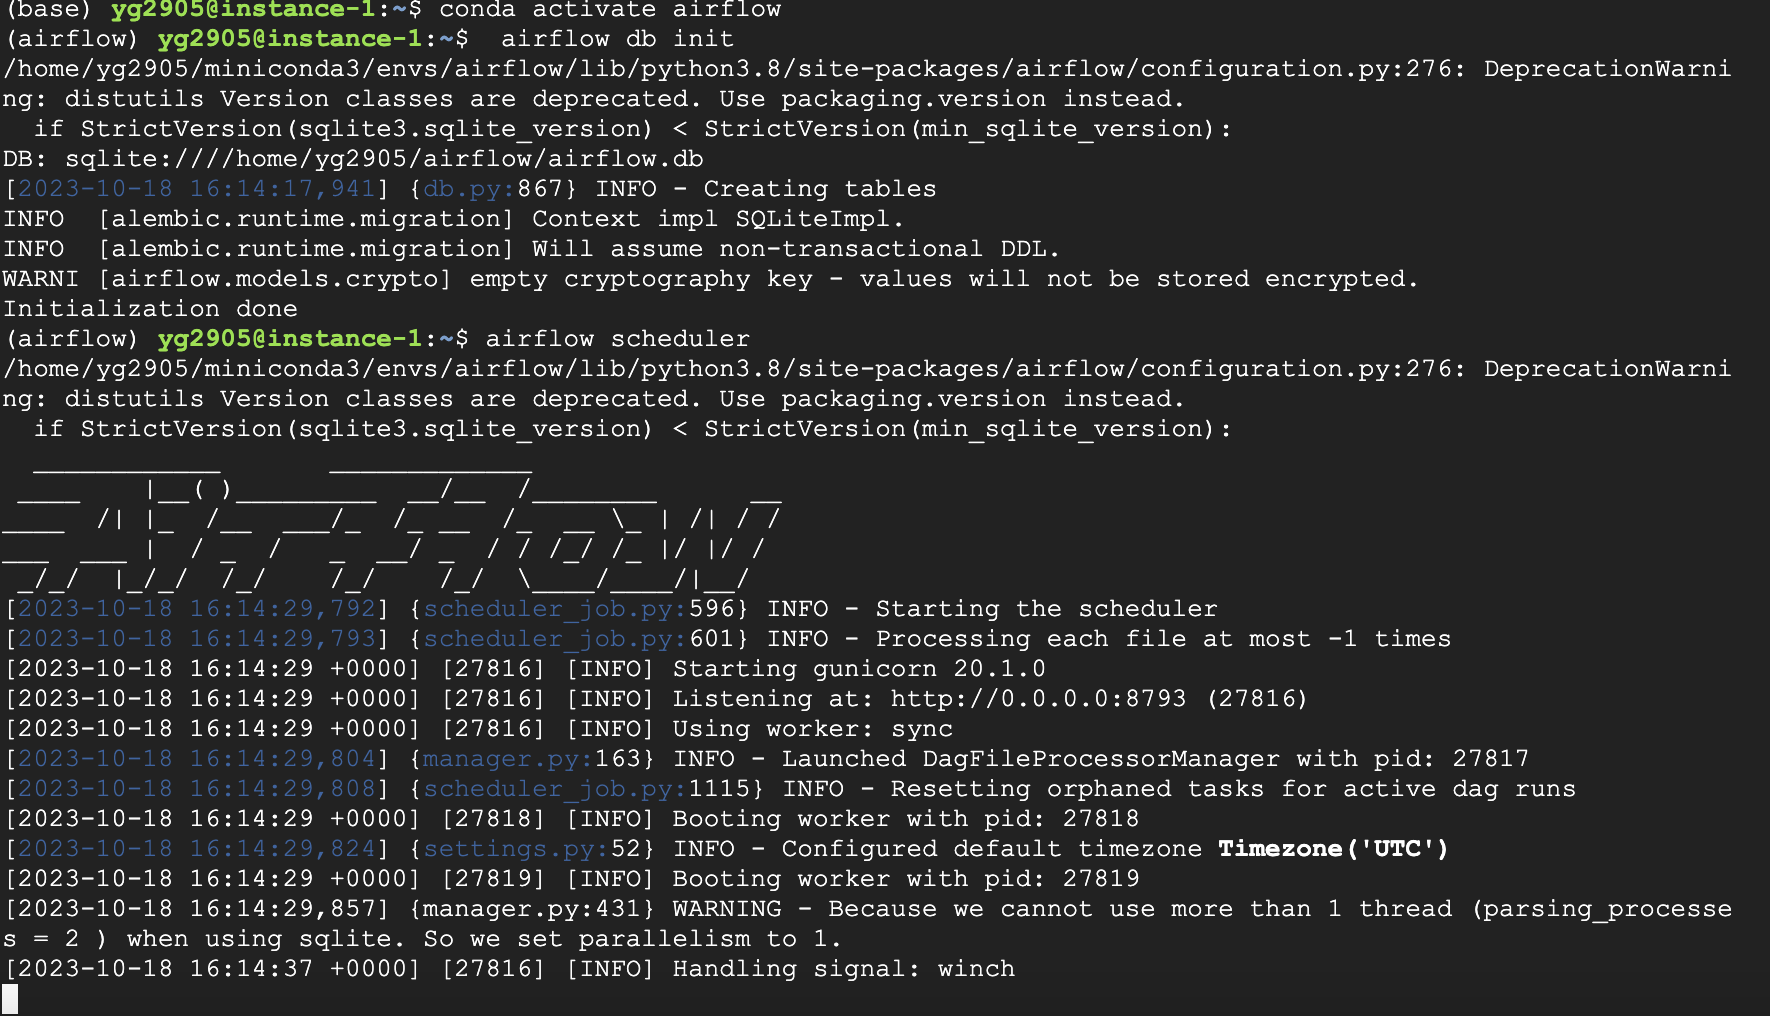

**(2) Provide screenshots of the web browser after you successfully login and see the DAGs.**

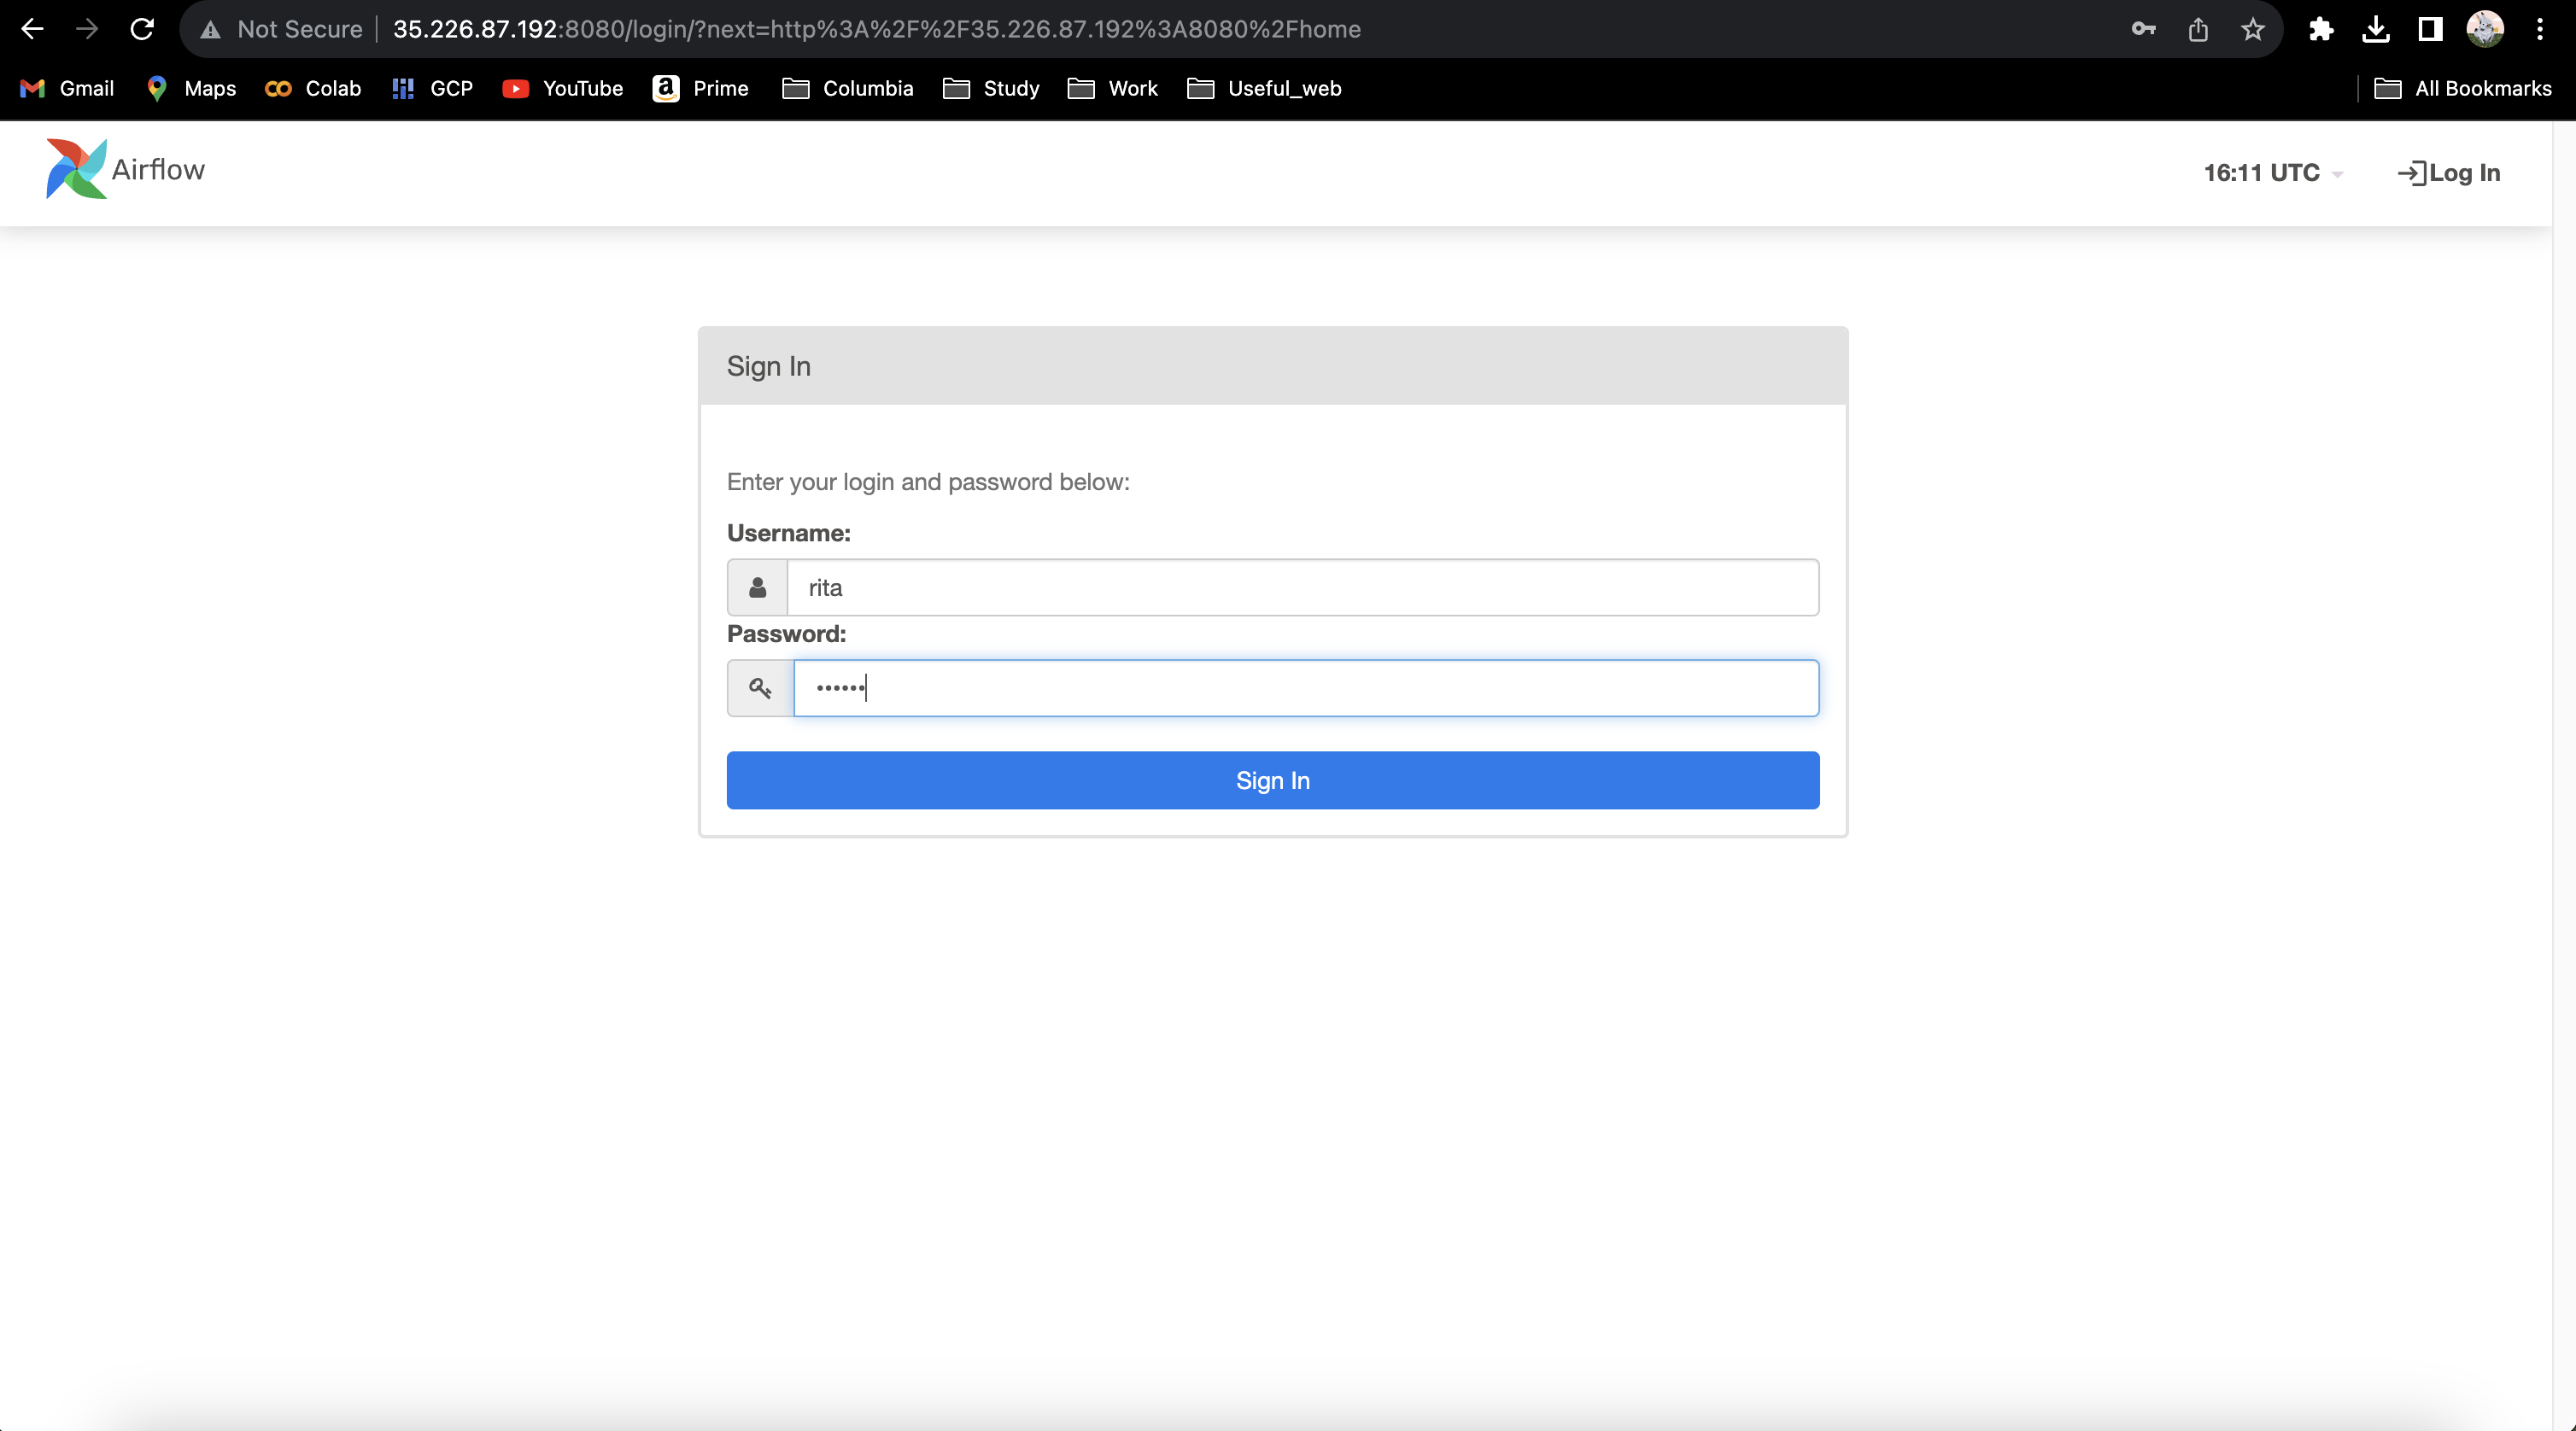
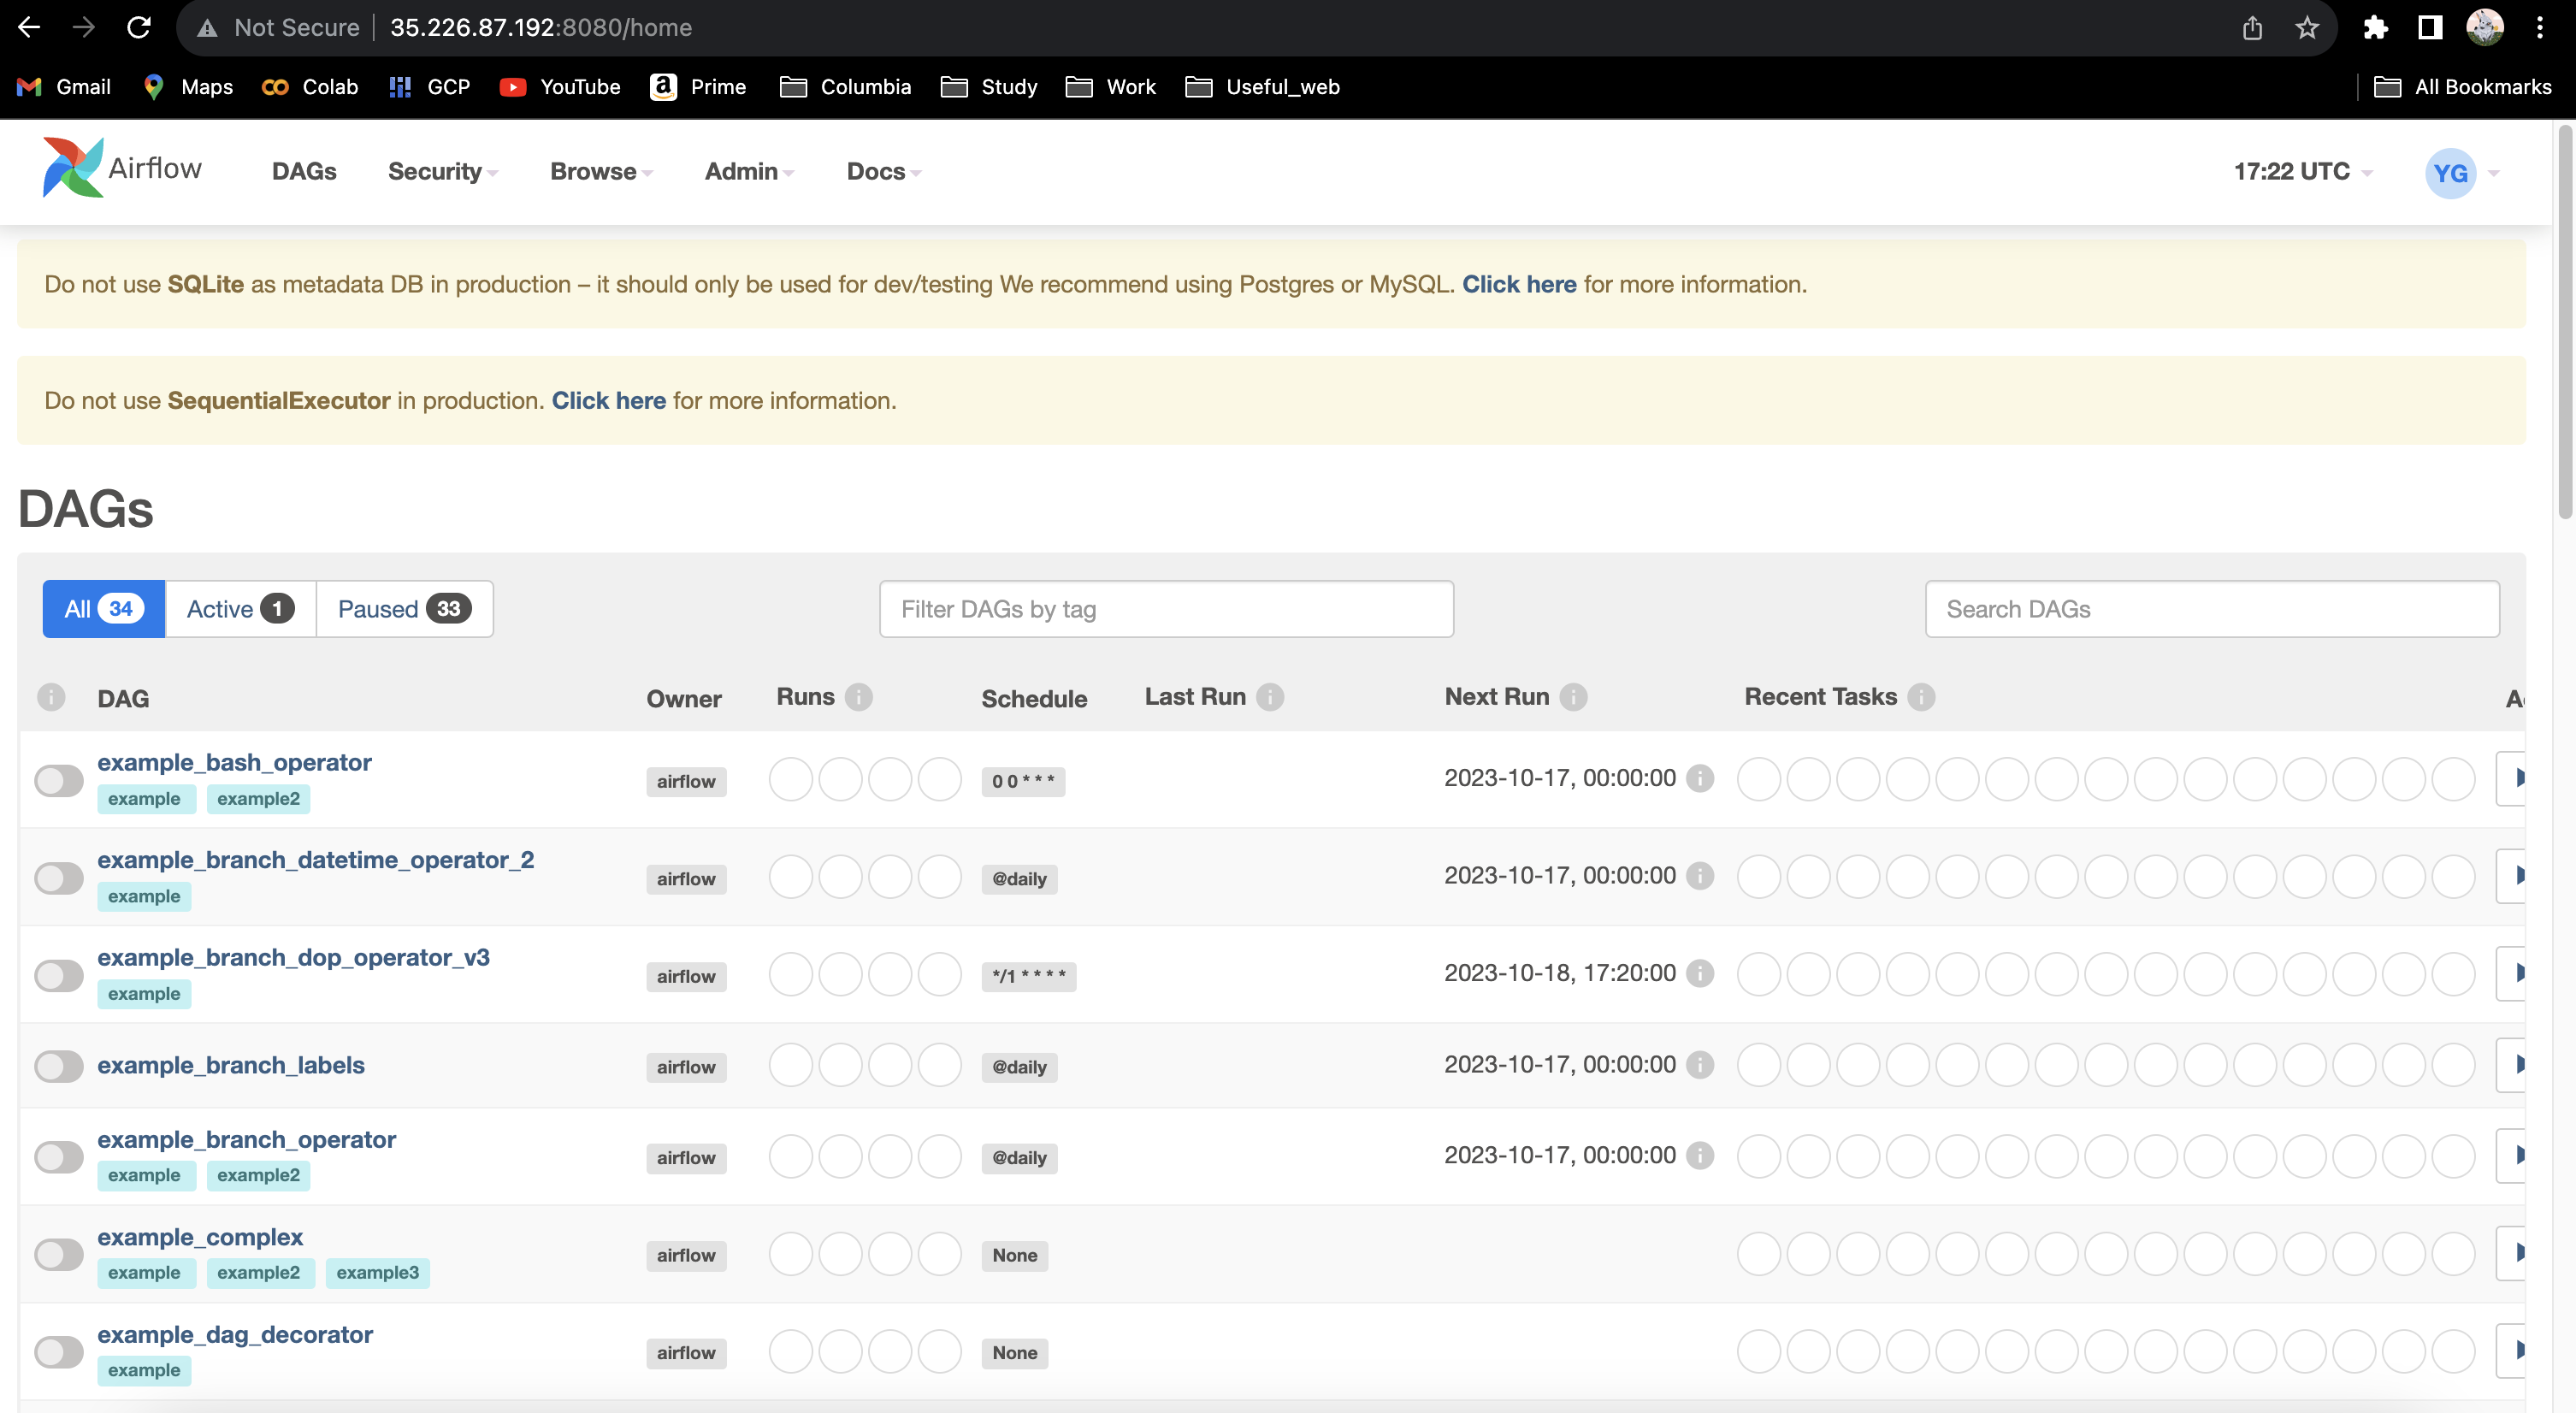

### Q1.2 Run helloworld with SequentialExecutor

**(1) Provide screenshots of Tree, Graph, and Gantt charts after execution.**

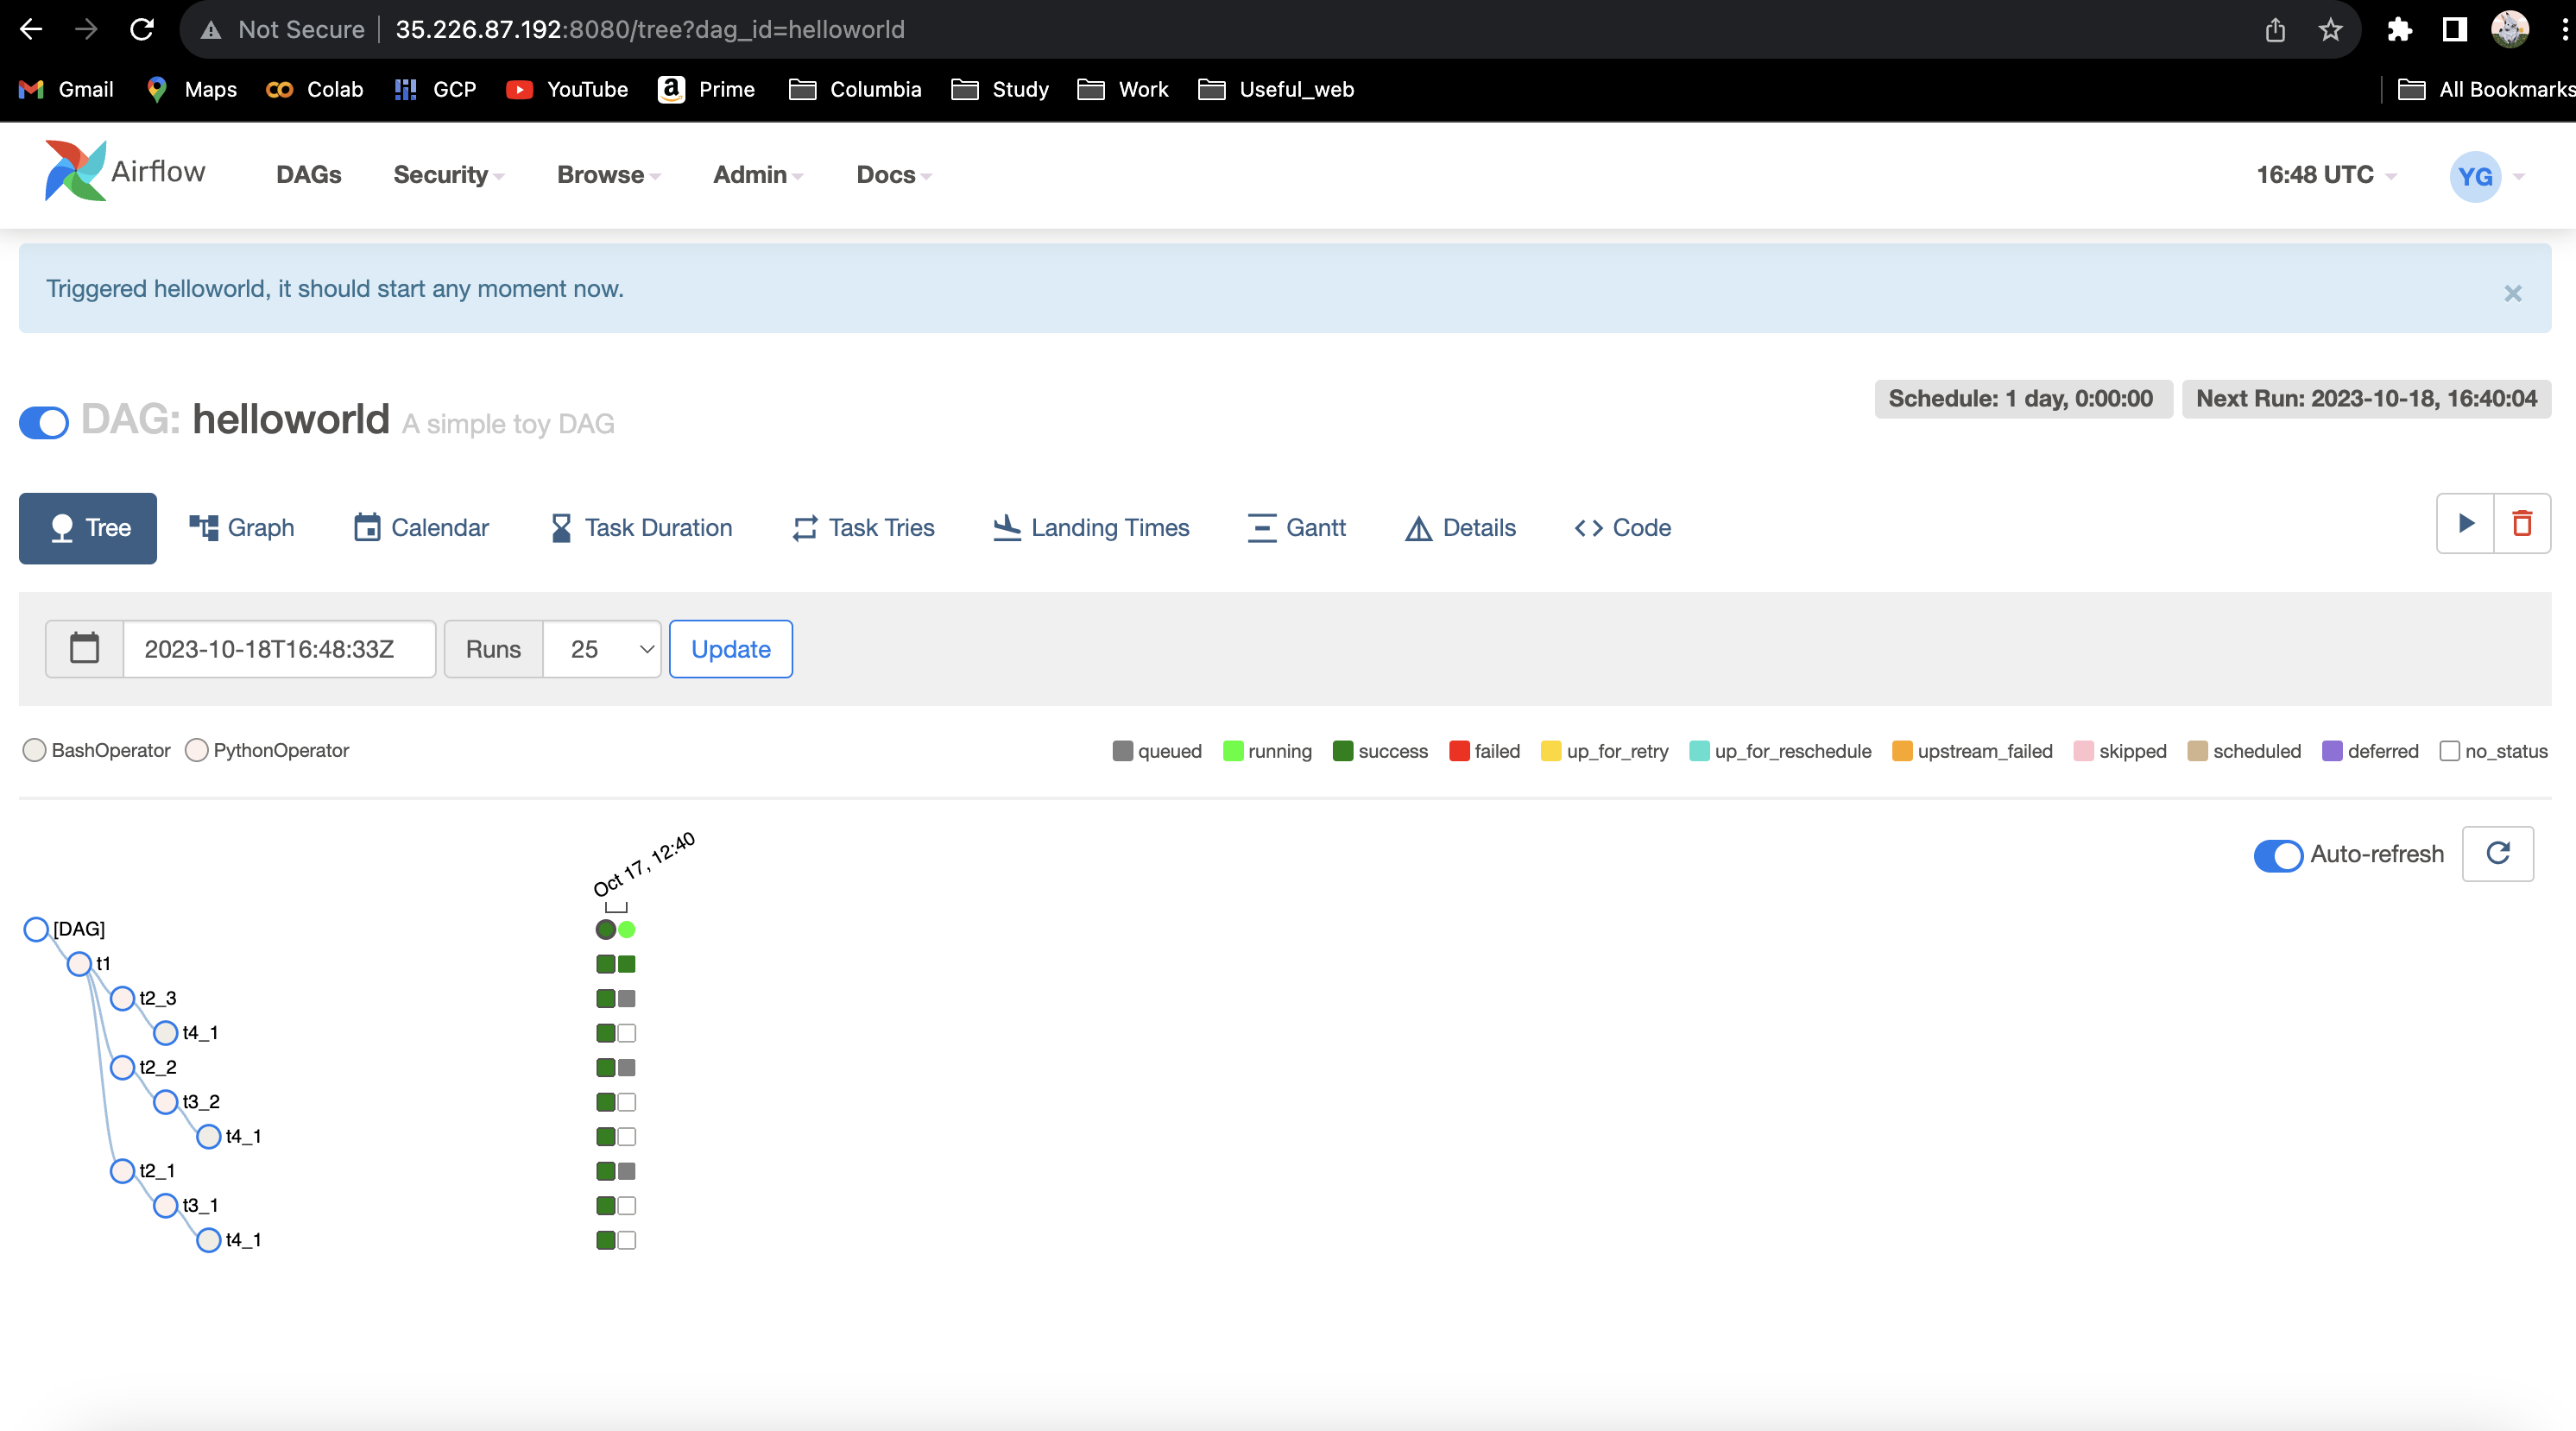
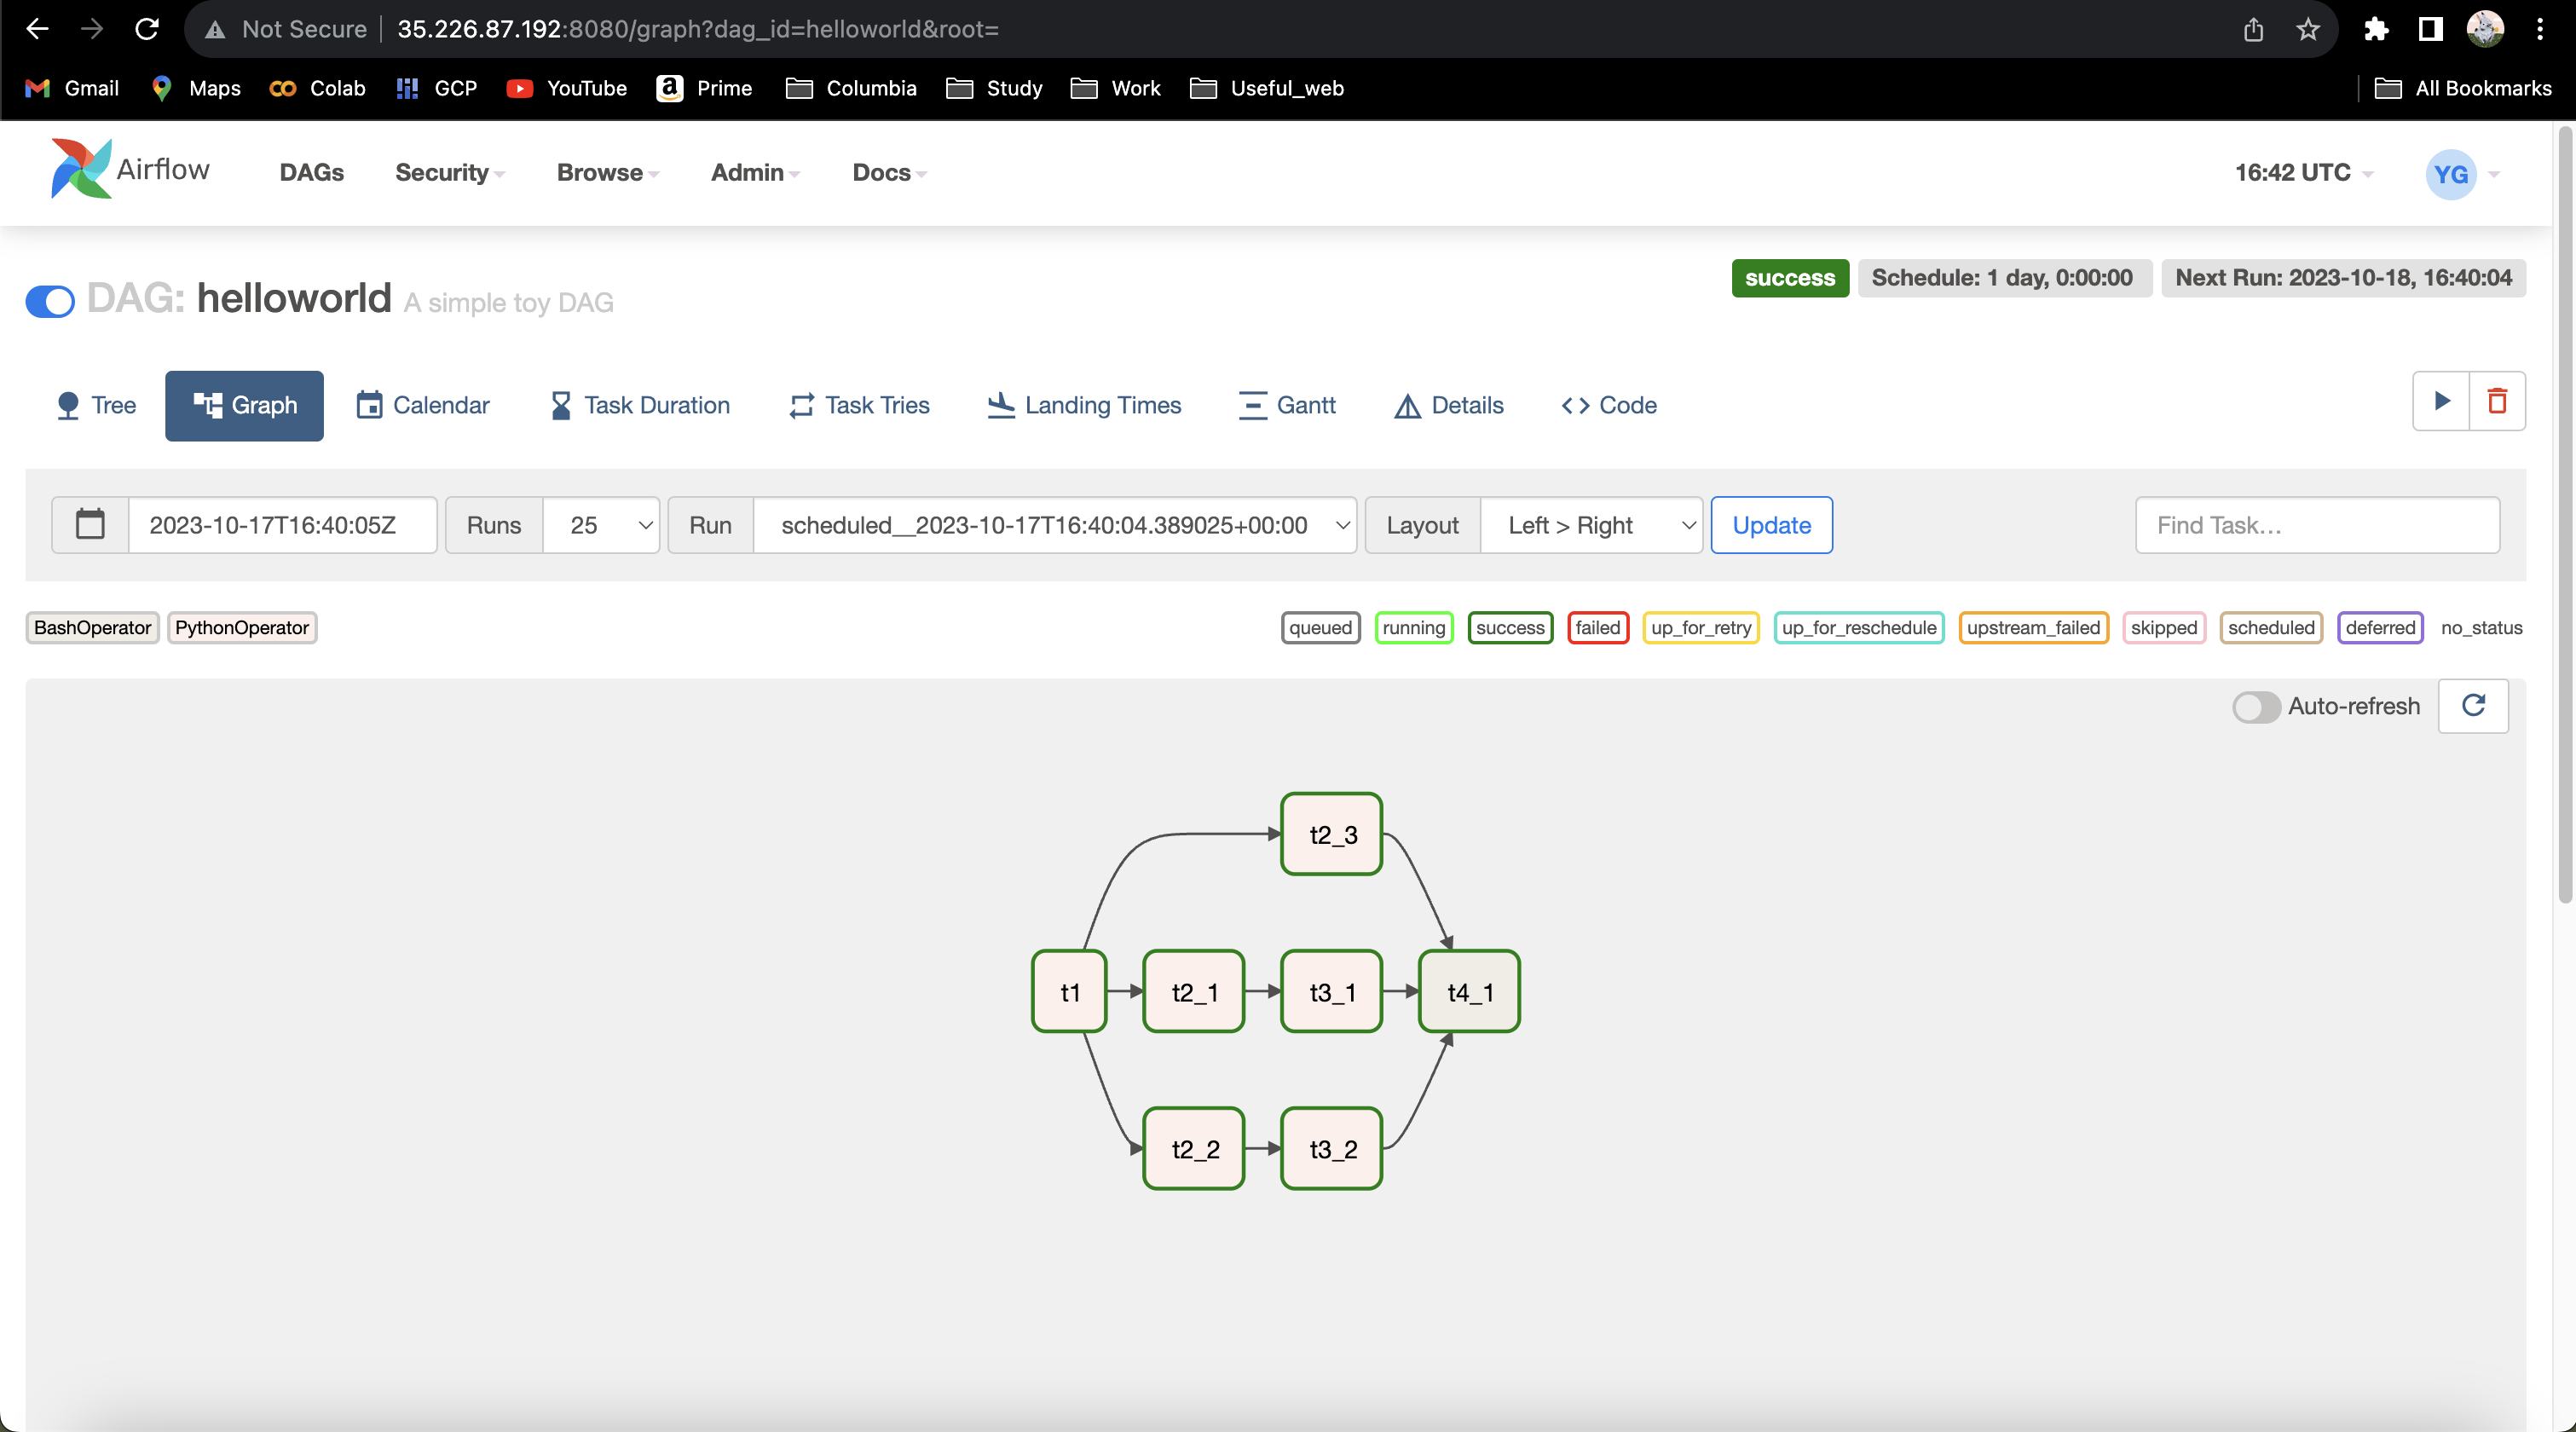
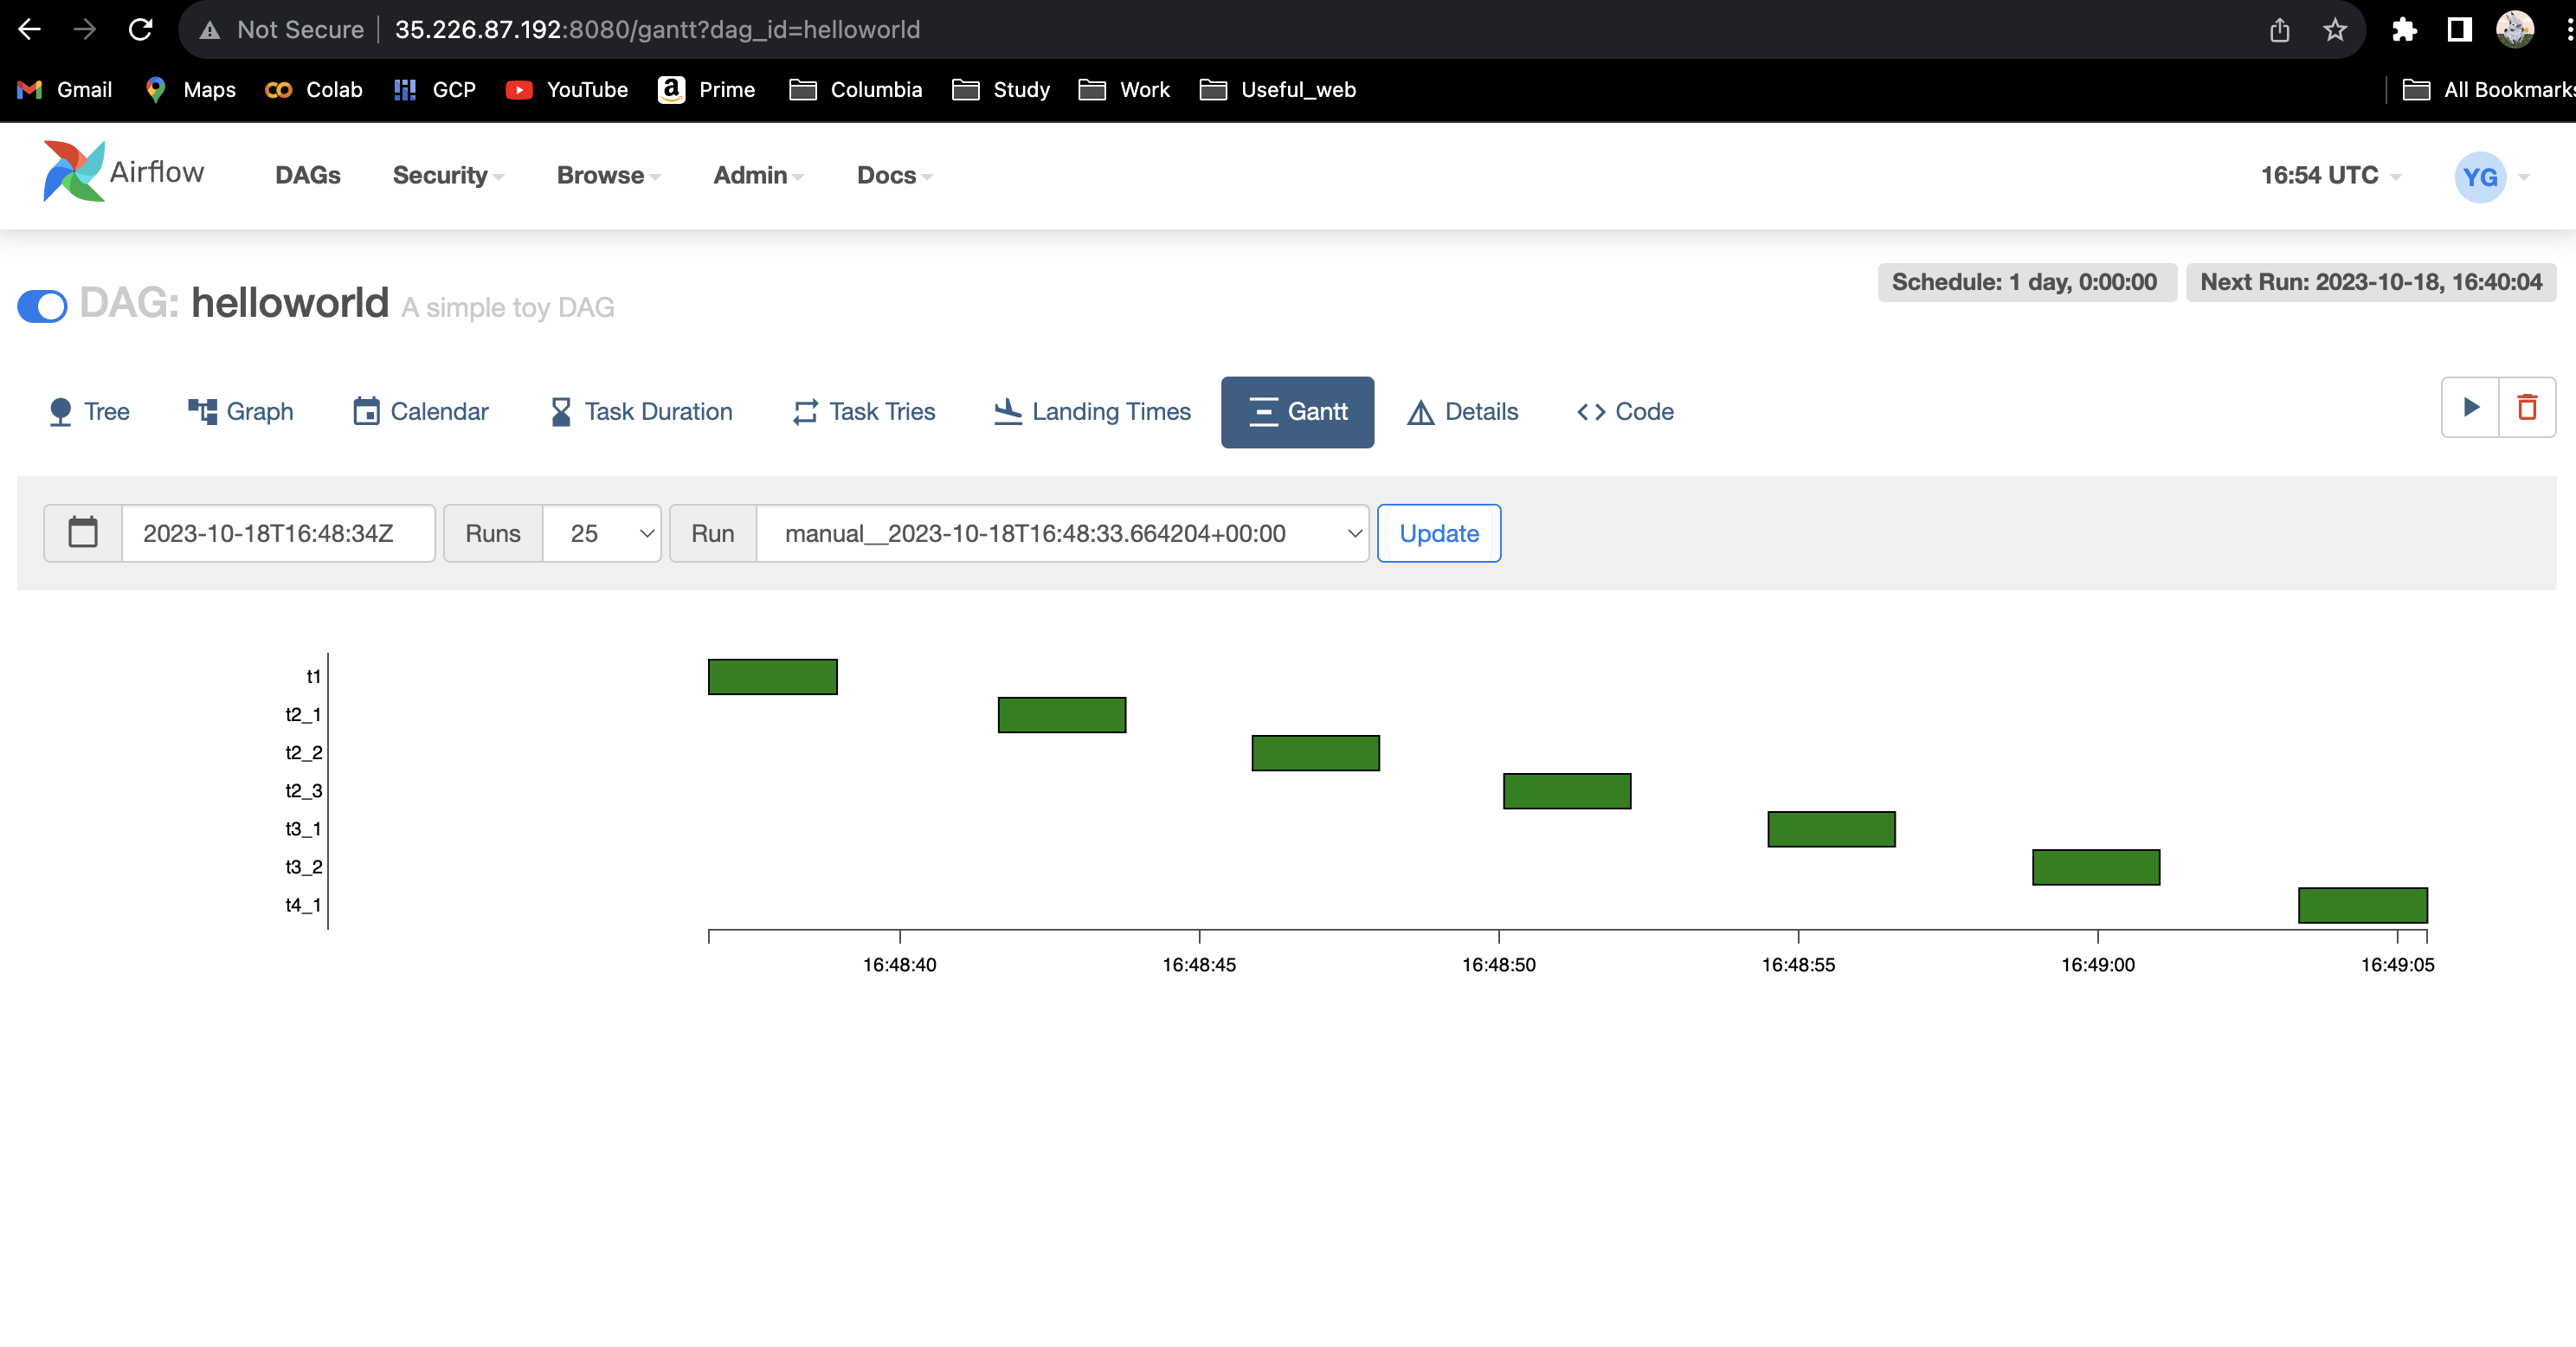

**(2) Explore other features and visualizations you can find in the Airflow UI. Choose two features/visualizations (other than tree, graph, and Gantt), explain their functions and how they help monitor and troubleshoot the pipeline, use helloword as an example. (5 pts)**

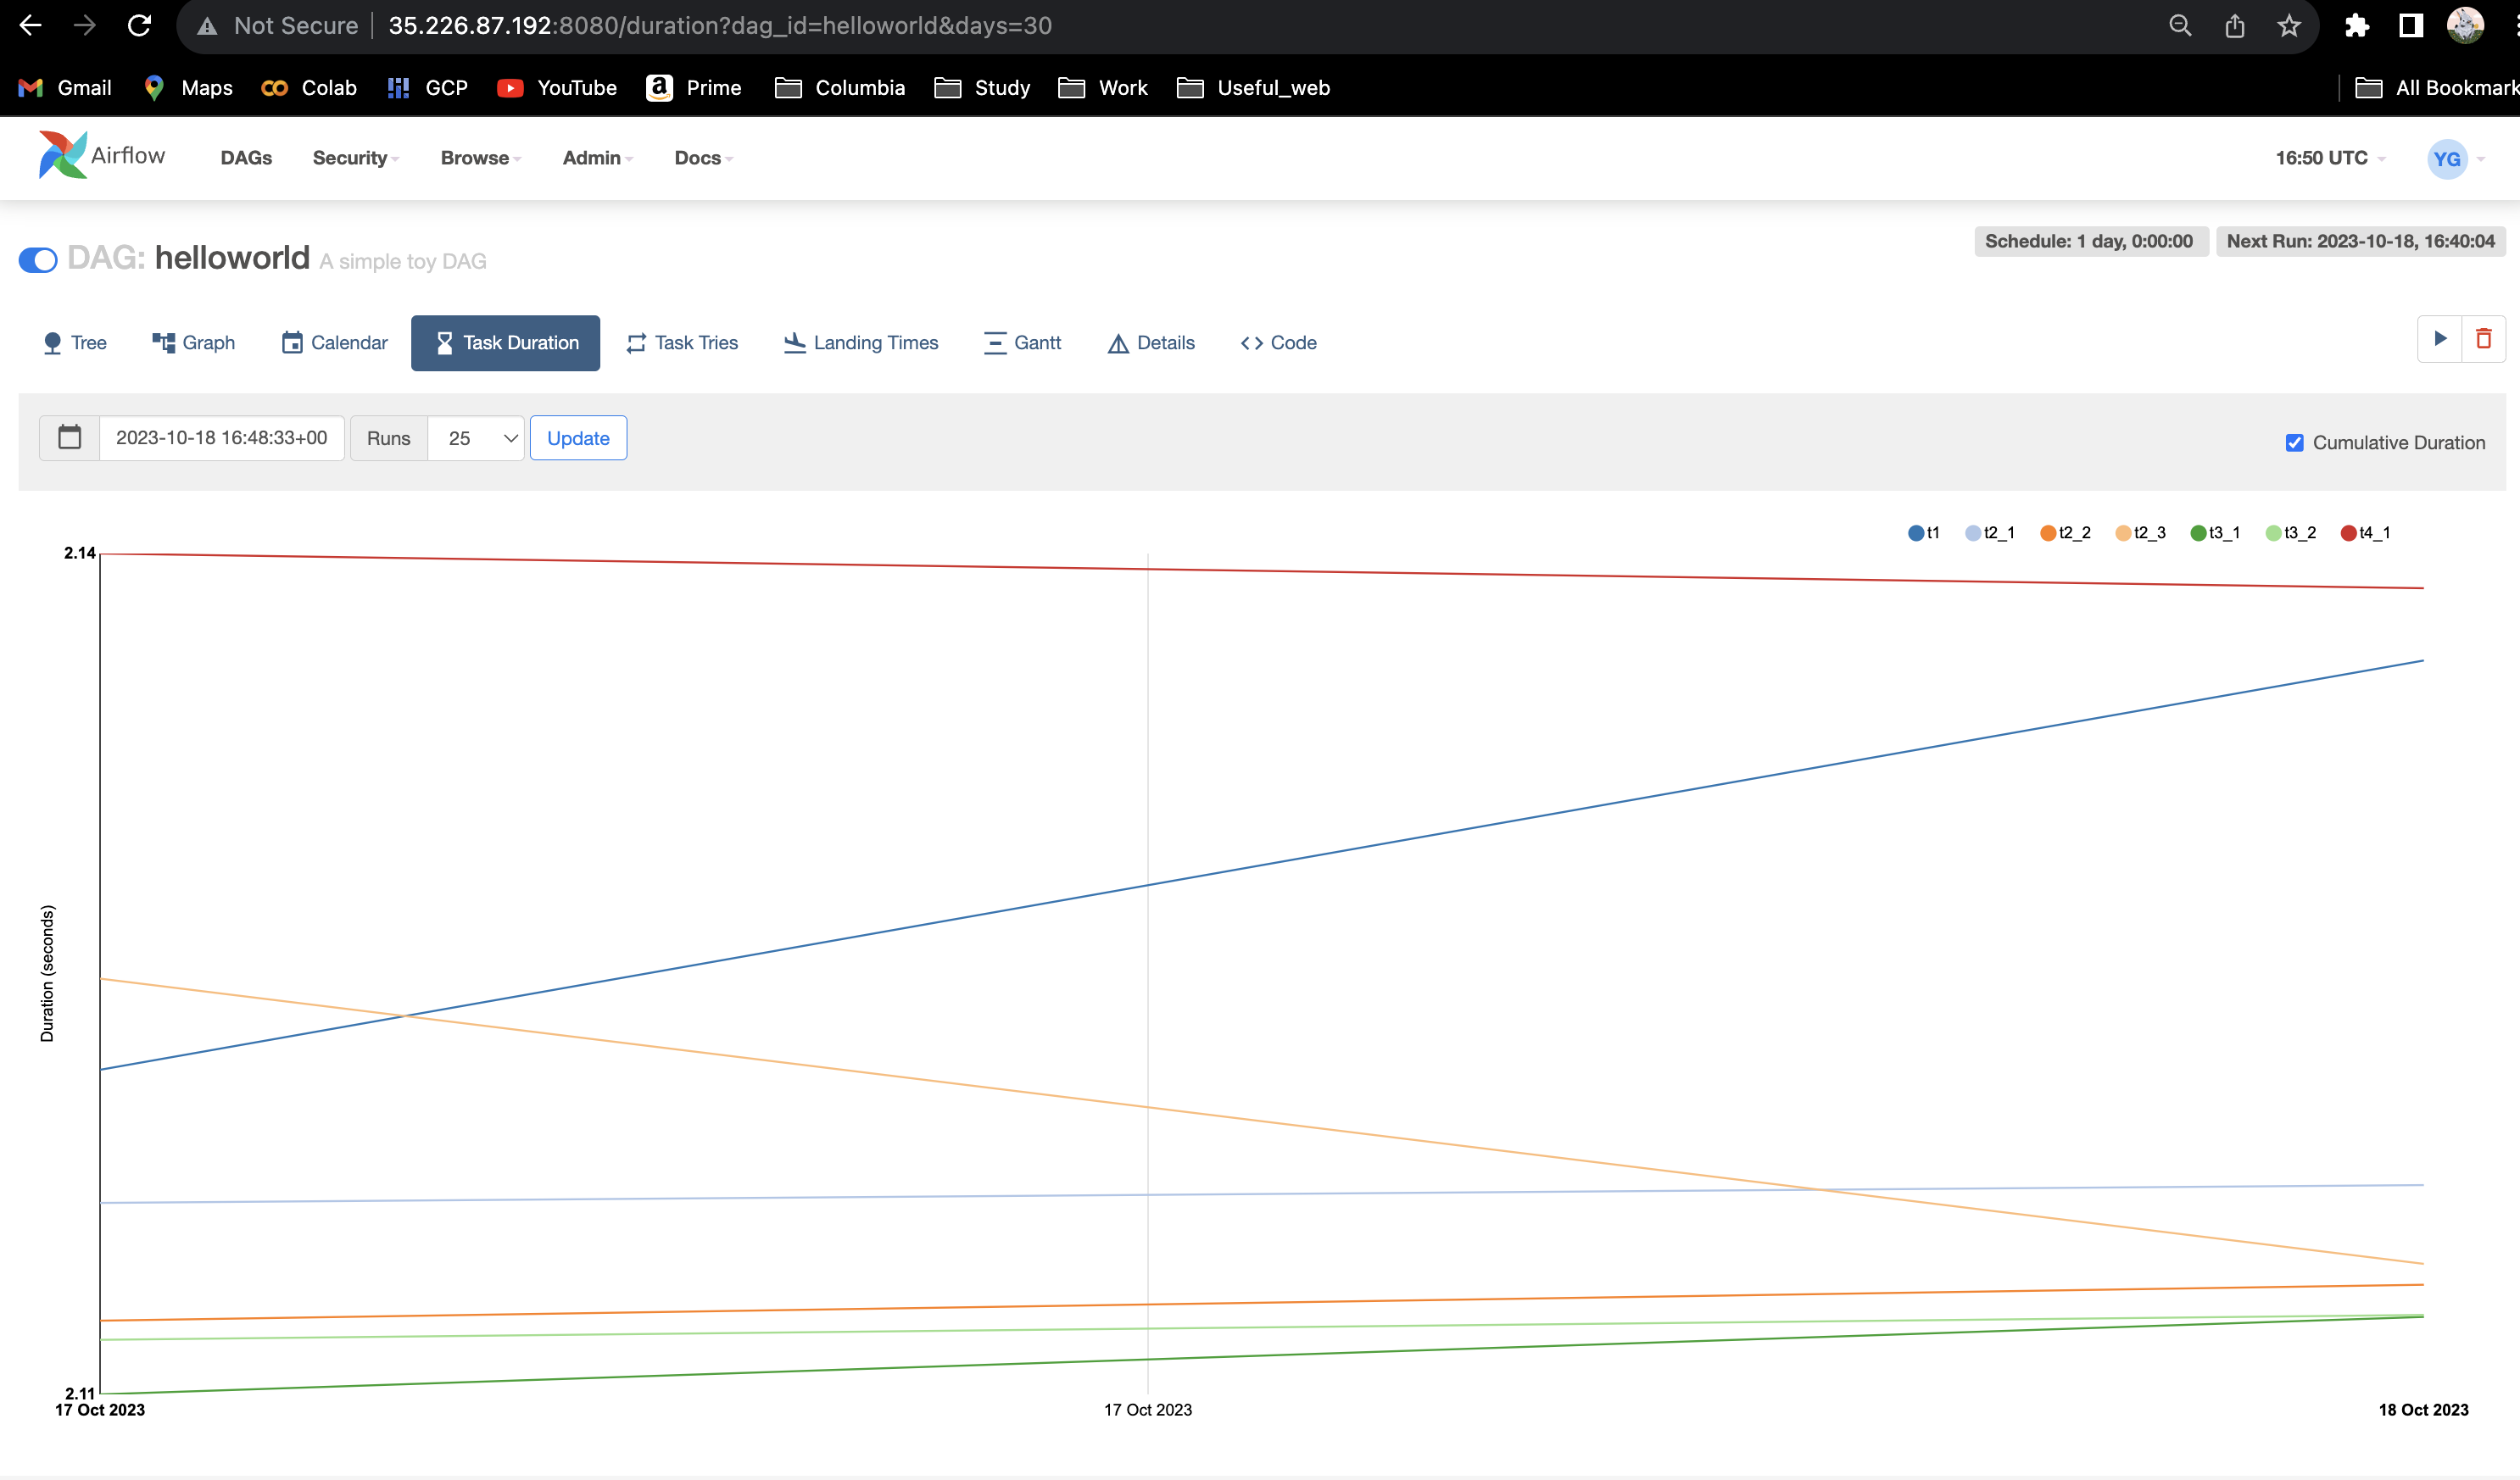
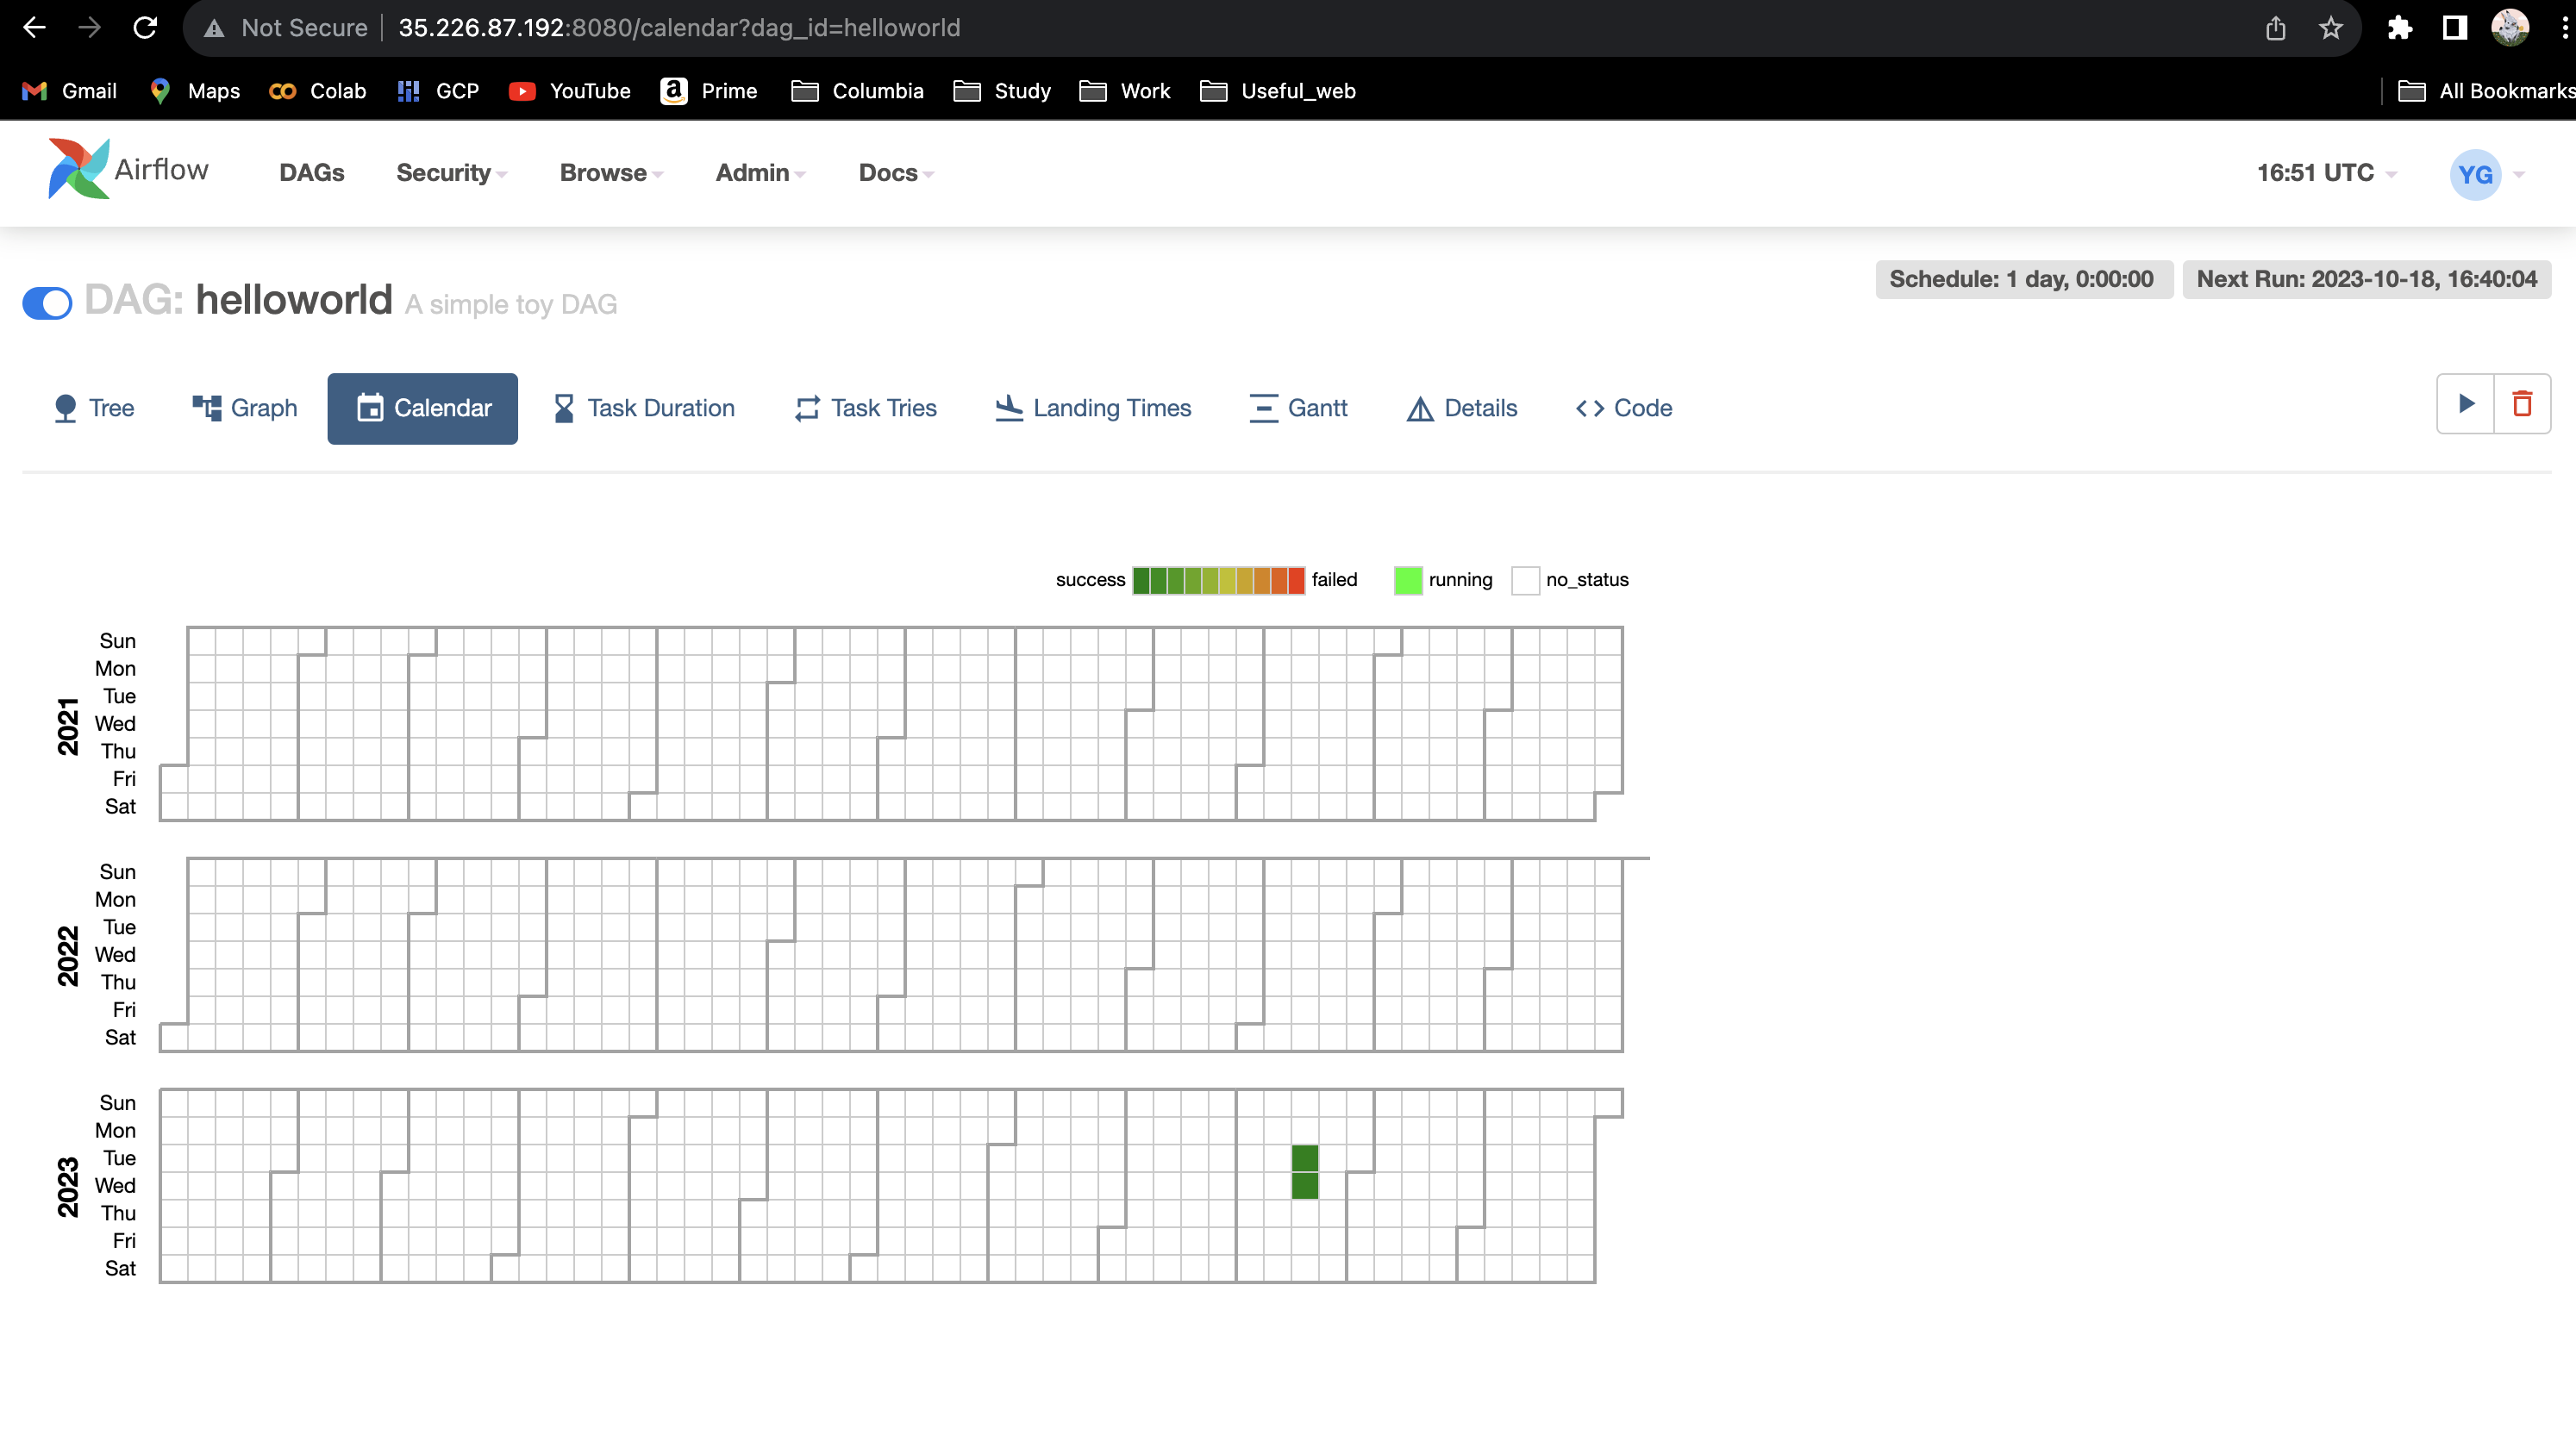

1. Task Duration
- Function: Task Duration visualizes how long each task takes to execute.
- Monitoring and Troubleshooting: It helps identify performance bottlenecks, optimize resource allocation, and spot delays in task execution in the pipeline. In "helloworld" example, if a task that simply prints "Hello, World!" takes significantly longer to complete, it may indicate a problem that needs attention, such as resource constraints or misconfigurations.
2. Calendar
- Function: Calendar displays a visual schedule of when tasks run and their status.
- Monitoring and Troubleshooting: It offers insights into the temporal aspects of your pipeline, helps track scheduling issues, and reveals historical trends in task execution for better monitoring and troubleshooting. In "helloworld" example, you can see when the "Hello, World!" task was executed, whether it adhered to the schedule, and whether any failures occurred.

## Task 2 Build workflows 

### Q2.1 Implement the DAG below 

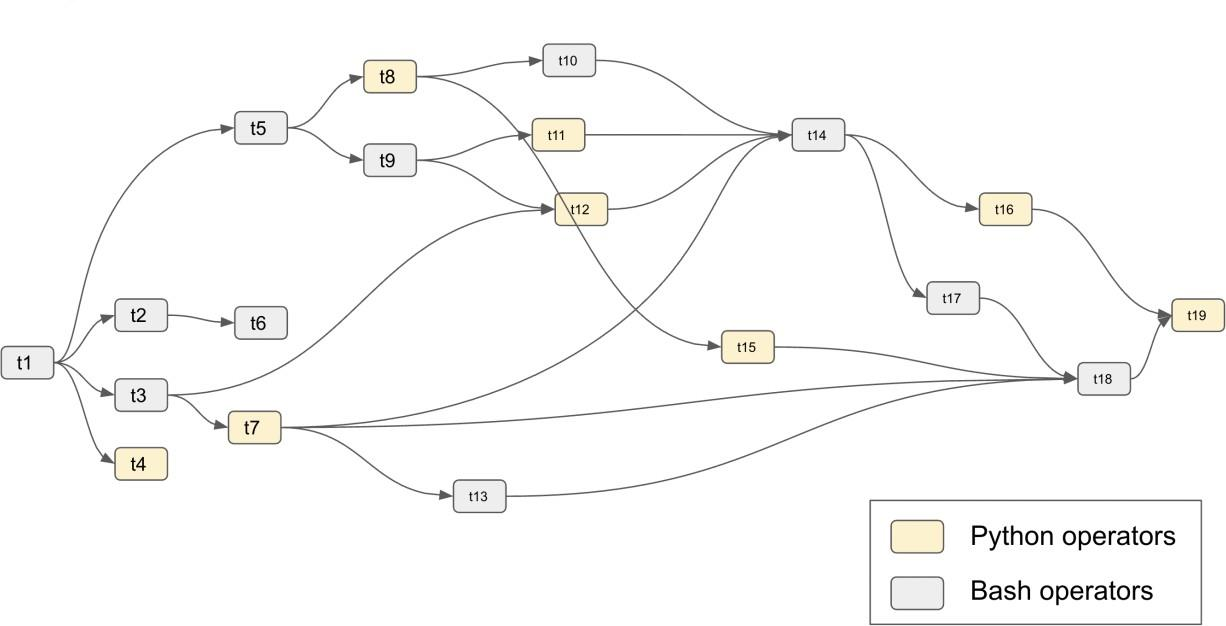

For each kind of operator, use at least 3 different commands. For example, you can choose sleep, print, 
count functions for Python operators, and echo, run bash script, run python file for Bash operators.

**(1) Provide screenshots of Tree and Graph in airflow.**


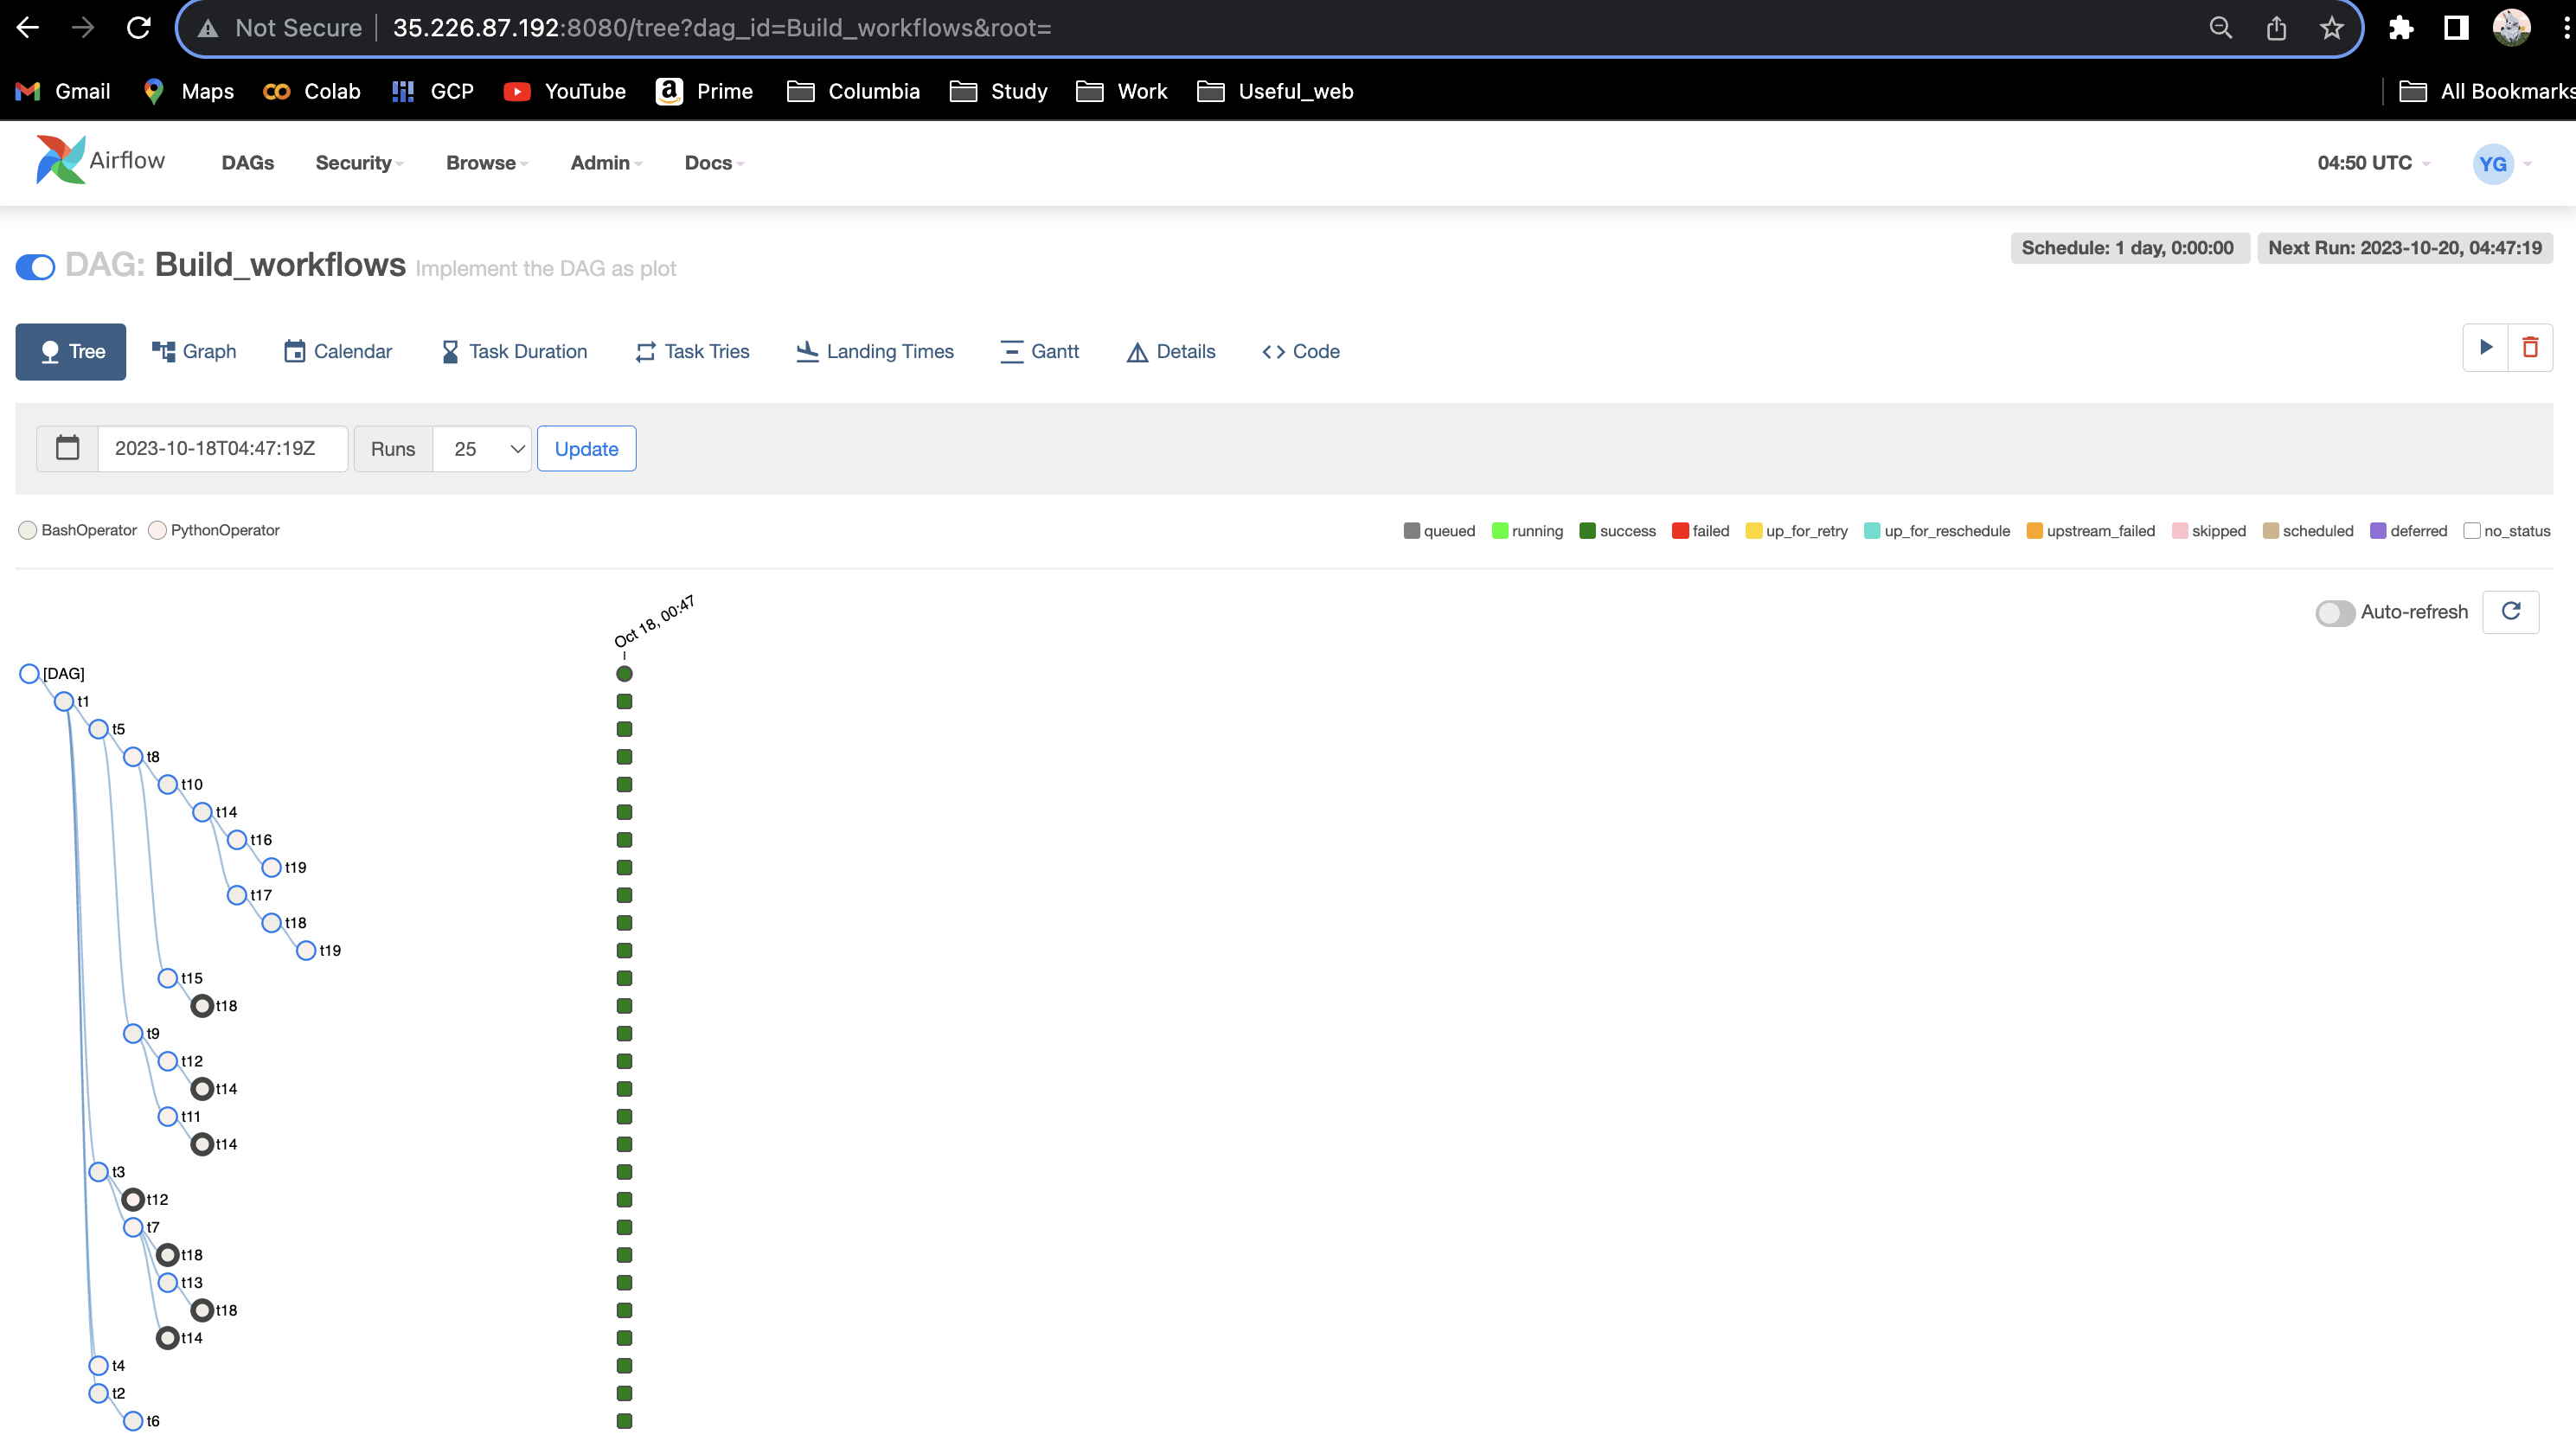
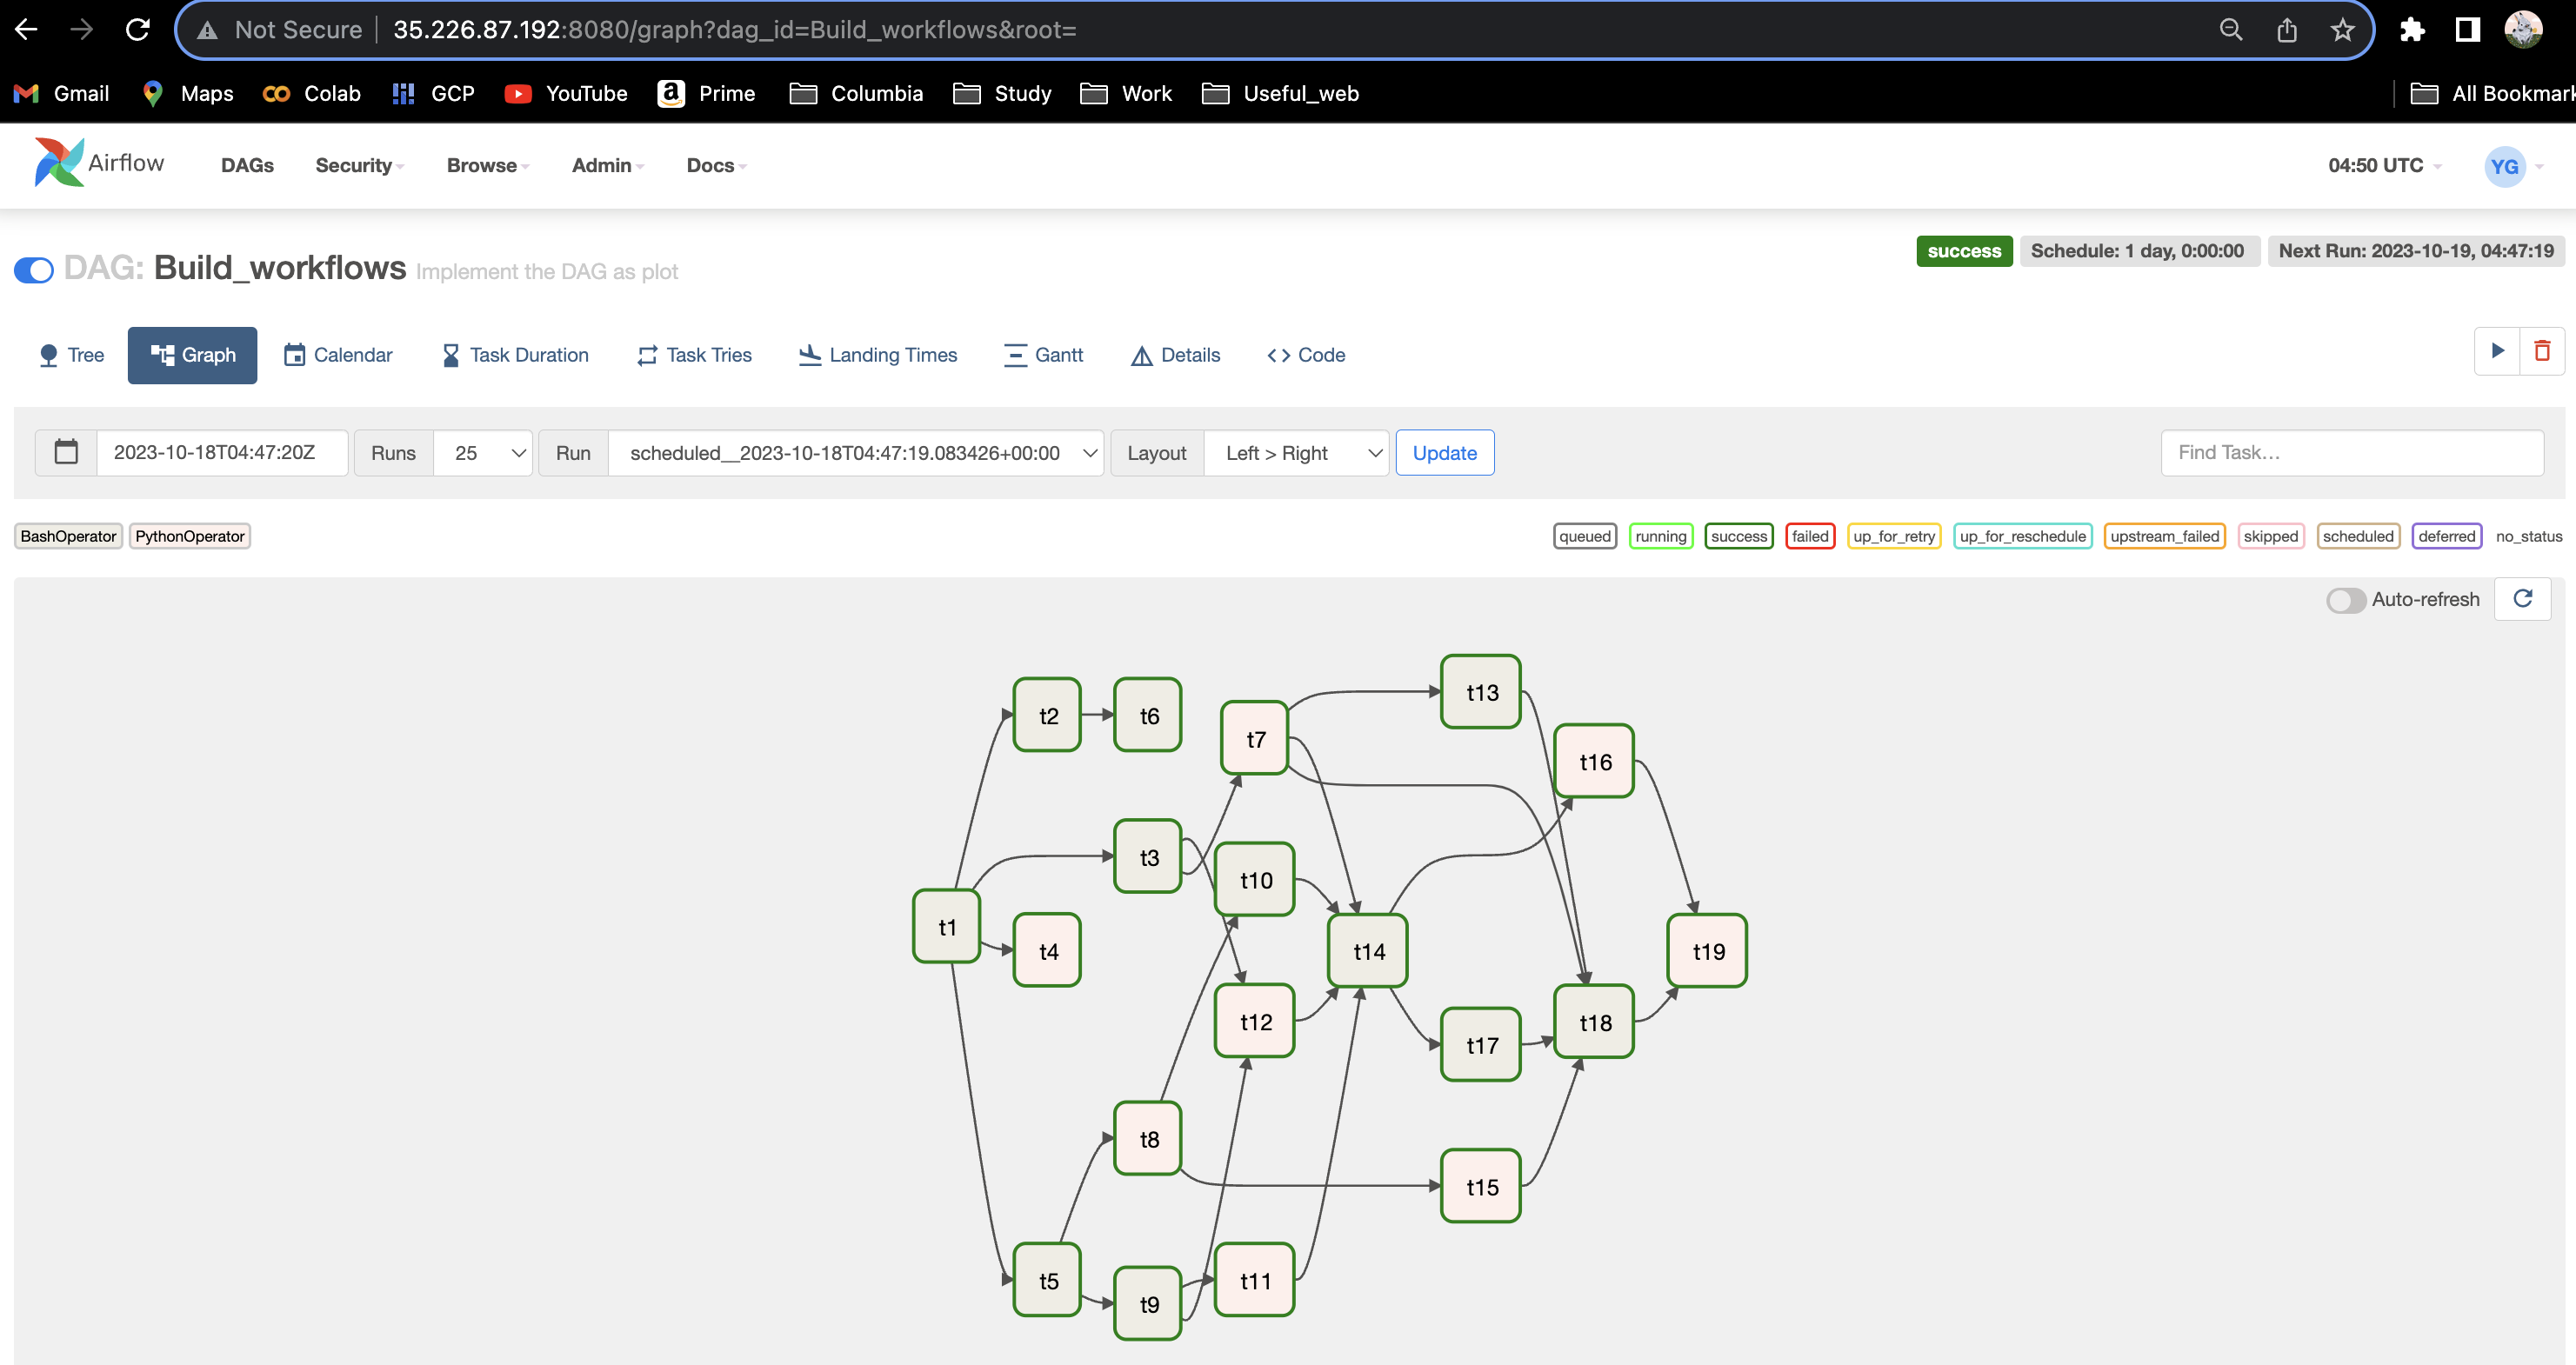

**(2) Manually trigger the DAG and provide screenshots of Gantt.**

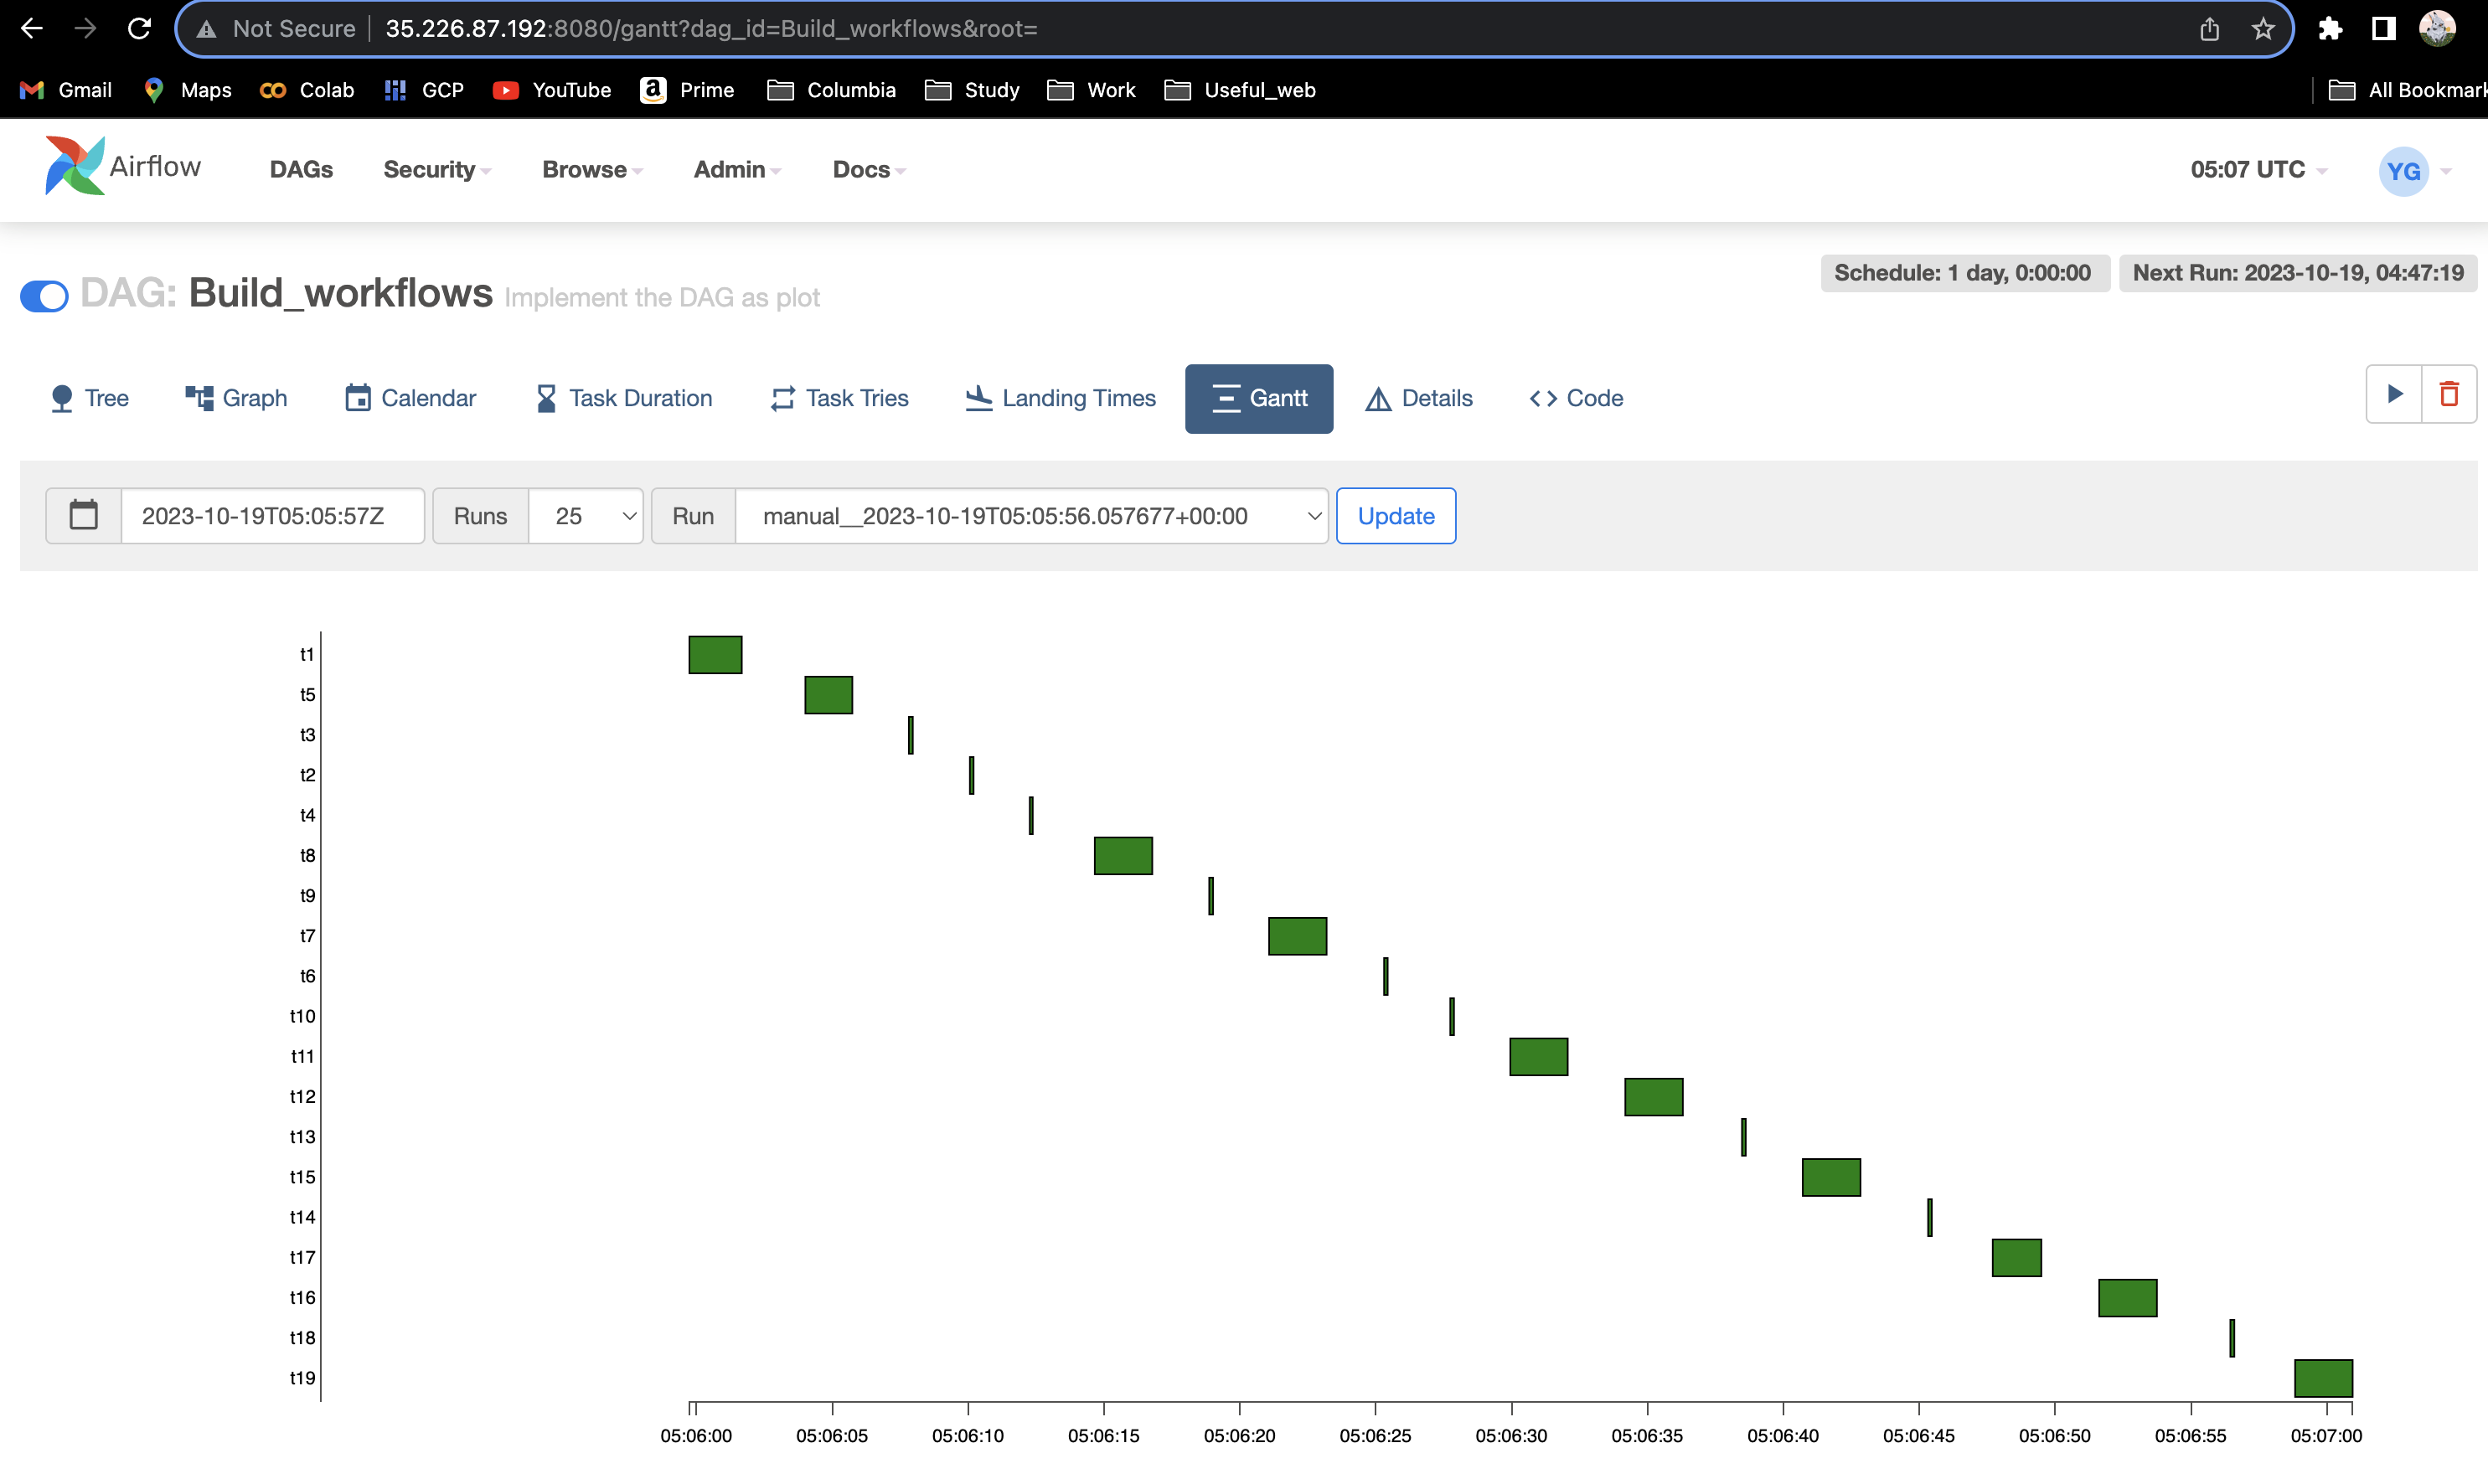

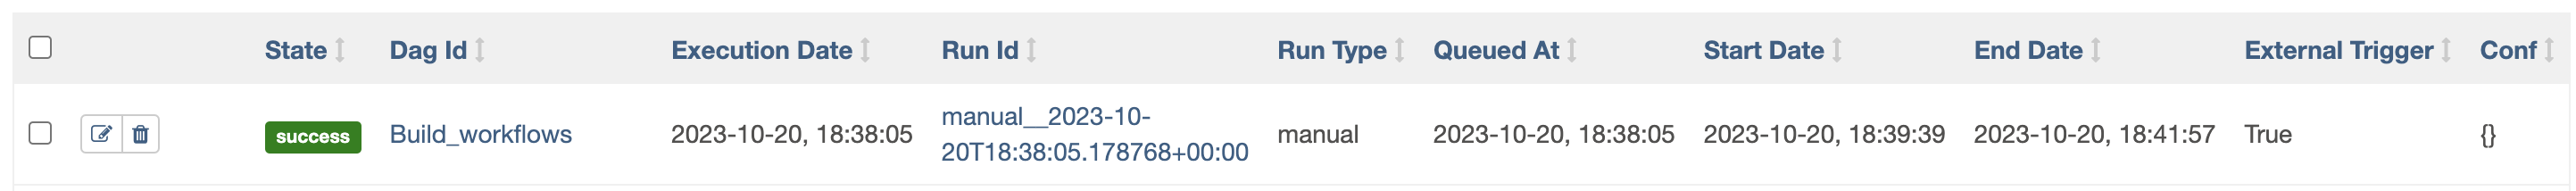

**(3) Schedule the first run immediately and then schedule running the program every 30 minutes. Describe how you decide the start date and schedule interval. Provide screenshots of running history after two repeats (first run + 2 repeats). On your browser, you can find the running history.**

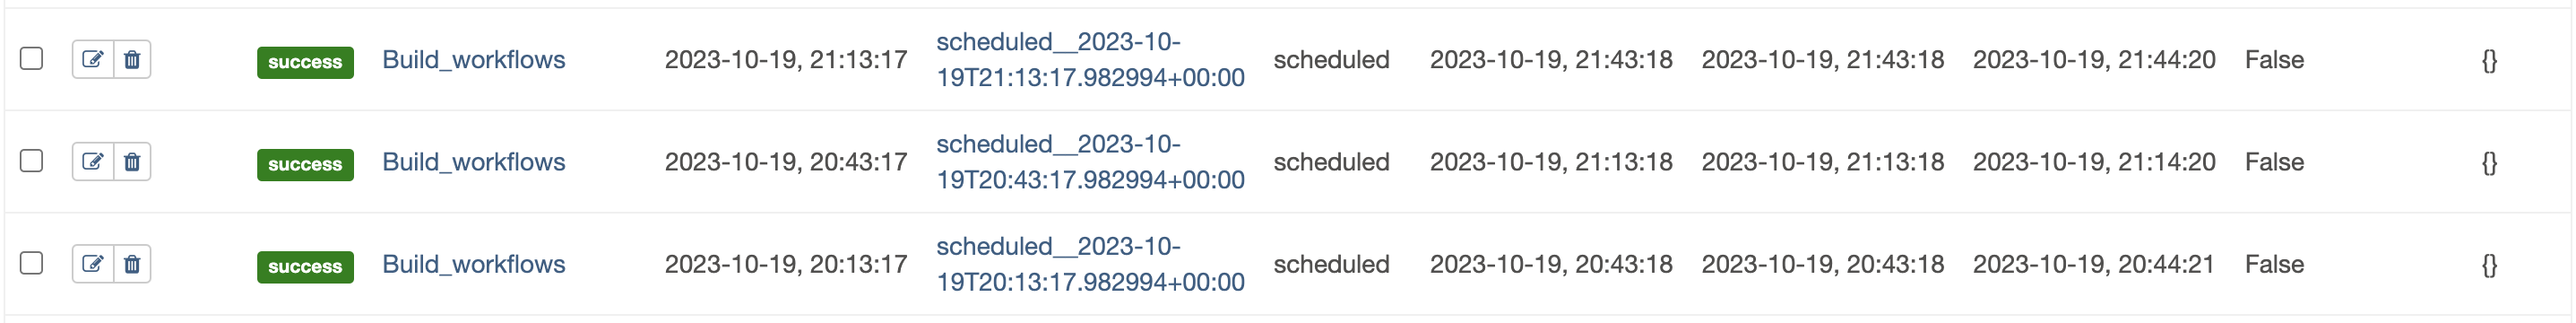

- Start Date Decision: The start date is set to the current date and time using datetime.now(). This decision means that the DAG will commence its first run immediately upon definition. 
- Schedule Interval Decision: The schedule interval is set to timedelta(seconds=1800), which equals 30 minutes, ensuring that data processing occurs frequently and near real-time.

In [ ]:
from datetime import datetime, timedelta
from textwrap import dedent
import time
from airflow import DAG
from airflow.operators.bash import BashOperator
from airflow.operators.python import PythonOperator

count = 0

# Python operators functions
def correct_sleeping_function():
    time.sleep(2)

def count_function():
    global count
    count += 1
    print('count_increase output: {}'.format(count))
    time.sleep(2)

def print_hello_world():
    print("Hello, World!")

def echo_function(message):
    return 'echo "{}"'.format(message)

def run_bash_script():
    bash_command = "echo 'Executing a Bash script'"
    return bash_command

def run_python_file():
    python_command = "python /home/yg2905/airflow/dags/helloworld.py"
    return python_command

def run_another_python_file():
    python_command = "python /home/yg2905/airflow/dags/build_workflow.py"
    return python_command

default_args = {
    'owner': 'rita',
    'depends_on_past': False,
    'email': ['yg2905@columbia.edu'],
    'email_on_failure': False,
    'email_on_retry': False,
    'retries': 1,
    'retry_delay': timedelta(seconds=30),
}

with DAG(
    'Build_workflows',
    default_args=default_args,
    description='Implement the DAG as plot',
    start_date=datetime.now(),
    schedule_interval=timedelta(seconds=1800),
    catchup=False,
    tags=['example'],
) as dag:
    t1 = BashOperator(
        task_id='t1',
        bash_command=run_python_file(),
    )

    t2 = BashOperator(
        task_id='t2',
        bash_command=echo_function("Executing task 2"),
        retries=3,
    )

    t3 = BashOperator(
        task_id='t3',
        bash_command=run_bash_script(),
    )

    t4 = PythonOperator(
        task_id='t4',
        python_callable=print_hello_world,
    )

    t5 = BashOperator(
        task_id='t5',
        bash_command=run_another_python_file(),
    )

    t6 = BashOperator(
        task_id='t6',
        bash_command=echo_function("Executing task 6"),
    )

    t7 = PythonOperator(
        task_id='t7',
        python_callable=count_function,
        retries=3,
    )

    t8 = PythonOperator(
        task_id='t8',
        python_callable=correct_sleeping_function,
    )

    t9 = BashOperator(
        task_id='t9',
        bash_command=echo_function("Executing task 9"),
    )

    t10 = BashOperator(
        task_id='t10',
        bash_command=run_bash_script(),
        retries=3,
    )

    t11 = PythonOperator(
        task_id='t11',
        python_callable=correct_sleeping_function,
        retries=3,
    )

    t12 = PythonOperator(
        task_id='t12',
        python_callable=count_function,
    )

    t13 = BashOperator(
        task_id='t13',
        bash_command=echo_function("Executing task 13"),
    )

    t14 = BashOperator(
        task_id='t14',
        bash_command=run_bash_script(),
    )

    t15 = PythonOperator(
        task_id='t15',
        python_callable=count_function,
    )

    t16 = PythonOperator(
        task_id='t16',
        python_callable=correct_sleeping_function,
    )

    t17 = BashOperator(
        task_id='t17',
        bash_command=run_another_python_file(),
    )

    t18 = BashOperator(
        task_id='t18',
        bash_command=echo_function("Executing task 18"),
    )

    t19 = PythonOperator(
        task_id='t19',
        python_callable=correct_sleeping_function,
    )
    t1 >> [t2, t3, t4, t5]
    t2 >> t6
    t3 >> [t7, t12]
    t5 >> [t8, t9]
    t7 >> [t13, t14, t18]
    t8 >> [t10, t15]
    t9 >> [t11, t12]
    [t10, t11, t12] >> t14
    [t13, t15] >> t18
    t14 >> [t16, t17]
    [t16, t18] >> t19
    t17 >> t18

### Q2.2 Stock price fetching, prediction, and storage every day
**(1) Schedule fetching the stock price of [AAPL, GOOGL, META, MSFT, AMZN]. Use Yahoo! Finance data downloader https://pypi.org/project/yfinance/.**

**(2) Preprocess data if you think necessary.**

**(3) Train/update 5 linear regression models for stock price prediction for these 5 corporates. Each linear model takes the “open price”, “high price”, “low price”, “close price”, “volume” of the corporate in the current day as the feature and predicts the “high price” for the next day.**

**(4) Calculate the relative errors for the last 5 days, i.e., (prediction made from yesterday’s data for today - actual price today) / actual price today, and update the prediction date and 5 errors into a table, e.g., a csv file.**

**(5) Provide screenshots of your code, the resultant errors csv, and the Airflow DAG. Describe with screenshots briefly how to build this workflow, e.g., what the DAG is with the various tasks, how you manage the cross tasks communication, how you setup the airflow scheduler…**

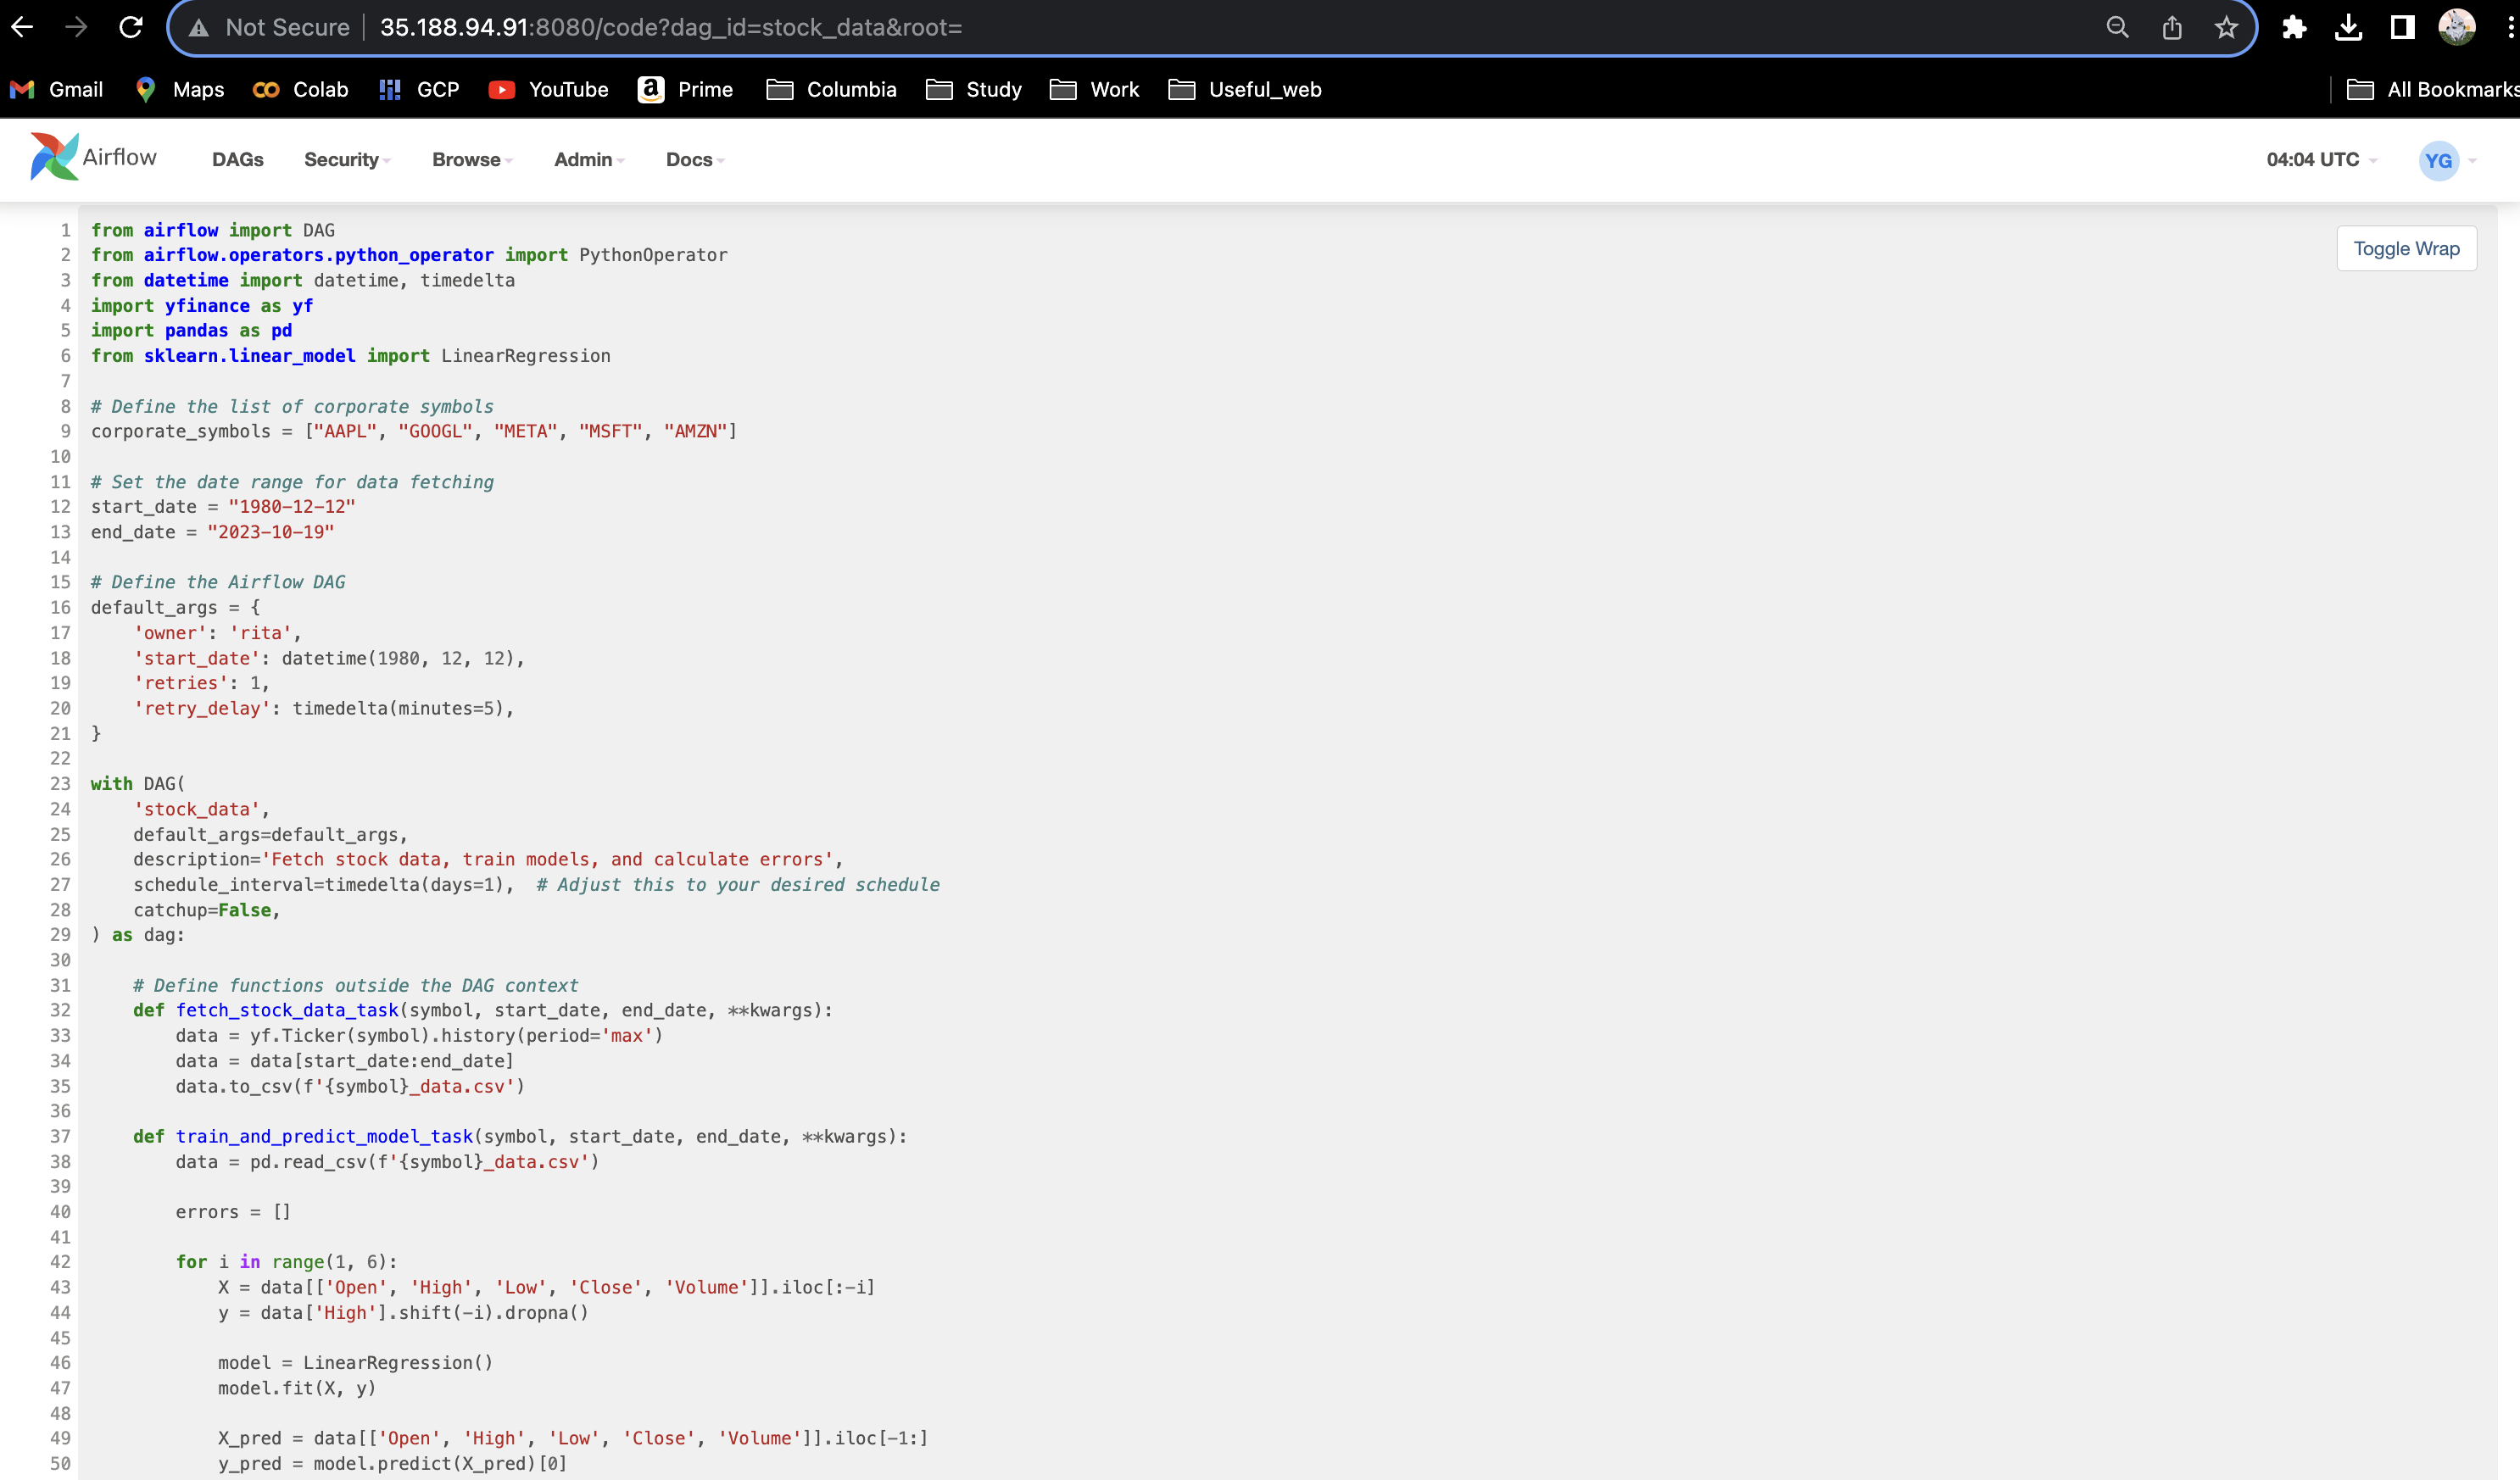
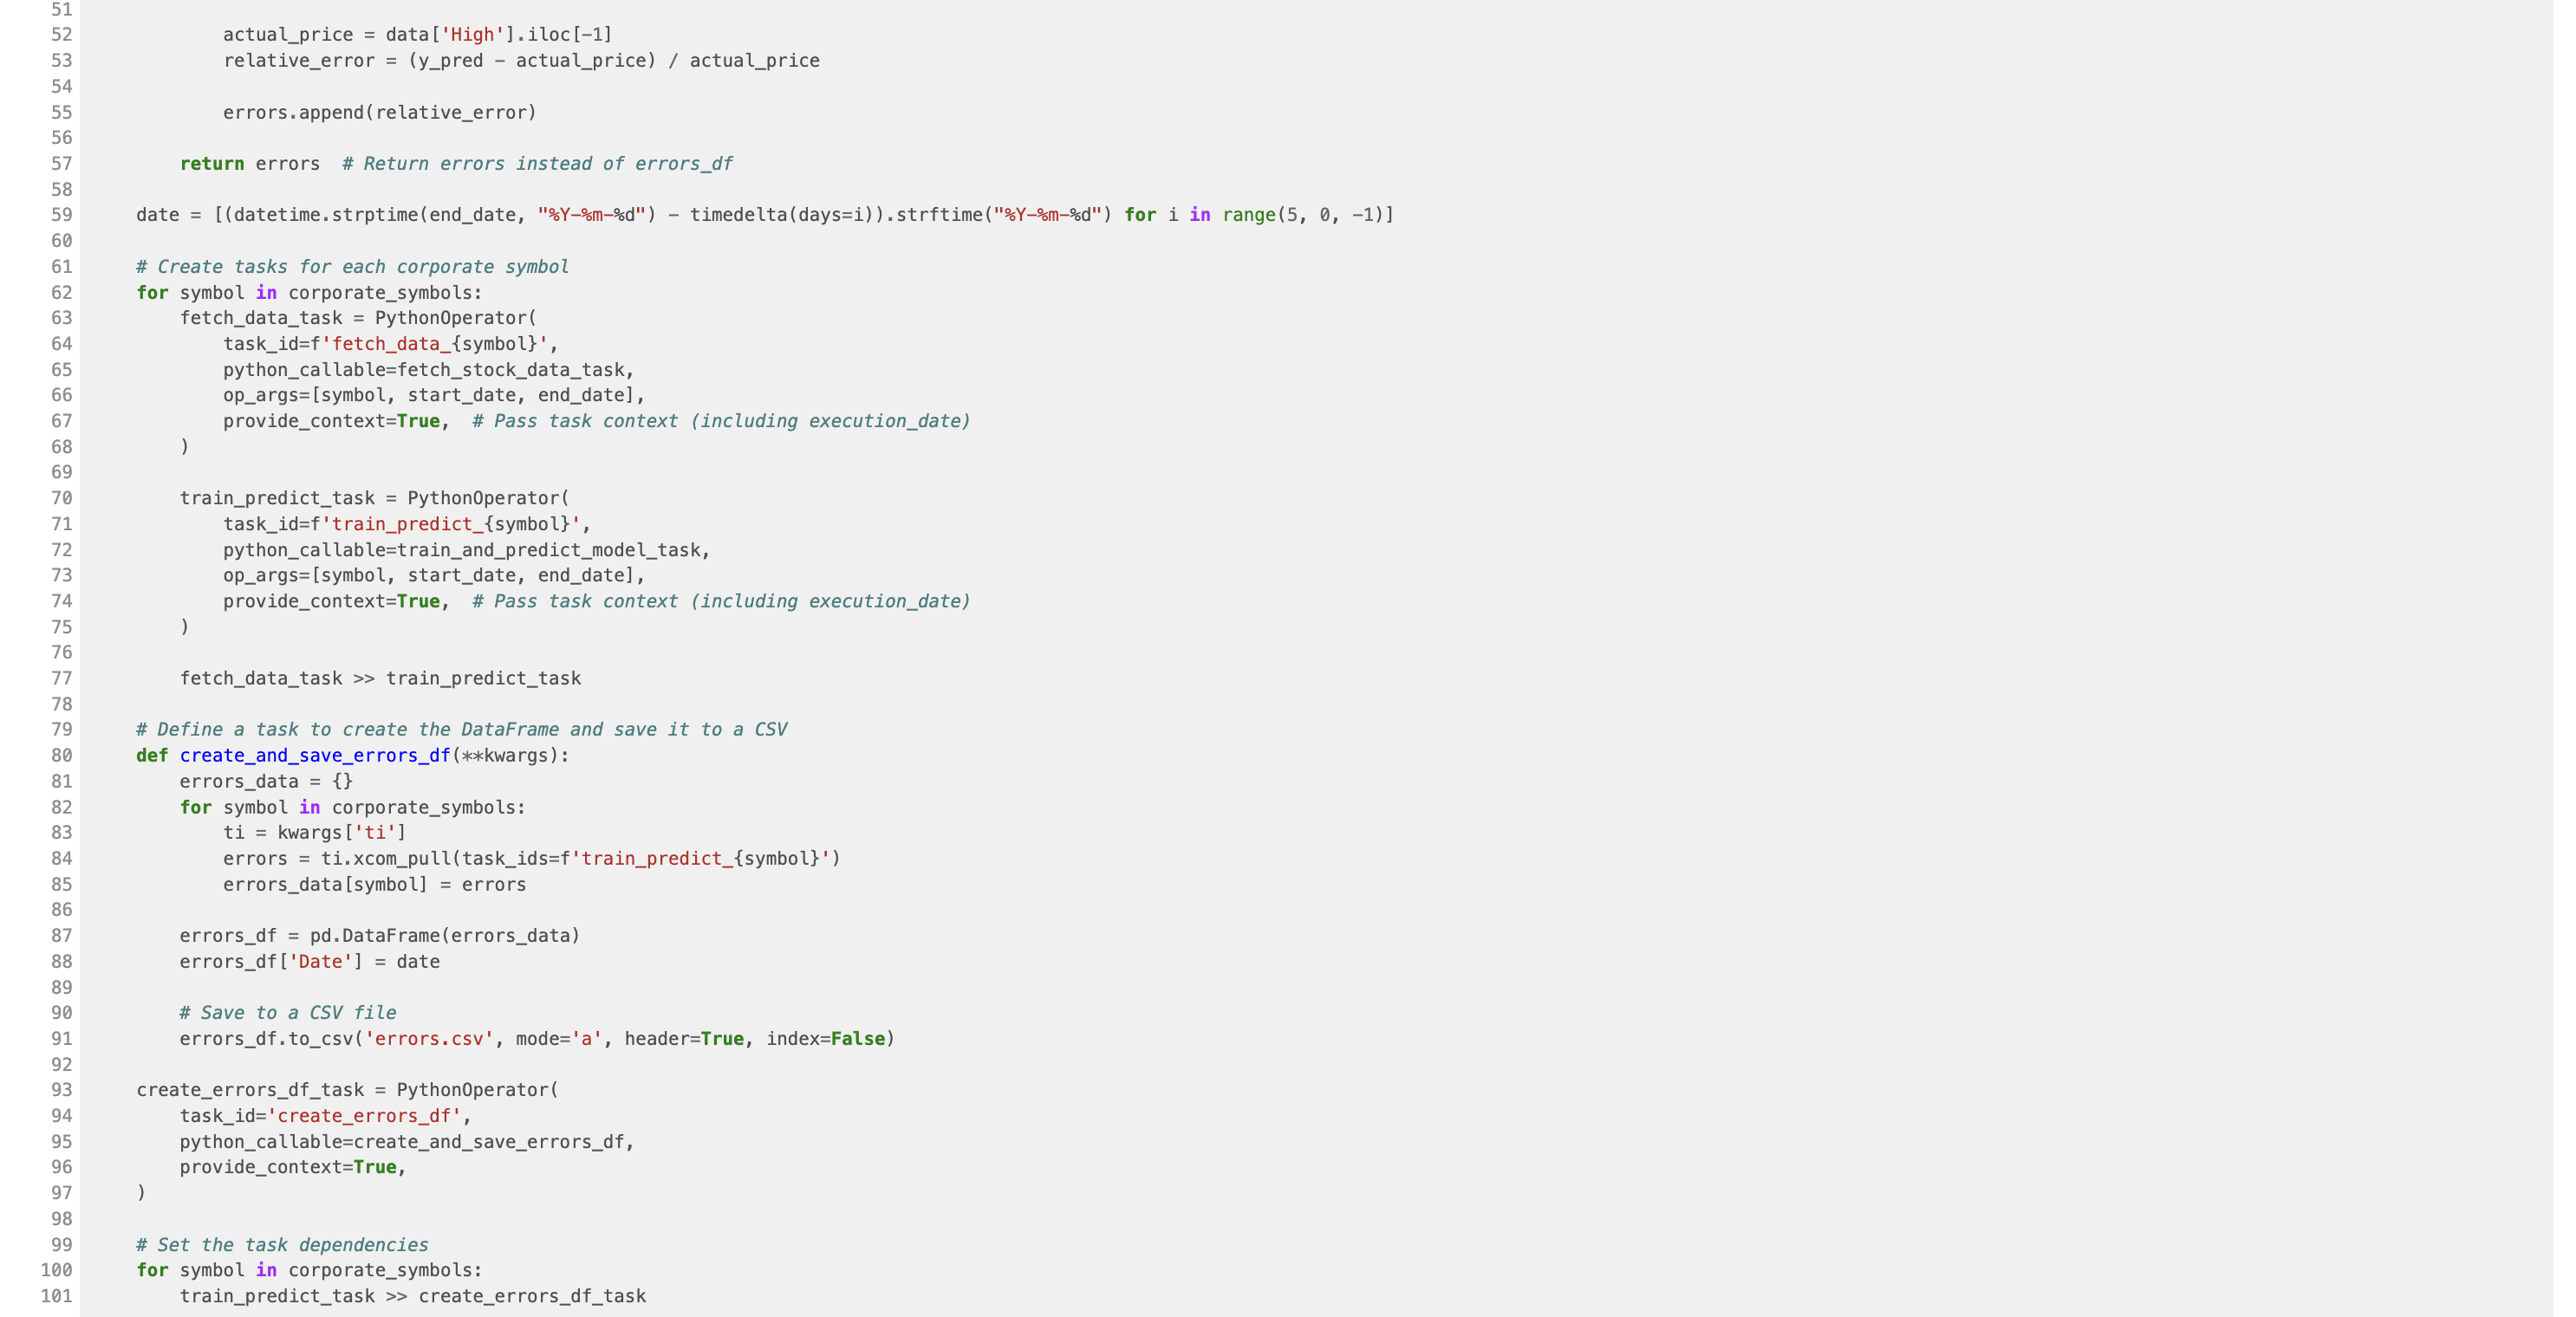

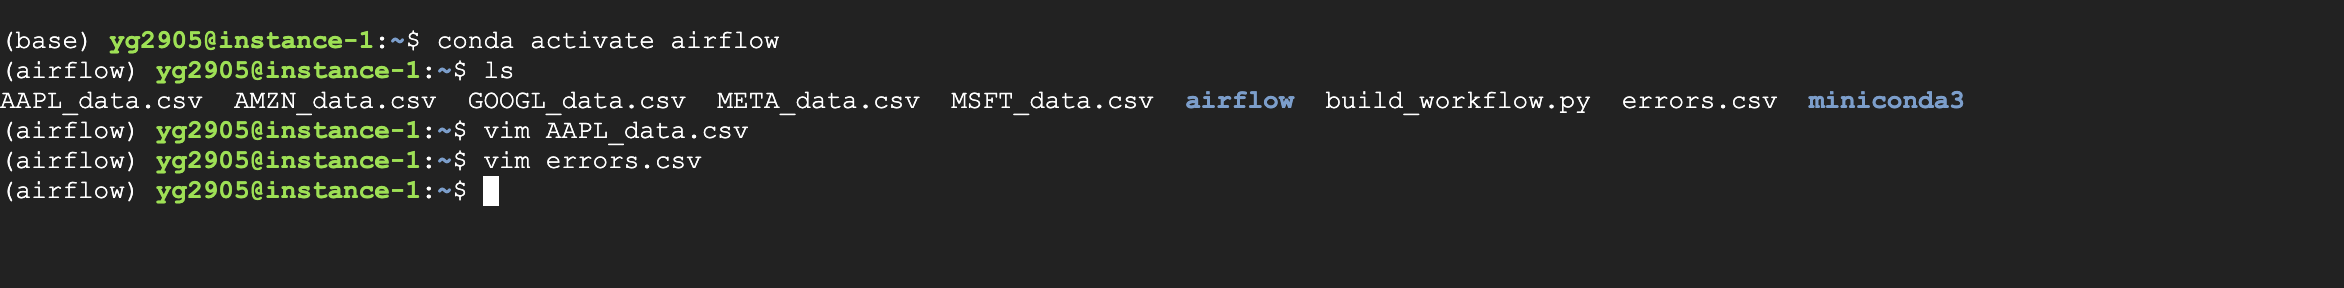
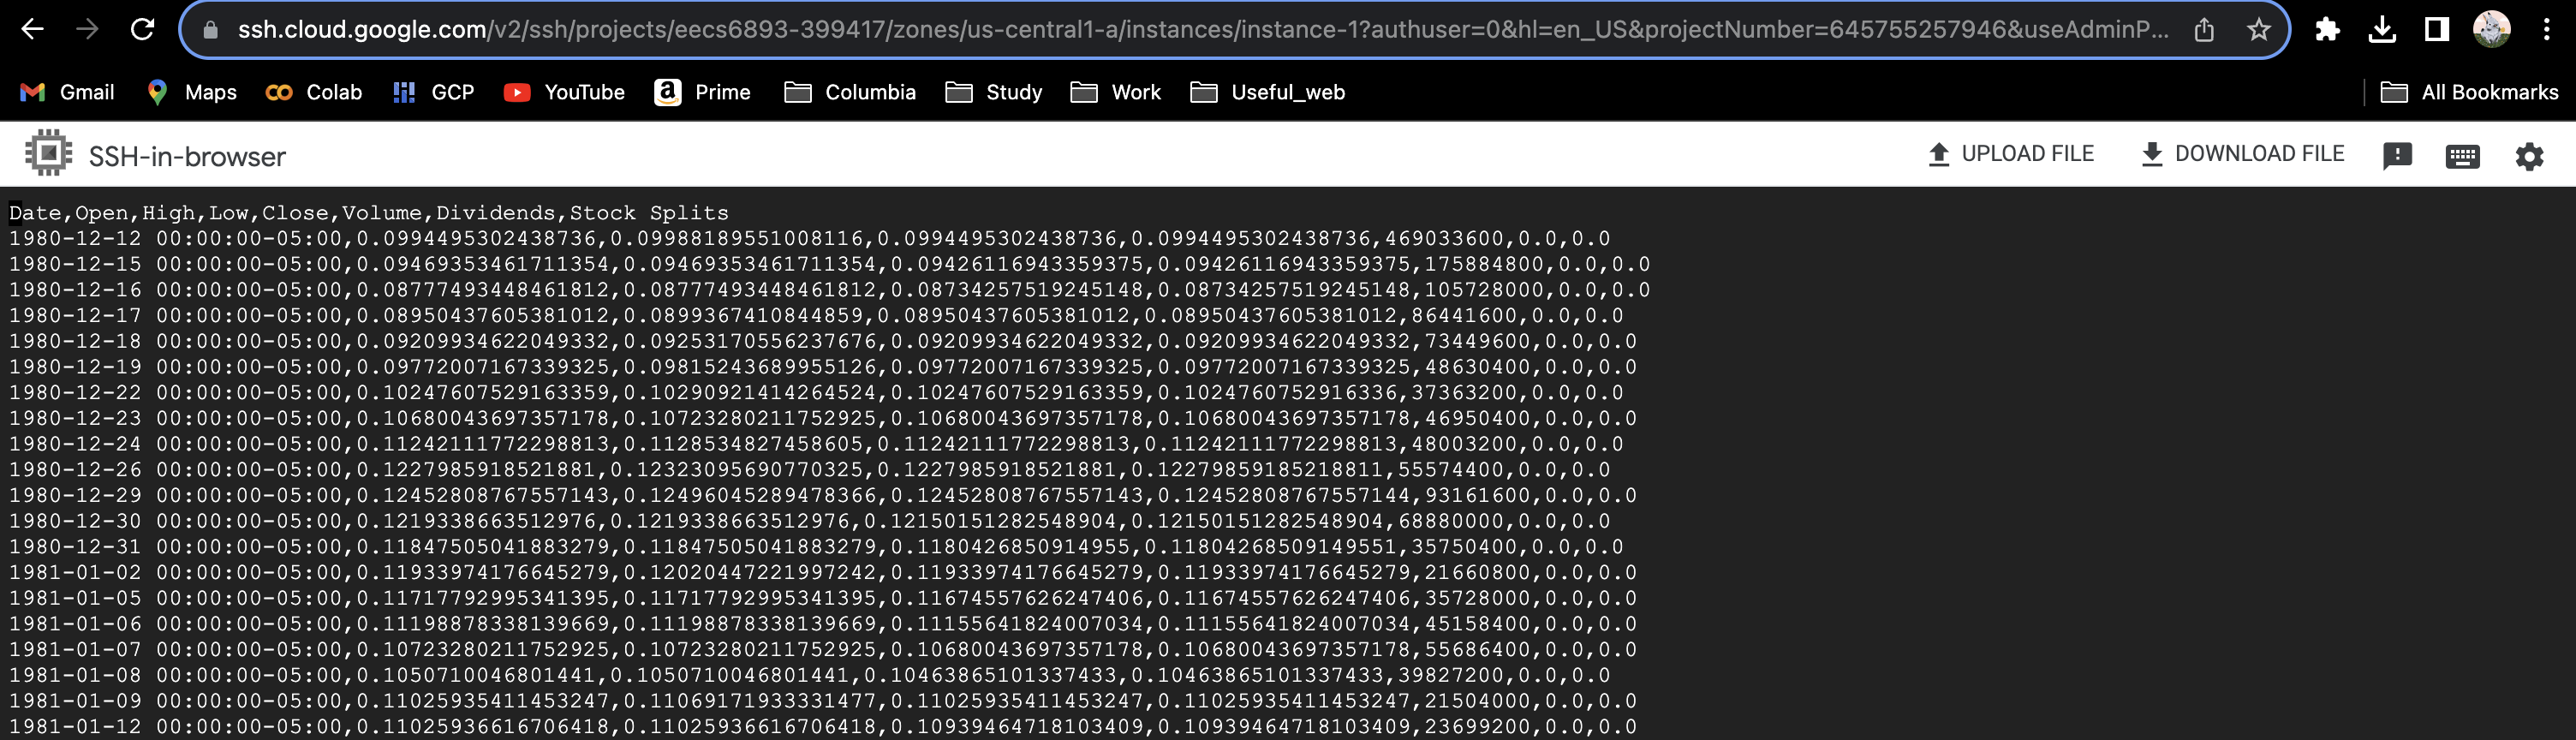
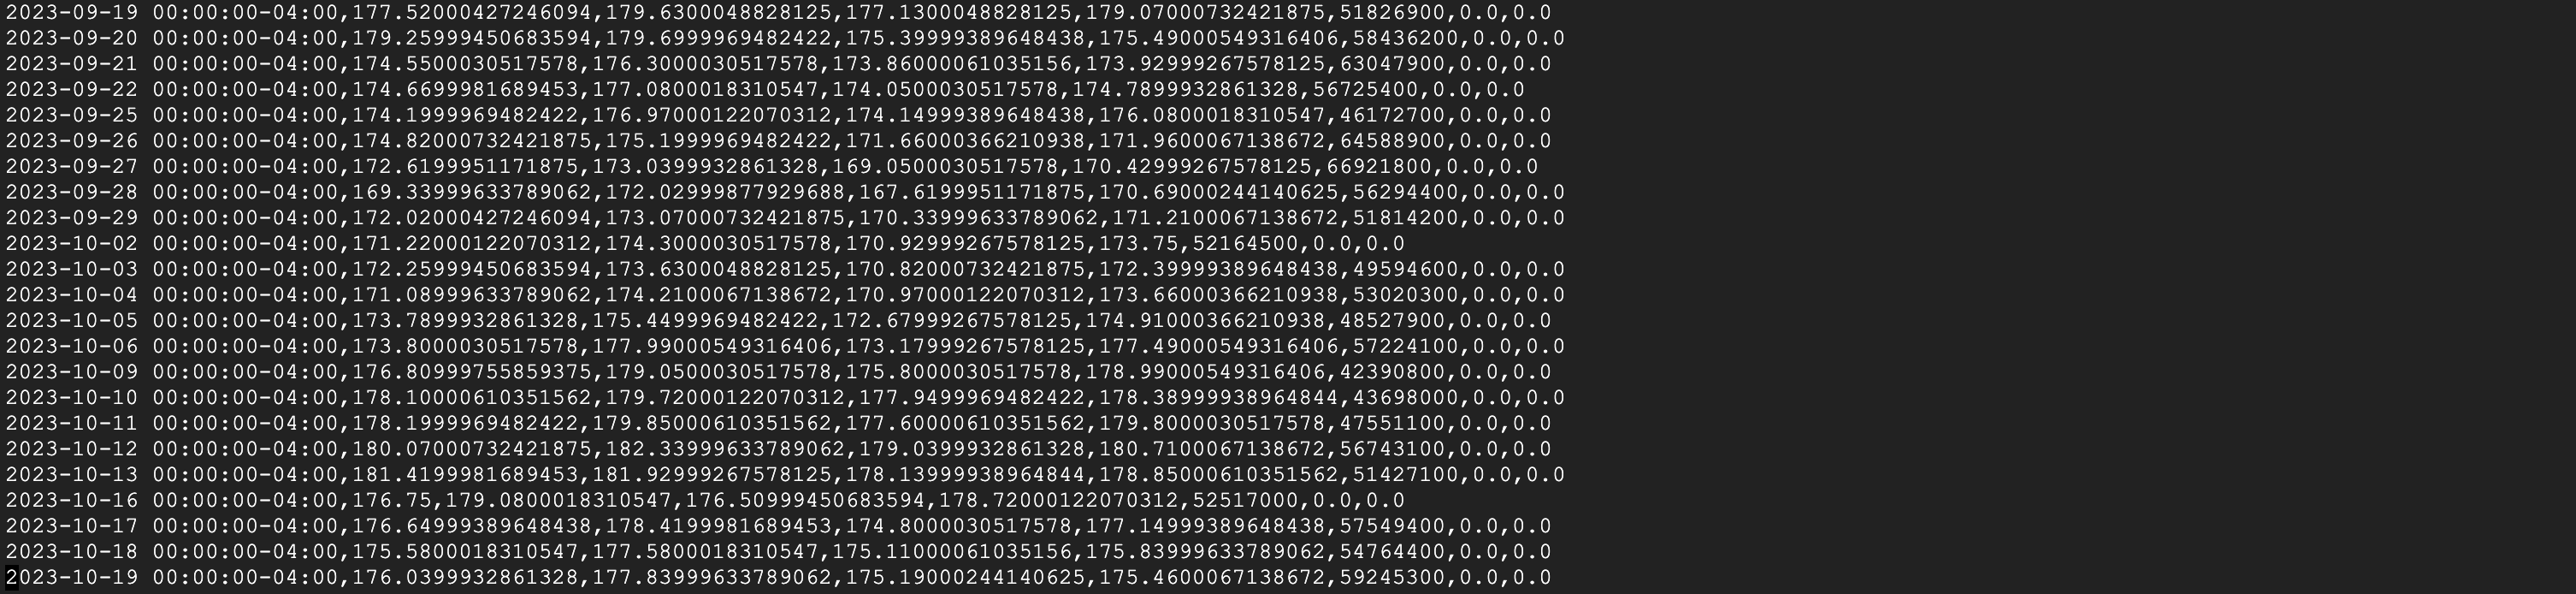

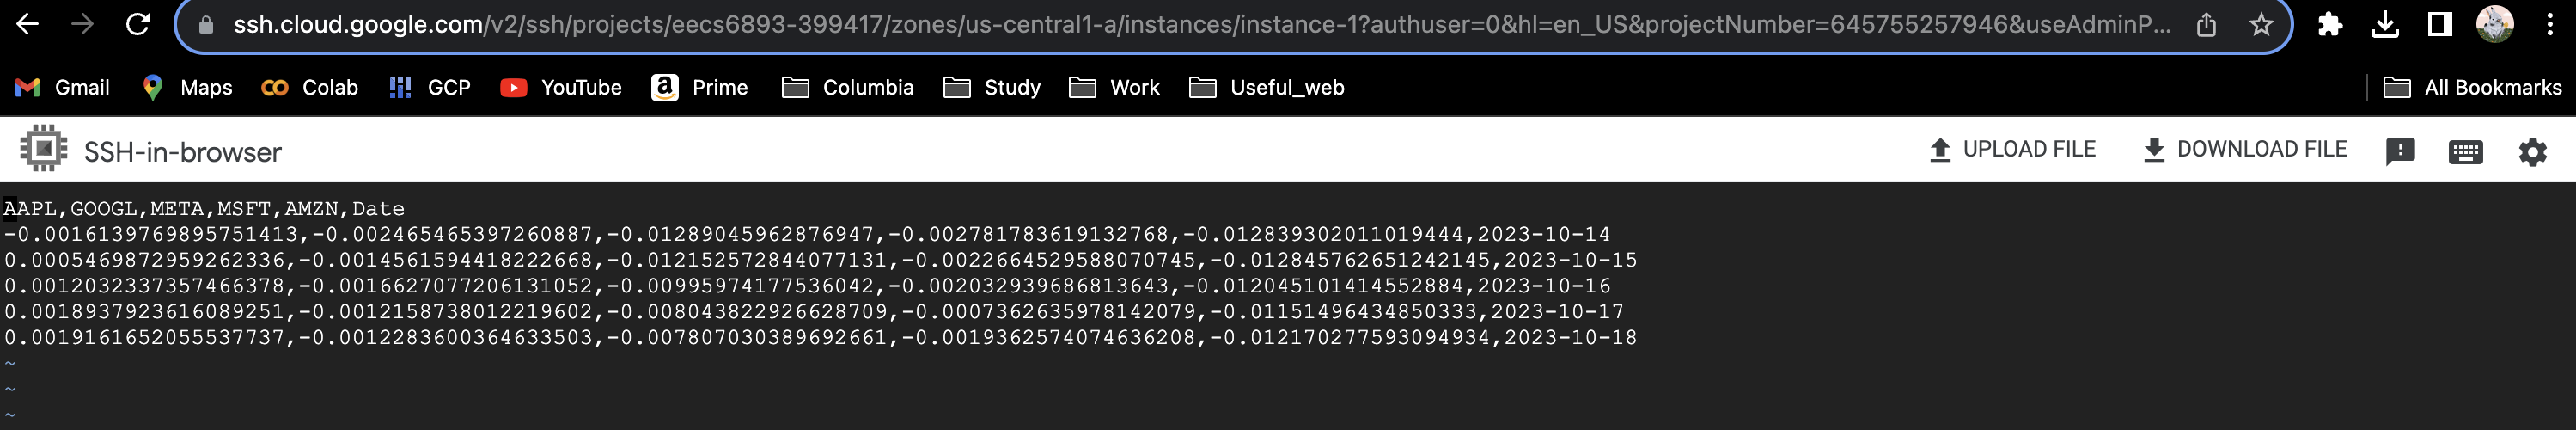
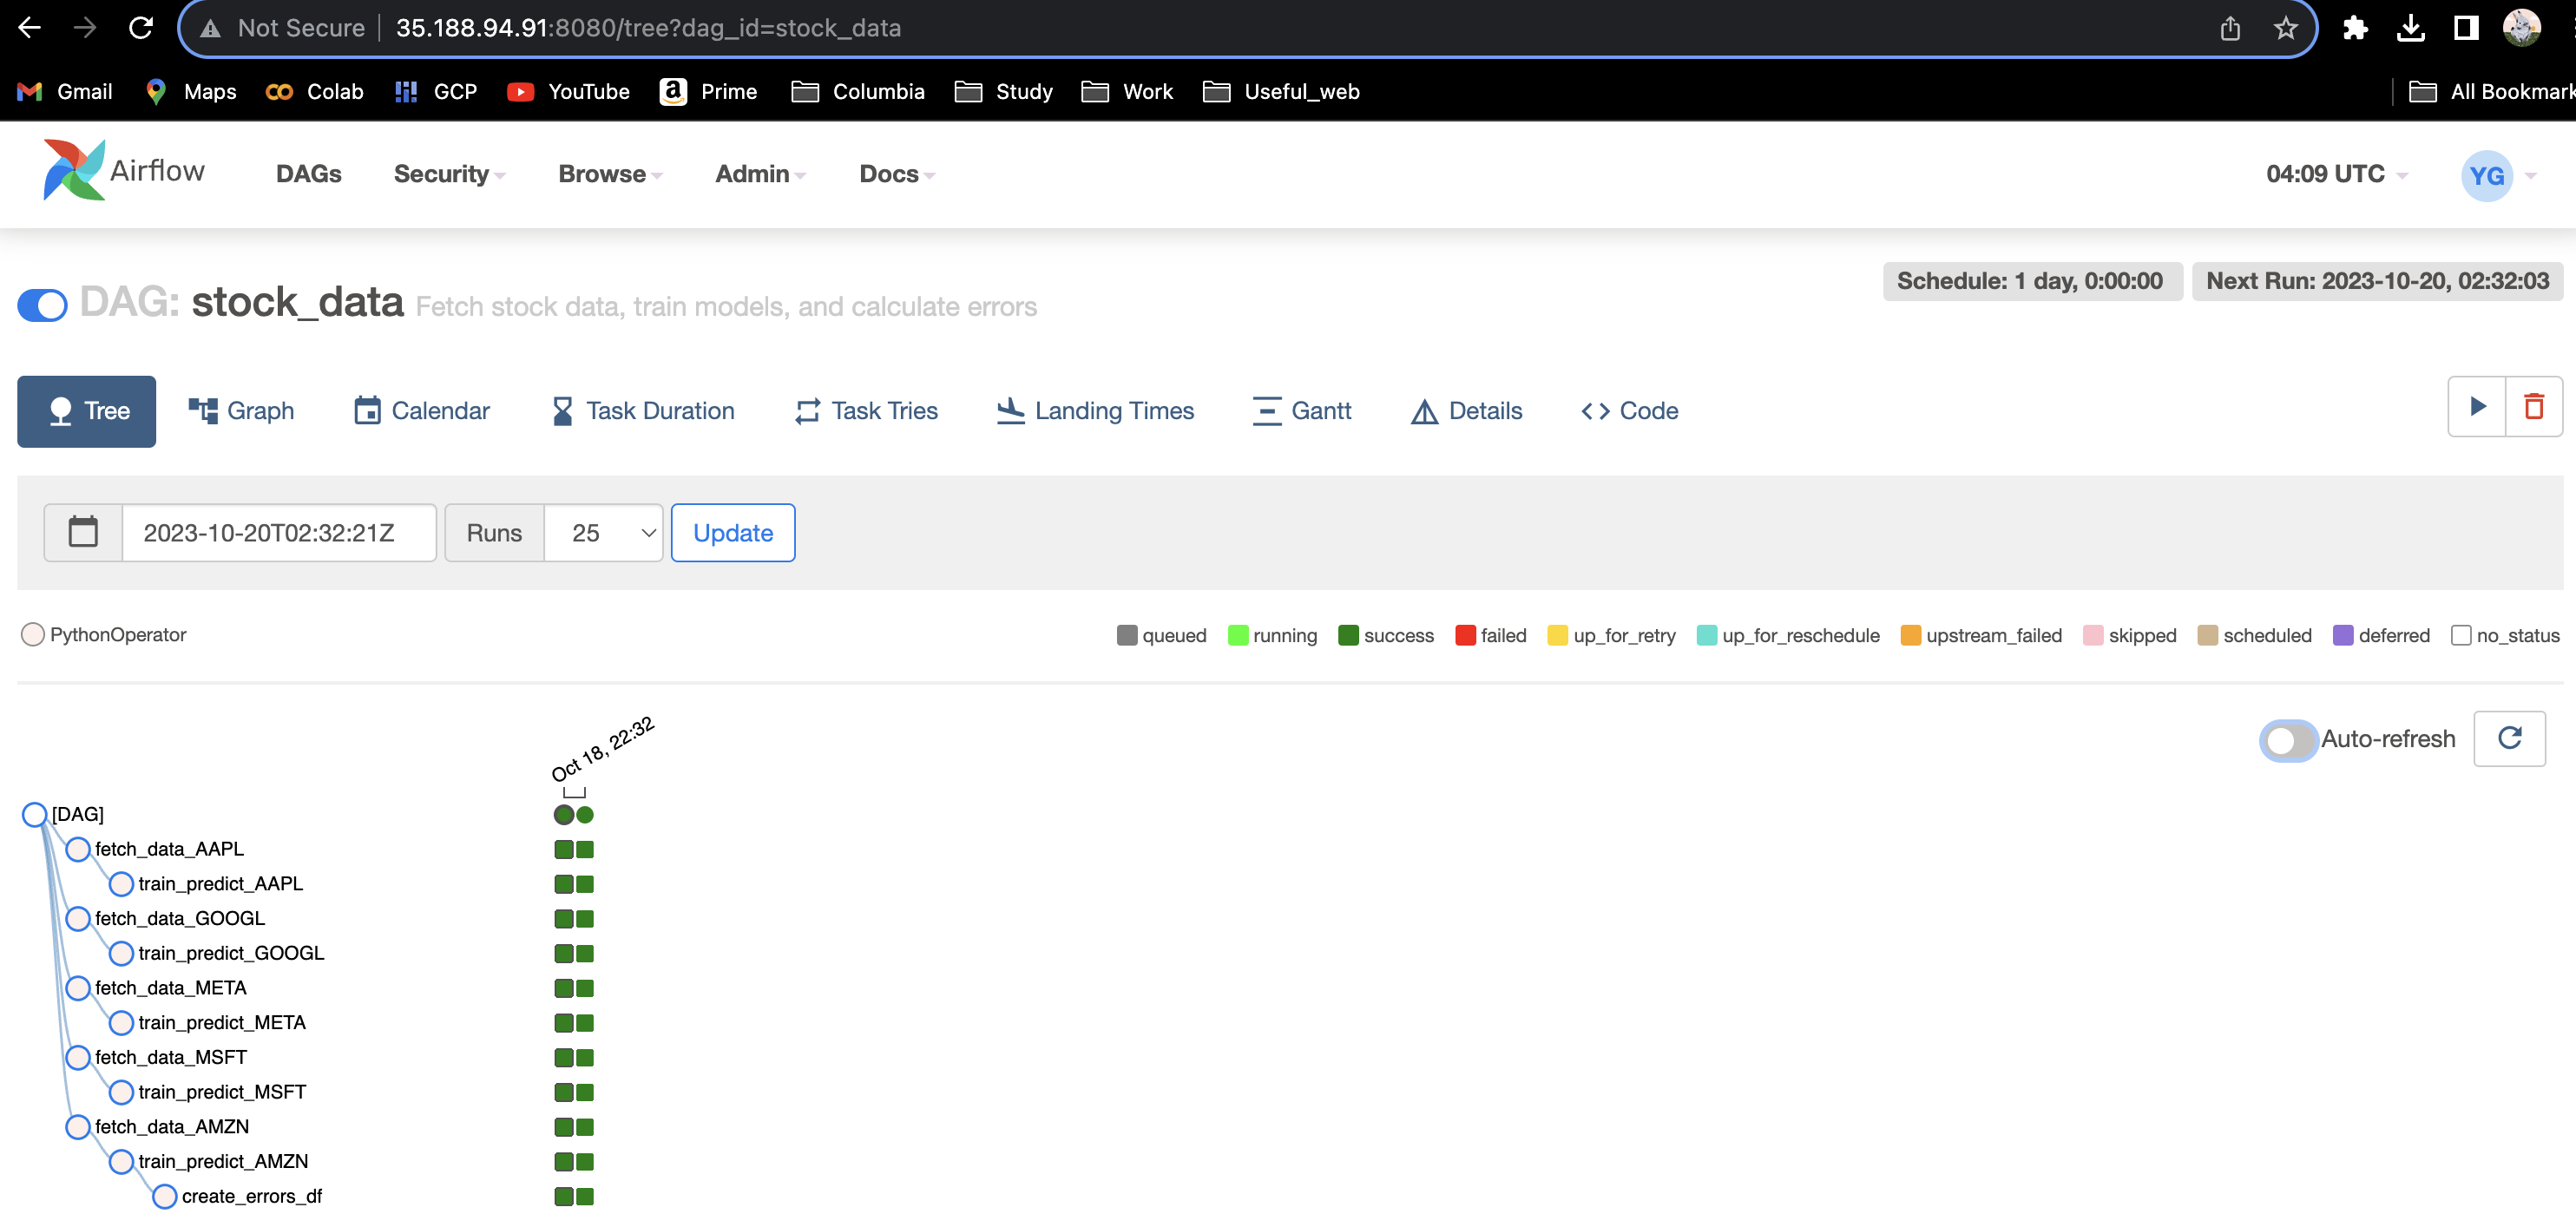

- DAG Configuration: The DAG is named 'stock_data' and is configured with some default arguments, such as the owner, start date, and retry settings. It's scheduled to run daily (schedule_interval=timedelta(days=1)).
- Task Functions: Two Python functions are defined outside the DAG context: fetch_stock_data_task: Fetches stock data for a given symbol using the Yahoo Finance API and stores it in a CSV file. train_and_predict_model_task: Reads the stock data from the CSV, trains a linear regression model, and calculates errors in predictions. 
- Symbol List and Date Range: The list of corporate symbols to fetch data for is defined in corporate_symbols, and the date range for data fetching is set with start_date and end_date.
- Symbol-Specific Tasks: For each corporate symbol in corporate_symbols, two tasks are created: fetch_data_task: Fetches stock data for the symbol and saves it to a CSV file. train_predict_task: Trains a model for the symbol and calculates errors. These tasks are chained, so data fetching is done before model training.
- Creating and Saving Errors DataFrame: After all symbol-specific tasks are completed, a final task -create_and_save_errors_df is defined. This task collects the errors from all symbols, creates a DataFrame, and saves it to a CSV file.
- Task Dependencies: Dependencies are set so that the create_and_save_errors_df task runs only after all the train_predict_task tasks for all symbols are completed.